<a href="https://colab.research.google.com/gist/roxdm/1e2af006862f4d25eeffc4dd6a564397/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational Auto-Encoders
=========================
This code implements a Variation Auto-Encoder (VAE). If using Google Colab, please activate the use of the GPU (Edit -> Notebok Settings).

In [15]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    !pip3 install torch torchvision #--index-url https://download.pytorch.org/whl/cu118 #uncomment to enforce cuda 11.8

if 'google.colab' in sys.modules and 'tqdm' not in sys.modules:
    !pip3 install tqdm

import os
import sys
from zipfile import ZipFile

sys.path.append('/kaggle/input/generate-zip/generative')

%matplotlib inline
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from matplotlib import gridspec

import os
if os.path.exists('./training') == False:
  os.mkdir('./training')

Hyper-Parameters
----------------

In [16]:
batch_size = 100     # batch size
latent_dim = 8      # latent-space dimension
num_channels = (128, 256, 384)
num_res_blocks = 1
norm_groups = 32
attention_levels = (False, False, True)
middle_dim = 96      # size of the middle layer
learning_rate = 5e-5  # learning rate
max_epochs = 50       # maximum number of epochs
use_gpu = True        # using the GPU
kl_weight = 0.1  # Start with a smaller weight for KL loss (adjust as needed)


Loading the Dataset
-------------------
The MedNIST dataset will be used, more specifically the hand CT images from the dataset. These are sized 64x64.

In [17]:

input_dim = 28**2

In [18]:
!pip install -q "monai-weekly[tqdm]"
try:
    import monai
    print("MONAI successfully imported!")
except ImportError as e:
    print(f"Error importing MONAI: {e}")
#!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

MONAI successfully imported!


In [19]:
import os
import shutil
import tempfile
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from torch.nn import L1Loss
from tqdm import tqdm

#from generative.losses import PatchAdversarialLoss, PerceptualLoss
#from generative.networks.nets import AutoencoderKL, PatchDiscriminator

In [20]:

# image dimensions
input_dim = 64*64

from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from torch.nn import L1Loss
from tqdm import tqdm

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
image_size = 64
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)


/tmp/tmpw2mtyq2m


MedNIST.tar.gz: 59.0MB [00:00, 122MB/s]                             

2025-05-27 17:06:05,291 - INFO - Downloaded: /tmp/tmpw2mtyq2m/MedNIST.tar.gz


2025-05-27 17:06:05,401 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2025-05-27 17:06:05,402 - INFO - Writing into directory: /tmp/tmpw2mtyq2m.


Loading dataset: 100%|██████████| 47164/47164 [00:28<00:00, 1655.98it/s]


In [21]:
train_ds = Dataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)

val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
test_dataloader = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

2025-05-27 17:06:46,517 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2025-05-27 17:06:46,518 - INFO - File exists: /tmp/tmpw2mtyq2m/MedNIST.tar.gz, skipped downloading.
2025-05-27 17:06:46,519 - INFO - Non-empty folder exists in /tmp/tmpw2mtyq2m/MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 5895/5895 [00:03<00:00, 1759.58it/s]


VAE Definition
--------------
We will now use a specific scheme to initialize our weights, called Xavier initialization. You can neglect this if you are using other layers than fully connected.

In [22]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [23]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, norm_groups=32):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm = nn.GroupNorm(norm_groups, out_channels)
        self.activation = nn.SiLU()  # Swish activation used in many modern autoencoders
        
    def forward(self, x):
        return self.activation(self.norm(self.conv(x)))

The following model represents the distribution encoder distribution q(z|x), together with the reparametrization trick.

In [24]:
class Q(nn.Module):
    def __init__(self, in_channels=1, latent_channels=8, num_channels=(128, 256, 384), 
                 num_res_blocks=1, norm_groups=32, attention_levels=(False, False, True)):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, num_channels[0], 3, padding=1)
        
        # Downsampling blocks
        self.down_blocks = nn.ModuleList()
        current_channels = num_channels[0]
        
        for i, channels in enumerate(num_channels):
            block = nn.ModuleList()
            
            # Residual blocks
            for _ in range(num_res_blocks):
                block.append(ResBlock(current_channels, norm_groups))
            
            # Attention (simplified - you might want to implement proper attention)
            if attention_levels[i]:
                block.append(nn.MultiheadAttention(current_channels, 8, batch_first=True))
            
            # Downsample (except for last block)
            if i < len(num_channels) - 1:
                block.append(nn.Conv2d(current_channels, channels, 4, stride=2, padding=1))
                current_channels = channels
            
            self.down_blocks.append(block)
        
        # Final convolution to latent space
        self.conv_out_mu = nn.Conv2d(current_channels, latent_channels, 3, padding=1)
        self.conv_out_var = nn.Conv2d(current_channels, latent_channels, 3, padding=1)


    def forward(self, x):
        x = self.conv_in(x)
        
        for block in self.down_blocks:
            for layer in block:
                if isinstance(layer, nn.MultiheadAttention):
                    # Flatten for attention, then reshape back
                    b, c, h, w = x.shape
                    x_flat = x.view(b, c, h*w).transpose(1, 2)
                    x_flat, _ = layer(x_flat, x_flat, x_flat)
                    x = x_flat.transpose(1, 2).view(b, c, h, w)
                else:
                    x = layer(x)
        
        mu = self.conv_out_mu(x)
        log_var = self.conv_out_var(x)
        return mu, log_var
    
class ResBlock(nn.Module):
    def __init__(self, channels, norm_groups=32):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(norm_groups, channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(norm_groups, channels)
        self.activation = nn.SiLU()
        
    def forward(self, x):
        residual = x
        x = self.activation(self.norm1(self.conv1(x)))
        x = self.norm2(self.conv2(x))
        return self.activation(x + residual)

We now model the reparametrization trick.

In [25]:
class Reparametrization(nn.Module):
  def __init__(self):
    super(Reparametrization, self).__init__()

  def forward(self, z_mu, z_var):
    eps = torch.randn(z_var.size(0), z_var.size(1), device=device) # sample on a unit Gaussian
    eps = torch.randn_like(z_var)
    return z_mu + torch.exp(z_var/2) * eps

The following model represents the decoder P(x|z).

In [26]:
class P(nn.Module):
    def __init__(self, out_channels=1, latent_channels=8, num_channels=(384, 256, 128),
                 num_res_blocks=1, norm_groups=32):
        super().__init__()
        self.conv_in = nn.Conv2d(latent_channels, num_channels[0], 3, padding=1)
        
        # Upsampling blocks
        self.up_blocks = nn.ModuleList()
        current_channels = num_channels[0]
        
        for i, channels in enumerate(num_channels[1:] + (out_channels,)):
            block = nn.ModuleList()
            
            # Residual blocks
            for _ in range(num_res_blocks):
                block.append(ResBlock(current_channels, norm_groups))
            
            # Upsample
            if i < len(num_channels):
                block.append(nn.ConvTranspose2d(current_channels, channels, 4, stride=2, padding=1))
                current_channels = channels
            
            self.up_blocks.append(block)
        
        self.conv_out = nn.Conv2d(current_channels, out_channels, 3, padding=1)
        self.final_activation = nn.Sigmoid()  # For pixel values in [0,1]
    
    def forward(self, x):
        x = self.conv_in(x)
        
        for block in self.up_blocks:
            for layer in block:
                x = layer(x)
        
        x = self.conv_out(x)
        return self.final_activation(x)


Training
--------

We first initialize an instance of the model and load it onto GPU if relevant.

In [27]:
# creating instances of the model
q = Q(in_channels=1, latent_channels=latent_dim, num_channels=num_channels, 
            num_res_blocks=num_res_blocks, norm_groups=norm_groups, attention_levels=attention_levels)
p = P(out_channels=1, latent_channels=latent_dim, num_channels=num_channels[::-1], 
            num_res_blocks=num_res_blocks, norm_groups=norm_groups)
reparam = Reparametrization()

# loading them onto the GPU if relevant
if use_gpu and torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using the GPU (faster).")
else:
  device = torch.device("cpu")
  print("Using the CPU.")

q = q.to(device)
p = p.to(device)
reparam = reparam.to(device)

# computing the number of parameters
num_params_gen = sum(param.numel() for param in p.parameters() if param.requires_grad)
num_params_disc = sum(param.numel() for param in q.parameters() if param.requires_grad)
print('Number of parameters for encoder: %d and decoder: %d' % (num_params_gen, num_params_disc))

Using the GPU (faster).
Number of parameters for encoder: 6261003 and decoder: 2860688


We can now do the training properly speaking.

In [30]:
# Training setup
q.train()
p.train()
reparam.train()

parameters = list(p.parameters()) + list(q.parameters())
optim = torch.optim.Adam(parameters, lr=learning_rate, betas=(0.15, 0.999))
bce = nn.BCELoss(reduction='mean')

total_losses = []
recon_losses = []
kl_losses = []
current_image = 0

print('Training...')
for epoch in range(max_epochs):
    avg_total_loss = 0
    avg_recon_loss = 0
    avg_kl_loss = 0
    num_batches = 0
    
    for batch_idx, batch_data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
    # Extract image from MedNIST batch
        if isinstance(batch_data, dict):
            batch = batch_data['image']
        elif isinstance(batch_data, (list, tuple)):
            batch = batch_data[0]  # Take first element if it's a tuple/list
        else:
            batch = batch_data
        
        # Convert MONAI MetaTensor to regular tensor if needed
        if hasattr(batch, 'as_tensor'):
            batch = batch.as_tensor()
        
        batch = batch.to(device)
        
        # Debug: Print batch shape to understand the issue
        if batch_idx == 0 and epoch == 0:
            print(f"Batch shape: {batch.shape}")
            print(f"Batch size: {batch.size(0)}")
        
        # Ensure we have the right dimensions [batch_size, channels, height, width]
        if batch.dim() == 3:  # [batch_size, height, width] - add channel dimension
            batch = batch.unsqueeze(1)
        elif batch.dim() == 2:  # [batch_size, flattened] - reshape to image format
            # Assuming square images, calculate side length
            batch_size = batch.size(0)
            total_pixels = batch.size(1)
            side_length = int(total_pixels ** 0.5)
            batch = batch.view(batch_size, 1, side_length, side_length)
        elif batch.dim() == 4:  # [batch_size, channels, height, width] - normal case
            pass  # Keep as is - this is the correct format for convolutional layers
        else:
            raise ValueError(f"Unexpected batch dimensions: {batch.shape}")
        
        # Forward pass
        z_mu, z_var = q(batch)
        print(f"z_mu shape: {z_mu.shape}, z_var shape: {z_var.shape}")  # Debugging line
        # Reparameterization trick
        z = reparam(z_mu, z_var)
        batch_recon = p(z)
        batch_recon = nn.functional.interpolate(batch_recon, size=(64, 64), mode="bilinear", align_corners=False)

        # Reconstruction loss E[log P(X|z)]
        recon_loss = bce(batch_recon, batch)
        
        # KL divergence loss D_KL(Q(z|X) || P(z))
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu ** 2 - 1. - z_var, 1))
        
        # Total loss
        total_loss = recon_loss + kl_weight*kl_loss
        
        # Backward pass
        optim.zero_grad()
        total_loss.backward()
        optim.step()
        
        # Accumulate losses
        avg_total_loss += total_loss.item()
        avg_recon_loss += recon_loss.item()
        avg_kl_loss += kl_loss.item()
        num_batches += 1
    
    # Calculate average losses
    avg_total_loss /= num_batches
    avg_recon_loss /= num_batches
    avg_kl_loss /= num_batches
    
    total_losses.append(avg_total_loss)
    recon_losses.append(avg_recon_loss)
    kl_losses.append(avg_kl_loss)
    
    print(f"\t[Losses] Total {total_losses[-1]:.3f} - Recon. {recon_losses[-1]:.3f} - KL {kl_losses[-1]:.3f}")
    
    # Generate and save samples
    if epoch % 2 == 0:
        with torch.no_grad():
            # Sample from latent space
            #z_sample = torch.randn(16, latent_dim).to(device)
            sample_shape = z_mu.shape  # or z.shape
            z_sample = torch.randn(sample_shape).to(device)
            samples = p(z_sample).data.cpu().numpy()
            samples = samples[:16]
            plt.close('all')
            fig = plt.figure(figsize=(8, 8))
            gs = gridspec.GridSpec(4, 4)
            gs.update(wspace=0.05, hspace=0.05)
            
            for i, sample in enumerate(samples):
                ax = plt.subplot(gs[i])
                plt.axis('off')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')
                # Reshape back to 64x64 for display
                plt.imshow(sample.squeeze(), cmap='gray')
            
            # Create output directory
            if not os.path.exists('training/'):
                os.makedirs('training/')
            
            plt.savefig(f'training/{epoch}_{str(current_image).zfill(3)}.png', 
                       bbox_inches='tight', dpi=100)
            current_image += 1
            plt.close(fig)

print("Training completed!")

Training...


Epoch 0:   0%|          | 0/80 [00:00<?, ?it/s]

Batch shape: torch.Size([100, 1, 64, 64])
Batch size: 100
z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:   1%|▏         | 1/80 [00:01<01:53,  1.44s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:   2%|▎         | 2/80 [00:02<01:34,  1.21s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:   4%|▍         | 3/80 [00:03<01:27,  1.13s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:   5%|▌         | 4/80 [00:04<01:23,  1.10s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:   6%|▋         | 5/80 [00:05<01:22,  1.10s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:   8%|▊         | 6/80 [00:06<01:20,  1.08s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:   9%|▉         | 7/80 [00:07<01:19,  1.09s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  10%|█         | 8/80 [00:08<01:18,  1.09s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  11%|█▏        | 9/80 [00:10<01:17,  1.09s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  12%|█▎        | 10/80 [00:11<01:16,  1.09s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  14%|█▍        | 11/80 [00:12<01:15,  1.10s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  15%|█▌        | 12/80 [00:13<01:14,  1.10s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  16%|█▋        | 13/80 [00:14<01:14,  1.11s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  18%|█▊        | 14/80 [00:15<01:12,  1.10s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  19%|█▉        | 15/80 [00:16<01:12,  1.12s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  20%|██        | 16/80 [00:17<01:11,  1.11s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  21%|██▏       | 17/80 [00:18<01:10,  1.11s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  22%|██▎       | 18/80 [00:20<01:08,  1.11s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  24%|██▍       | 19/80 [00:21<01:07,  1.10s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  25%|██▌       | 20/80 [00:22<01:05,  1.09s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  26%|██▋       | 21/80 [00:23<01:03,  1.08s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  28%|██▊       | 22/80 [00:24<01:02,  1.07s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  29%|██▉       | 23/80 [00:25<01:01,  1.07s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  30%|███       | 24/80 [00:26<00:59,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  31%|███▏      | 25/80 [00:27<00:57,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  32%|███▎      | 26/80 [00:28<00:56,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  34%|███▍      | 27/80 [00:29<00:55,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  35%|███▌      | 28/80 [00:30<00:53,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  36%|███▋      | 29/80 [00:31<00:52,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  38%|███▊      | 30/80 [00:32<00:51,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  39%|███▉      | 31/80 [00:33<00:50,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  40%|████      | 32/80 [00:34<00:48,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  41%|████▏     | 33/80 [00:35<00:47,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  42%|████▎     | 34/80 [00:36<00:46,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  44%|████▍     | 35/80 [00:37<00:45,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  45%|████▌     | 36/80 [00:38<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  46%|████▋     | 37/80 [00:39<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  48%|████▊     | 38/80 [00:40<00:41,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  49%|████▉     | 39/80 [00:41<00:40,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  50%|█████     | 40/80 [00:42<00:39,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  51%|█████▏    | 41/80 [00:43<00:37,  1.03it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  52%|█████▎    | 42/80 [00:44<00:36,  1.03it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  54%|█████▍    | 43/80 [00:45<00:35,  1.03it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  55%|█████▌    | 44/80 [00:46<00:34,  1.04it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  56%|█████▋    | 45/80 [00:47<00:33,  1.04it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  57%|█████▊    | 46/80 [00:48<00:32,  1.04it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  59%|█████▉    | 47/80 [00:49<00:31,  1.04it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  60%|██████    | 48/80 [00:50<00:30,  1.04it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  61%|██████▏   | 49/80 [00:50<00:29,  1.05it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  62%|██████▎   | 50/80 [00:51<00:28,  1.05it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  64%|██████▍   | 51/80 [00:52<00:27,  1.04it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  65%|██████▌   | 52/80 [00:53<00:26,  1.05it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  66%|██████▋   | 53/80 [00:54<00:25,  1.05it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  68%|██████▊   | 54/80 [00:55<00:24,  1.05it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  69%|██████▉   | 55/80 [00:56<00:23,  1.04it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  70%|███████   | 56/80 [00:57<00:22,  1.05it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  71%|███████▏  | 57/80 [00:58<00:21,  1.05it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  72%|███████▎  | 58/80 [00:59<00:20,  1.05it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  74%|███████▍  | 59/80 [01:00<00:20,  1.04it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  75%|███████▌  | 60/80 [01:01<00:19,  1.05it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  76%|███████▋  | 61/80 [01:02<00:18,  1.05it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  78%|███████▊  | 62/80 [01:03<00:17,  1.05it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  79%|███████▉  | 63/80 [01:04<00:16,  1.04it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  80%|████████  | 64/80 [01:05<00:15,  1.05it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  81%|████████▏ | 65/80 [01:06<00:14,  1.05it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  82%|████████▎ | 66/80 [01:07<00:13,  1.05it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  84%|████████▍ | 67/80 [01:08<00:12,  1.04it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  85%|████████▌ | 68/80 [01:09<00:11,  1.04it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  86%|████████▋ | 69/80 [01:10<00:10,  1.04it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  88%|████████▊ | 70/80 [01:11<00:09,  1.04it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  89%|████████▉ | 71/80 [01:12<00:08,  1.03it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  90%|█████████ | 72/80 [01:13<00:07,  1.04it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  91%|█████████▏| 73/80 [01:13<00:06,  1.03it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  92%|█████████▎| 74/80 [01:14<00:05,  1.03it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  94%|█████████▍| 75/80 [01:15<00:04,  1.03it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  95%|█████████▌| 76/80 [01:16<00:03,  1.03it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  96%|█████████▋| 77/80 [01:17<00:02,  1.03it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  98%|█████████▊| 78/80 [01:18<00:01,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 0:  99%|█████████▉| 79/80 [01:19<00:00,  1.02it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 0: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.416 - Recon. 0.393 - KL 0.229


Epoch 1:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:   1%|▏         | 1/80 [00:01<02:06,  1.60s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:   2%|▎         | 2/80 [00:02<01:36,  1.24s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:   4%|▍         | 3/80 [00:03<01:26,  1.12s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:   5%|▌         | 4/80 [00:04<01:21,  1.07s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:   6%|▋         | 5/80 [00:05<01:19,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:   8%|▊         | 6/80 [00:06<01:16,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:   9%|▉         | 7/80 [00:07<01:14,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  10%|█         | 8/80 [00:08<01:13,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  11%|█▏        | 9/80 [00:09<01:13,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  12%|█▎        | 10/80 [00:10<01:11,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  14%|█▍        | 11/80 [00:11<01:10,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  15%|█▌        | 12/80 [00:12<01:09,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  16%|█▋        | 13/80 [00:13<01:09,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  18%|█▊        | 14/80 [00:14<01:07,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  19%|█▉        | 15/80 [00:15<01:06,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  20%|██        | 16/80 [00:16<01:04,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  21%|██▏       | 17/80 [00:17<01:04,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  22%|██▎       | 18/80 [00:18<01:03,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  24%|██▍       | 19/80 [00:19<01:02,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  25%|██▌       | 20/80 [00:20<01:00,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  26%|██▋       | 21/80 [00:21<01:00,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  28%|██▊       | 22/80 [00:22<00:59,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  29%|██▉       | 23/80 [00:23<00:58,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  30%|███       | 24/80 [00:24<00:56,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  31%|███▏      | 25/80 [00:26<00:56,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  32%|███▎      | 26/80 [00:27<00:55,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  34%|███▍      | 27/80 [00:28<00:54,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  35%|███▌      | 28/80 [00:29<00:52,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  36%|███▋      | 29/80 [00:30<00:52,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  38%|███▊      | 30/80 [00:31<00:51,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  39%|███▉      | 31/80 [00:32<00:49,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  40%|████      | 32/80 [00:33<00:48,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  41%|████▏     | 33/80 [00:34<00:48,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  42%|████▎     | 34/80 [00:35<00:46,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  44%|████▍     | 35/80 [00:36<00:45,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  45%|████▌     | 36/80 [00:37<00:44,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  46%|████▋     | 37/80 [00:38<00:44,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  48%|████▊     | 38/80 [00:39<00:42,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  49%|████▉     | 39/80 [00:40<00:41,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  50%|█████     | 40/80 [00:41<00:40,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  51%|█████▏    | 41/80 [00:42<00:39,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  52%|█████▎    | 42/80 [00:43<00:38,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  54%|█████▍    | 43/80 [00:44<00:37,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  55%|█████▌    | 44/80 [00:45<00:35,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  56%|█████▋    | 45/80 [00:46<00:35,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  57%|█████▊    | 46/80 [00:47<00:34,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  59%|█████▉    | 47/80 [00:48<00:32,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  60%|██████    | 48/80 [00:49<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  61%|██████▏   | 49/80 [00:50<00:31,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  62%|██████▎   | 50/80 [00:51<00:29,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  64%|██████▍   | 51/80 [00:52<00:28,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  65%|██████▌   | 52/80 [00:53<00:27,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  66%|██████▋   | 53/80 [00:54<00:26,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  68%|██████▊   | 54/80 [00:55<00:25,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  69%|██████▉   | 55/80 [00:56<00:24,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  70%|███████   | 56/80 [00:57<00:23,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  71%|███████▏  | 57/80 [00:58<00:23,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  72%|███████▎  | 58/80 [00:59<00:21,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  74%|███████▍  | 59/80 [01:00<00:20,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  75%|███████▌  | 60/80 [01:01<00:19,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  76%|███████▋  | 61/80 [01:02<00:18,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  78%|███████▊  | 62/80 [01:03<00:17,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  79%|███████▉  | 63/80 [01:04<00:16,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  80%|████████  | 64/80 [01:05<00:15,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  81%|████████▏ | 65/80 [01:06<00:14,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  82%|████████▎ | 66/80 [01:07<00:13,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  84%|████████▍ | 67/80 [01:08<00:12,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  85%|████████▌ | 68/80 [01:09<00:11,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  86%|████████▋ | 69/80 [01:10<00:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  88%|████████▊ | 70/80 [01:11<00:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  89%|████████▉ | 71/80 [01:11<00:08,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  90%|█████████ | 72/80 [01:12<00:07,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  91%|█████████▏| 73/80 [01:13<00:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  92%|█████████▎| 74/80 [01:14<00:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  94%|█████████▍| 75/80 [01:15<00:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  95%|█████████▌| 76/80 [01:16<00:03,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  96%|█████████▋| 77/80 [01:17<00:03,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  98%|█████████▊| 78/80 [01:18<00:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 1:  99%|█████████▉| 79/80 [01:19<00:00,  1.01it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 1: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.402 - Recon. 0.377 - KL 0.252


Epoch 2:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:   1%|▏         | 1/80 [00:01<01:45,  1.33s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:   2%|▎         | 2/80 [00:02<01:27,  1.12s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:   4%|▍         | 3/80 [00:03<01:22,  1.07s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:   5%|▌         | 4/80 [00:04<01:18,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:   6%|▋         | 5/80 [00:05<01:18,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:   8%|▊         | 6/80 [00:06<01:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:   9%|▉         | 7/80 [00:07<01:13,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  10%|█         | 8/80 [00:08<01:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  11%|█▏        | 9/80 [00:09<01:11,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  12%|█▎        | 10/80 [00:10<01:09,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  14%|█▍        | 11/80 [00:11<01:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  16%|█▋        | 13/80 [00:13<01:07,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  18%|█▊        | 14/80 [00:14<01:05,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  19%|█▉        | 15/80 [00:15<01:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  21%|██▏       | 17/80 [00:17<01:03,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  22%|██▎       | 18/80 [00:18<01:01,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  24%|██▍       | 19/80 [00:19<01:00,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  26%|██▋       | 21/80 [00:21<00:59,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  28%|██▊       | 22/80 [00:22<00:58,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  29%|██▉       | 23/80 [00:23<00:56,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  30%|███       | 24/80 [00:24<00:55,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  31%|███▏      | 25/80 [00:25<00:55,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  32%|███▎      | 26/80 [00:26<00:54,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  34%|███▍      | 27/80 [00:27<00:53,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  35%|███▌      | 28/80 [00:28<00:51,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  36%|███▋      | 29/80 [00:29<00:51,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  38%|███▊      | 30/80 [00:30<00:50,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  39%|███▉      | 31/80 [00:31<00:49,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  40%|████      | 32/80 [00:32<00:47,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  41%|████▏     | 33/80 [00:33<00:47,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  42%|████▎     | 34/80 [00:34<00:46,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  44%|████▍     | 35/80 [00:35<00:45,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  45%|████▌     | 36/80 [00:36<00:43,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  46%|████▋     | 37/80 [00:37<00:43,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  48%|████▊     | 38/80 [00:38<00:42,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  49%|████▉     | 39/80 [00:39<00:41,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  51%|█████▏    | 41/80 [00:41<00:39,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  52%|█████▎    | 42/80 [00:42<00:38,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  54%|█████▍    | 43/80 [00:43<00:37,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  55%|█████▌    | 44/80 [00:44<00:36,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  56%|█████▋    | 45/80 [00:45<00:35,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  57%|█████▊    | 46/80 [00:46<00:34,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  59%|█████▉    | 47/80 [00:47<00:33,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  60%|██████    | 48/80 [00:48<00:32,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  61%|██████▏   | 49/80 [00:49<00:31,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  62%|██████▎   | 50/80 [00:50<00:30,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  64%|██████▍   | 51/80 [00:51<00:29,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  65%|██████▌   | 52/80 [00:52<00:28,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  66%|██████▋   | 53/80 [00:53<00:27,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  68%|██████▊   | 54/80 [00:54<00:26,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  69%|██████▉   | 55/80 [00:55<00:25,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  70%|███████   | 56/80 [00:56<00:23,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  71%|███████▏  | 57/80 [00:57<00:23,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  72%|███████▎  | 58/80 [00:58<00:22,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  74%|███████▍  | 59/80 [00:59<00:21,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  75%|███████▌  | 60/80 [01:00<00:19,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  76%|███████▋  | 61/80 [01:01<00:19,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  78%|███████▊  | 62/80 [01:02<00:18,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  79%|███████▉  | 63/80 [01:03<00:17,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  80%|████████  | 64/80 [01:04<00:16,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  81%|████████▏ | 65/80 [01:05<00:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  82%|████████▎ | 66/80 [01:06<00:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  84%|████████▍ | 67/80 [01:07<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  86%|████████▋ | 69/80 [01:09<00:11,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  88%|████████▊ | 70/80 [01:10<00:10,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  89%|████████▉ | 71/80 [01:11<00:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  90%|█████████ | 72/80 [01:12<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  91%|█████████▏| 73/80 [01:13<00:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  92%|█████████▎| 74/80 [01:14<00:06,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  94%|█████████▍| 75/80 [01:15<00:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  95%|█████████▌| 76/80 [01:16<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  96%|█████████▋| 77/80 [01:17<00:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  98%|█████████▊| 78/80 [01:18<00:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 2:  99%|█████████▉| 79/80 [01:19<00:00,  1.00it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 2: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.396 - Recon. 0.370 - KL 0.256


Epoch 3:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:   1%|▏         | 1/80 [00:01<02:02,  1.55s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:   2%|▎         | 2/80 [00:02<01:35,  1.22s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:   4%|▍         | 3/80 [00:03<01:25,  1.11s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:   5%|▌         | 4/80 [00:04<01:20,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:   6%|▋         | 5/80 [00:05<01:17,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:   8%|▊         | 6/80 [00:06<01:16,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:   9%|▉         | 7/80 [00:07<01:14,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  10%|█         | 8/80 [00:08<01:12,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  11%|█▏        | 9/80 [00:09<01:11,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  12%|█▎        | 10/80 [00:10<01:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  14%|█▍        | 11/80 [00:11<01:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  15%|█▌        | 12/80 [00:12<01:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  16%|█▋        | 13/80 [00:13<01:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  18%|█▊        | 14/80 [00:14<01:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  19%|█▉        | 15/80 [00:15<01:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  22%|██▎       | 18/80 [00:18<01:01,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  24%|██▍       | 19/80 [00:19<01:00,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  28%|██▊       | 22/80 [00:22<00:58,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  29%|██▉       | 23/80 [00:23<00:56,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  31%|███▏      | 25/80 [00:25<00:54,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  32%|███▎      | 26/80 [00:26<00:54,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  34%|███▍      | 27/80 [00:27<00:53,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  35%|███▌      | 28/80 [00:28<00:51,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  36%|███▋      | 29/80 [00:29<00:50,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  38%|███▊      | 30/80 [00:30<00:50,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  39%|███▉      | 31/80 [00:31<00:48,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  41%|████▏     | 33/80 [00:33<00:46,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  42%|████▎     | 34/80 [00:34<00:46,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  44%|████▍     | 35/80 [00:35<00:44,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  45%|████▌     | 36/80 [00:36<00:43,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  46%|████▋     | 37/80 [00:37<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  48%|████▊     | 38/80 [00:38<00:42,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  49%|████▉     | 39/80 [00:39<00:40,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  51%|█████▏    | 41/80 [00:41<00:38,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  52%|█████▎    | 42/80 [00:42<00:38,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  54%|█████▍    | 43/80 [00:43<00:37,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  55%|█████▌    | 44/80 [00:44<00:35,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  56%|█████▋    | 45/80 [00:45<00:34,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  57%|█████▊    | 46/80 [00:46<00:34,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  59%|█████▉    | 47/80 [00:47<00:33,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  60%|██████    | 48/80 [00:48<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  61%|██████▏   | 49/80 [00:49<00:30,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  62%|██████▎   | 50/80 [00:50<00:30,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  64%|██████▍   | 51/80 [00:51<00:29,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  65%|██████▌   | 52/80 [00:52<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  66%|██████▋   | 53/80 [00:53<00:26,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  68%|██████▊   | 54/80 [00:54<00:26,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  69%|██████▉   | 55/80 [00:55<00:25,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  70%|███████   | 56/80 [00:56<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  71%|███████▏  | 57/80 [00:57<00:22,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  72%|███████▎  | 58/80 [00:58<00:22,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  74%|███████▍  | 59/80 [00:59<00:21,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  75%|███████▌  | 60/80 [01:00<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  76%|███████▋  | 61/80 [01:01<00:18,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  78%|███████▊  | 62/80 [01:02<00:18,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  79%|███████▉  | 63/80 [01:03<00:17,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  80%|████████  | 64/80 [01:04<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  81%|████████▏ | 65/80 [01:05<00:14,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  82%|████████▎ | 66/80 [01:06<00:14,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  84%|████████▍ | 67/80 [01:07<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  86%|████████▋ | 69/80 [01:09<00:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  88%|████████▊ | 70/80 [01:10<00:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  89%|████████▉ | 71/80 [01:11<00:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  90%|█████████ | 72/80 [01:12<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  91%|█████████▏| 73/80 [01:13<00:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  92%|█████████▎| 74/80 [01:14<00:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  94%|█████████▍| 75/80 [01:15<00:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  95%|█████████▌| 76/80 [01:16<00:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  96%|█████████▋| 77/80 [01:17<00:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  98%|█████████▊| 78/80 [01:18<00:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 3:  99%|█████████▉| 79/80 [01:19<00:00,  1.00it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 3: 100%|██████████| 80/80 [01:20<00:00,  1.00s/it]


	[Losses] Total 0.391 - Recon. 0.365 - KL 0.258


Epoch 4:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:   1%|▏         | 1/80 [00:01<02:04,  1.57s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:   2%|▎         | 2/80 [00:02<01:35,  1.22s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:   4%|▍         | 3/80 [00:03<01:25,  1.11s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:   5%|▌         | 4/80 [00:04<01:20,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:   6%|▋         | 5/80 [00:05<01:18,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:   8%|▊         | 6/80 [00:06<01:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  10%|█         | 8/80 [00:08<01:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  11%|█▏        | 9/80 [00:09<01:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  12%|█▎        | 10/80 [00:10<01:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  14%|█▍        | 11/80 [00:11<01:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  16%|█▋        | 13/80 [00:13<01:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  18%|█▊        | 14/80 [00:14<01:06,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  22%|██▎       | 18/80 [00:18<01:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  24%|██▍       | 19/80 [00:19<01:00,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  28%|██▊       | 22/80 [00:22<00:58,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  29%|██▉       | 23/80 [00:23<00:56,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  31%|███▏      | 25/80 [00:25<00:54,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  32%|███▎      | 26/80 [00:26<00:54,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  34%|███▍      | 27/80 [00:27<00:52,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  36%|███▋      | 29/80 [00:29<00:50,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  38%|███▊      | 30/80 [00:30<00:50,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  39%|███▉      | 31/80 [00:31<00:48,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  41%|████▏     | 33/80 [00:33<00:46,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  42%|████▎     | 34/80 [00:34<00:45,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  44%|████▍     | 35/80 [00:35<00:44,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  46%|████▋     | 37/80 [00:37<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  48%|████▊     | 38/80 [00:38<00:42,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  49%|████▉     | 39/80 [00:39<00:40,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  51%|█████▏    | 41/80 [00:41<00:38,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  52%|█████▎    | 42/80 [00:42<00:37,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  54%|█████▍    | 43/80 [00:43<00:36,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  55%|█████▌    | 44/80 [00:44<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  56%|█████▋    | 45/80 [00:45<00:34,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  57%|█████▊    | 46/80 [00:46<00:34,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  59%|█████▉    | 47/80 [00:47<00:32,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  60%|██████    | 48/80 [00:48<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  61%|██████▏   | 49/80 [00:49<00:30,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  62%|██████▎   | 50/80 [00:50<00:30,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  64%|██████▍   | 51/80 [00:51<00:29,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  65%|██████▌   | 52/80 [00:52<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  66%|██████▋   | 53/80 [00:53<00:26,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  68%|██████▊   | 54/80 [00:54<00:26,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  69%|██████▉   | 55/80 [00:55<00:25,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  70%|███████   | 56/80 [00:56<00:23,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  71%|███████▏  | 57/80 [00:57<00:22,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  72%|███████▎  | 58/80 [00:58<00:22,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  74%|███████▍  | 59/80 [00:59<00:21,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  75%|███████▌  | 60/80 [01:00<00:19,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  76%|███████▋  | 61/80 [01:01<00:18,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  78%|███████▊  | 62/80 [01:02<00:18,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  79%|███████▉  | 63/80 [01:03<00:17,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  80%|████████  | 64/80 [01:04<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  81%|████████▏ | 65/80 [01:05<00:14,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  82%|████████▎ | 66/80 [01:06<00:14,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  84%|████████▍ | 67/80 [01:07<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  86%|████████▋ | 69/80 [01:09<00:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  88%|████████▊ | 70/80 [01:10<00:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  89%|████████▉ | 71/80 [01:11<00:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  90%|█████████ | 72/80 [01:12<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  91%|█████████▏| 73/80 [01:13<00:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  92%|█████████▎| 74/80 [01:14<00:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  94%|█████████▍| 75/80 [01:15<00:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  95%|█████████▌| 76/80 [01:16<00:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  96%|█████████▋| 77/80 [01:17<00:02,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  98%|█████████▊| 78/80 [01:18<00:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 4:  99%|█████████▉| 79/80 [01:19<00:00,  1.00it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 4: 100%|██████████| 80/80 [01:20<00:00,  1.00s/it]


	[Losses] Total 0.387 - Recon. 0.361 - KL 0.259


Epoch 5:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:   1%|▏         | 1/80 [00:01<02:05,  1.59s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:   2%|▎         | 2/80 [00:02<01:35,  1.23s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:   4%|▍         | 3/80 [00:03<01:25,  1.12s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:   5%|▌         | 4/80 [00:04<01:20,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:   6%|▋         | 5/80 [00:05<01:17,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:   8%|▊         | 6/80 [00:06<01:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  10%|█         | 8/80 [00:08<01:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  11%|█▏        | 9/80 [00:09<01:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  12%|█▎        | 10/80 [00:10<01:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  14%|█▍        | 11/80 [00:11<01:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  16%|█▋        | 13/80 [00:13<01:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  18%|█▊        | 14/80 [00:14<01:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  22%|██▎       | 18/80 [00:18<01:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  24%|██▍       | 19/80 [00:19<01:00,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  28%|██▊       | 22/80 [00:22<00:57,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  29%|██▉       | 23/80 [00:23<00:56,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  31%|███▏      | 25/80 [00:25<00:54,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  32%|███▎      | 26/80 [00:26<00:53,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  34%|███▍      | 27/80 [00:27<00:52,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  36%|███▋      | 29/80 [00:29<00:50,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  38%|███▊      | 30/80 [00:30<00:49,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  39%|███▉      | 31/80 [00:31<00:48,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  41%|████▏     | 33/80 [00:33<00:46,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  42%|████▎     | 34/80 [00:34<00:45,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  44%|████▍     | 35/80 [00:35<00:44,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  46%|████▋     | 37/80 [00:37<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  48%|████▊     | 38/80 [00:38<00:41,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  49%|████▉     | 39/80 [00:39<00:41,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  51%|█████▏    | 41/80 [00:41<00:38,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  52%|█████▎    | 42/80 [00:42<00:37,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  54%|█████▍    | 43/80 [00:43<00:36,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  55%|█████▌    | 44/80 [00:44<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  56%|█████▋    | 45/80 [00:45<00:34,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  57%|█████▊    | 46/80 [00:46<00:33,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  59%|█████▉    | 47/80 [00:47<00:32,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  60%|██████    | 48/80 [00:48<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  61%|██████▏   | 49/80 [00:49<00:30,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  62%|██████▎   | 50/80 [00:50<00:29,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  64%|██████▍   | 51/80 [00:51<00:28,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  65%|██████▌   | 52/80 [00:52<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  66%|██████▋   | 53/80 [00:53<00:26,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  68%|██████▊   | 54/80 [00:54<00:25,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  69%|██████▉   | 55/80 [00:55<00:25,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  70%|███████   | 56/80 [00:56<00:23,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  71%|███████▏  | 57/80 [00:57<00:22,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  72%|███████▎  | 58/80 [00:58<00:21,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  74%|███████▍  | 59/80 [00:59<00:20,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  75%|███████▌  | 60/80 [01:00<00:19,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  76%|███████▋  | 61/80 [01:01<00:18,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  78%|███████▊  | 62/80 [01:02<00:17,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  79%|███████▉  | 63/80 [01:03<00:16,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  80%|████████  | 64/80 [01:04<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  81%|████████▏ | 65/80 [01:05<00:15,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  82%|████████▎ | 66/80 [01:06<00:13,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  84%|████████▍ | 67/80 [01:07<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  86%|████████▋ | 69/80 [01:09<00:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  88%|████████▊ | 70/80 [01:09<00:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  89%|████████▉ | 71/80 [01:11<00:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  90%|█████████ | 72/80 [01:12<00:08,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  91%|█████████▏| 73/80 [01:13<00:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  92%|█████████▎| 74/80 [01:14<00:05,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  94%|█████████▍| 75/80 [01:15<00:05,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  95%|█████████▌| 76/80 [01:16<00:04,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  96%|█████████▋| 77/80 [01:17<00:02,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  98%|█████████▊| 78/80 [01:18<00:01,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 5:  99%|█████████▉| 79/80 [01:19<00:01,  1.00s/it]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 5: 100%|██████████| 80/80 [01:20<00:00,  1.00s/it]


	[Losses] Total 0.383 - Recon. 0.357 - KL 0.260


Epoch 6:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:   1%|▏         | 1/80 [00:01<02:07,  1.61s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:   2%|▎         | 2/80 [00:02<01:37,  1.24s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:   4%|▍         | 3/80 [00:03<01:26,  1.13s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:   5%|▌         | 4/80 [00:04<01:21,  1.08s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:   6%|▋         | 5/80 [00:05<01:19,  1.07s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:   8%|▊         | 6/80 [00:06<01:16,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:   9%|▉         | 7/80 [00:07<01:14,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  10%|█         | 8/80 [00:08<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  11%|█▏        | 9/80 [00:09<01:13,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  12%|█▎        | 10/80 [00:10<01:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  14%|█▍        | 11/80 [00:11<01:09,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  15%|█▌        | 12/80 [00:12<01:08,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  16%|█▋        | 13/80 [00:13<01:08,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  18%|█▊        | 14/80 [00:14<01:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  19%|█▉        | 15/80 [00:15<01:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  20%|██        | 16/80 [00:16<01:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  21%|██▏       | 17/80 [00:17<01:04,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  22%|██▎       | 18/80 [00:18<01:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  24%|██▍       | 19/80 [00:19<01:01,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  25%|██▌       | 20/80 [00:20<00:59,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  26%|██▋       | 21/80 [00:21<01:00,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  28%|██▊       | 22/80 [00:22<00:58,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  29%|██▉       | 23/80 [00:23<00:57,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  30%|███       | 24/80 [00:24<00:56,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  31%|███▏      | 25/80 [00:25<00:55,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  32%|███▎      | 26/80 [00:26<00:54,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  34%|███▍      | 27/80 [00:27<00:53,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  35%|███▌      | 28/80 [00:28<00:51,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  36%|███▋      | 29/80 [00:29<00:51,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  38%|███▊      | 30/80 [00:30<00:50,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  39%|███▉      | 31/80 [00:31<00:49,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  40%|████      | 32/80 [00:32<00:47,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  41%|████▏     | 33/80 [00:33<00:47,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  42%|████▎     | 34/80 [00:34<00:46,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  44%|████▍     | 35/80 [00:35<00:45,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  45%|████▌     | 36/80 [00:36<00:43,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  46%|████▋     | 37/80 [00:37<00:43,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  48%|████▊     | 38/80 [00:38<00:42,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  49%|████▉     | 39/80 [00:39<00:41,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  51%|█████▏    | 41/80 [00:41<00:39,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  52%|█████▎    | 42/80 [00:42<00:38,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  54%|█████▍    | 43/80 [00:43<00:37,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  55%|█████▌    | 44/80 [00:44<00:36,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  56%|█████▋    | 45/80 [00:45<00:35,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  57%|█████▊    | 46/80 [00:46<00:34,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  59%|█████▉    | 47/80 [00:47<00:33,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  60%|██████    | 48/80 [00:48<00:32,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  61%|██████▏   | 49/80 [00:49<00:31,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  62%|██████▎   | 50/80 [00:50<00:30,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  64%|██████▍   | 51/80 [00:51<00:29,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  65%|██████▌   | 52/80 [00:52<00:28,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  66%|██████▋   | 53/80 [00:54<00:27,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  68%|██████▊   | 54/80 [00:54<00:26,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  69%|██████▉   | 55/80 [00:55<00:25,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  70%|███████   | 56/80 [00:56<00:24,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  71%|███████▏  | 57/80 [00:58<00:23,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  72%|███████▎  | 58/80 [00:59<00:22,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  74%|███████▍  | 59/80 [01:00<00:21,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  75%|███████▌  | 60/80 [01:01<00:20,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  76%|███████▋  | 61/80 [01:02<00:19,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  78%|███████▊  | 62/80 [01:03<00:18,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  79%|███████▉  | 63/80 [01:04<00:17,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  80%|████████  | 64/80 [01:05<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  81%|████████▏ | 65/80 [01:06<00:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  82%|████████▎ | 66/80 [01:07<00:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  84%|████████▍ | 67/80 [01:08<00:13,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  85%|████████▌ | 68/80 [01:09<00:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  86%|████████▋ | 69/80 [01:10<00:11,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  88%|████████▊ | 70/80 [01:11<00:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  89%|████████▉ | 71/80 [01:12<00:09,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  90%|█████████ | 72/80 [01:13<00:08,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  91%|█████████▏| 73/80 [01:14<00:07,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  92%|█████████▎| 74/80 [01:15<00:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  94%|█████████▍| 75/80 [01:16<00:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  95%|█████████▌| 76/80 [01:17<00:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  96%|█████████▋| 77/80 [01:18<00:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  98%|█████████▊| 78/80 [01:19<00:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 6:  99%|█████████▉| 79/80 [01:20<00:00,  1.00it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 6: 100%|██████████| 80/80 [01:21<00:00,  1.01s/it]


	[Losses] Total 0.381 - Recon. 0.355 - KL 0.258


Epoch 7:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:   1%|▏         | 1/80 [00:01<02:06,  1.60s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:   2%|▎         | 2/80 [00:02<01:36,  1.23s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:   4%|▍         | 3/80 [00:03<01:25,  1.12s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:   5%|▌         | 4/80 [00:04<01:21,  1.07s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:   6%|▋         | 5/80 [00:06<01:41,  1.36s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:   8%|▊         | 6/80 [00:07<01:30,  1.23s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:   9%|▉         | 7/80 [00:08<01:23,  1.15s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  10%|█         | 8/80 [00:09<01:18,  1.10s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  11%|█▏        | 9/80 [00:10<01:15,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  12%|█▎        | 10/80 [00:11<01:13,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  14%|█▍        | 11/80 [00:12<01:11,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  15%|█▌        | 12/80 [00:13<01:09,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  16%|█▋        | 13/80 [00:14<01:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  18%|█▊        | 14/80 [00:15<01:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  19%|█▉        | 15/80 [00:16<01:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  20%|██        | 16/80 [00:17<01:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  21%|██▏       | 17/80 [00:18<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  22%|██▎       | 18/80 [00:19<01:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  24%|██▍       | 19/80 [00:20<01:01,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  25%|██▌       | 20/80 [00:21<00:59,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  26%|██▋       | 21/80 [00:22<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  28%|██▊       | 22/80 [00:23<00:58,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  29%|██▉       | 23/80 [00:24<00:57,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  30%|███       | 24/80 [00:25<00:55,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  31%|███▏      | 25/80 [00:26<00:54,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  32%|███▎      | 26/80 [00:27<00:54,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  34%|███▍      | 27/80 [00:28<00:53,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  35%|███▌      | 28/80 [00:29<00:51,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  36%|███▋      | 29/80 [00:30<00:50,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  38%|███▊      | 30/80 [00:31<00:50,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  39%|███▉      | 31/80 [00:32<00:49,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  40%|████      | 32/80 [00:33<00:47,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  41%|████▏     | 33/80 [00:34<00:46,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  42%|████▎     | 34/80 [00:35<00:46,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  44%|████▍     | 35/80 [00:36<00:45,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  45%|████▌     | 36/80 [00:37<00:44,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  46%|████▋     | 37/80 [00:38<00:42,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  48%|████▊     | 38/80 [00:39<00:42,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  49%|████▉     | 39/80 [00:40<00:41,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  50%|█████     | 40/80 [00:41<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  51%|█████▏    | 41/80 [00:42<00:38,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  52%|█████▎    | 42/80 [00:43<00:38,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  54%|█████▍    | 43/80 [00:44<00:37,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  55%|█████▌    | 44/80 [00:45<00:35,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  56%|█████▋    | 45/80 [00:46<00:34,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  57%|█████▊    | 46/80 [00:47<00:34,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  59%|█████▉    | 47/80 [00:48<00:33,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  60%|██████    | 48/80 [00:49<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  61%|██████▏   | 49/80 [00:50<00:30,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  62%|██████▎   | 50/80 [00:51<00:30,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  64%|██████▍   | 51/80 [00:52<00:29,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  65%|██████▌   | 52/80 [00:53<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  66%|██████▋   | 53/80 [00:54<00:26,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  68%|██████▊   | 54/80 [00:55<00:26,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  69%|██████▉   | 55/80 [00:56<00:25,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  70%|███████   | 56/80 [00:57<00:24,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  71%|███████▏  | 57/80 [00:58<00:22,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  72%|███████▎  | 58/80 [00:59<00:22,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  74%|███████▍  | 59/80 [01:00<00:21,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  75%|███████▌  | 60/80 [01:01<00:20,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  76%|███████▋  | 61/80 [01:02<00:18,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  78%|███████▊  | 62/80 [01:03<00:18,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  79%|███████▉  | 63/80 [01:04<00:17,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  80%|████████  | 64/80 [01:05<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  81%|████████▏ | 65/80 [01:06<00:14,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  82%|████████▎ | 66/80 [01:07<00:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  84%|████████▍ | 67/80 [01:08<00:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  85%|████████▌ | 68/80 [01:09<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  86%|████████▋ | 69/80 [01:10<00:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  88%|████████▊ | 70/80 [01:11<00:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  89%|████████▉ | 71/80 [01:12<00:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  90%|█████████ | 72/80 [01:13<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  91%|█████████▏| 73/80 [01:14<00:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  92%|█████████▎| 74/80 [01:15<00:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  94%|█████████▍| 75/80 [01:16<00:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  95%|█████████▌| 76/80 [01:17<00:04,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  96%|█████████▋| 77/80 [01:18<00:02,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  98%|█████████▊| 78/80 [01:19<00:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 7:  99%|█████████▉| 79/80 [01:20<00:01,  1.00s/it]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 7: 100%|██████████| 80/80 [01:21<00:00,  1.02s/it]


	[Losses] Total 0.379 - Recon. 0.354 - KL 0.257


Epoch 8:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:   1%|▏         | 1/80 [00:01<01:55,  1.46s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:   2%|▎         | 2/80 [00:02<01:32,  1.19s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:   4%|▍         | 3/80 [00:03<01:24,  1.10s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:   5%|▌         | 4/80 [00:04<01:19,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:   6%|▋         | 5/80 [00:05<01:19,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:   8%|▊         | 6/80 [00:06<01:16,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:   9%|▉         | 7/80 [00:07<01:14,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  10%|█         | 8/80 [00:08<01:12,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  11%|█▏        | 9/80 [00:09<01:12,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  12%|█▎        | 10/80 [00:10<01:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  14%|█▍        | 11/80 [00:11<01:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  15%|█▌        | 12/80 [00:12<01:08,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  16%|█▋        | 13/80 [00:13<01:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  18%|█▊        | 14/80 [00:14<01:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  20%|██        | 16/80 [00:16<01:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  21%|██▏       | 17/80 [00:17<01:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  22%|██▎       | 18/80 [00:18<01:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  24%|██▍       | 19/80 [00:19<01:01,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  25%|██▌       | 20/80 [00:20<00:59,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  26%|██▋       | 21/80 [00:21<01:00,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  28%|██▊       | 22/80 [00:22<00:58,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  29%|██▉       | 23/80 [00:23<00:57,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  30%|███       | 24/80 [00:24<00:55,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  31%|███▏      | 25/80 [00:25<00:56,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  32%|███▎      | 26/80 [00:26<00:54,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  34%|███▍      | 27/80 [00:27<00:53,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  35%|███▌      | 28/80 [00:28<00:51,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  36%|███▋      | 29/80 [00:29<00:51,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  38%|███▊      | 30/80 [00:30<00:50,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  39%|███▉      | 31/80 [00:31<00:48,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  41%|████▏     | 33/80 [00:33<00:47,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  42%|████▎     | 34/80 [00:34<00:46,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  44%|████▍     | 35/80 [00:35<00:44,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  45%|████▌     | 36/80 [00:36<00:43,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  46%|████▋     | 37/80 [00:37<00:43,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  48%|████▊     | 38/80 [00:38<00:42,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  49%|████▉     | 39/80 [00:39<00:40,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  51%|█████▏    | 41/80 [00:41<00:39,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  52%|█████▎    | 42/80 [00:42<00:38,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  54%|█████▍    | 43/80 [00:43<00:37,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  55%|█████▌    | 44/80 [00:44<00:35,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  56%|█████▋    | 45/80 [00:45<00:35,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  57%|█████▊    | 46/80 [00:46<00:34,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  59%|█████▉    | 47/80 [00:47<00:32,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  60%|██████    | 48/80 [00:48<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  61%|██████▏   | 49/80 [00:49<00:31,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  62%|██████▎   | 50/80 [00:50<00:30,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  64%|██████▍   | 51/80 [00:51<00:29,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  65%|██████▌   | 52/80 [00:52<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  66%|██████▋   | 53/80 [00:53<00:27,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  68%|██████▊   | 54/80 [00:54<00:26,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  69%|██████▉   | 55/80 [00:55<00:24,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  70%|███████   | 56/80 [00:56<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  71%|███████▏  | 57/80 [00:57<00:23,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  72%|███████▎  | 58/80 [00:58<00:22,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  74%|███████▍  | 59/80 [00:59<00:20,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  75%|███████▌  | 60/80 [01:00<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  76%|███████▋  | 61/80 [01:01<00:19,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  78%|███████▊  | 62/80 [01:02<00:18,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  79%|███████▉  | 63/80 [01:03<00:17,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  80%|████████  | 64/80 [01:04<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  81%|████████▏ | 65/80 [01:05<00:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  82%|████████▎ | 66/80 [01:06<00:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  84%|████████▍ | 67/80 [01:07<00:13,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  86%|████████▋ | 69/80 [01:09<00:11,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  88%|████████▊ | 70/80 [01:10<00:10,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  89%|████████▉ | 71/80 [01:11<00:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  90%|█████████ | 72/80 [01:12<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  91%|█████████▏| 73/80 [01:13<00:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  92%|█████████▎| 74/80 [01:14<00:06,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  94%|█████████▍| 75/80 [01:15<00:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  95%|█████████▌| 76/80 [01:16<00:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  96%|█████████▋| 77/80 [01:17<00:03,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  98%|█████████▊| 78/80 [01:18<00:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 8:  99%|█████████▉| 79/80 [01:19<00:00,  1.00it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 8: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.378 - Recon. 0.352 - KL 0.255


Epoch 9:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:   1%|▏         | 1/80 [00:01<01:44,  1.32s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:   2%|▎         | 2/80 [00:02<01:27,  1.12s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:   4%|▍         | 3/80 [00:03<01:21,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:   5%|▌         | 4/80 [00:04<01:18,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:   6%|▋         | 5/80 [00:05<01:16,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:   8%|▊         | 6/80 [00:06<01:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  10%|█         | 8/80 [00:08<01:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  11%|█▏        | 9/80 [00:09<01:11,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  12%|█▎        | 10/80 [00:10<01:09,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  14%|█▍        | 11/80 [00:11<01:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  16%|█▋        | 13/80 [00:13<01:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  18%|█▊        | 14/80 [00:14<01:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  20%|██        | 16/80 [00:16<01:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  22%|██▎       | 18/80 [00:18<01:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  24%|██▍       | 19/80 [00:19<01:00,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  26%|██▋       | 21/80 [00:21<00:58,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  28%|██▊       | 22/80 [00:22<00:57,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  29%|██▉       | 23/80 [00:23<00:56,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  31%|███▏      | 25/80 [00:25<00:54,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  32%|███▎      | 26/80 [00:26<00:53,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  34%|███▍      | 27/80 [00:27<00:53,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  35%|███▌      | 28/80 [00:28<00:51,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  36%|███▋      | 29/80 [00:29<00:51,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  38%|███▊      | 30/80 [00:30<00:49,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  39%|███▉      | 31/80 [00:31<00:48,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  41%|████▏     | 33/80 [00:33<00:46,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  42%|████▎     | 34/80 [00:34<00:45,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  44%|████▍     | 35/80 [00:35<00:44,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  45%|████▌     | 36/80 [00:36<00:43,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  46%|████▋     | 37/80 [00:37<00:43,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  48%|████▊     | 38/80 [00:38<00:41,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  49%|████▉     | 39/80 [00:39<00:40,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  51%|█████▏    | 41/80 [00:41<00:39,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  52%|█████▎    | 42/80 [00:42<00:37,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  54%|█████▍    | 43/80 [00:43<00:37,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  55%|█████▌    | 44/80 [00:44<00:35,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  56%|█████▋    | 45/80 [00:45<00:35,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  57%|█████▊    | 46/80 [00:46<00:34,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  59%|█████▉    | 47/80 [00:47<00:33,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  60%|██████    | 48/80 [00:48<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  61%|██████▏   | 49/80 [00:49<00:30,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  62%|██████▎   | 50/80 [00:50<00:29,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  64%|██████▍   | 51/80 [00:51<00:29,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  65%|██████▌   | 52/80 [00:52<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  66%|██████▋   | 53/80 [00:53<00:27,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  68%|██████▊   | 54/80 [00:54<00:25,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  69%|██████▉   | 55/80 [00:55<00:24,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  70%|███████   | 56/80 [00:56<00:23,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  71%|███████▏  | 57/80 [00:57<00:23,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  72%|███████▎  | 58/80 [00:58<00:21,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  74%|███████▍  | 59/80 [00:59<00:21,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  75%|███████▌  | 60/80 [01:00<00:19,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  76%|███████▋  | 61/80 [01:01<00:18,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  78%|███████▊  | 62/80 [01:02<00:17,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  79%|███████▉  | 63/80 [01:03<00:16,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  80%|████████  | 64/80 [01:04<00:15,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  81%|████████▏ | 65/80 [01:05<00:14,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  82%|████████▎ | 66/80 [01:06<00:13,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  84%|████████▍ | 67/80 [01:07<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  85%|████████▌ | 68/80 [01:08<00:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  86%|████████▋ | 69/80 [01:09<00:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  88%|████████▊ | 70/80 [01:10<00:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  89%|████████▉ | 71/80 [01:11<00:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  90%|█████████ | 72/80 [01:12<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  91%|█████████▏| 73/80 [01:13<00:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  92%|█████████▎| 74/80 [01:14<00:05,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  94%|█████████▍| 75/80 [01:15<00:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  95%|█████████▌| 76/80 [01:16<00:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  96%|█████████▋| 77/80 [01:17<00:03,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  98%|█████████▊| 78/80 [01:18<00:01,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 9:  99%|█████████▉| 79/80 [01:19<00:00,  1.00it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 9: 100%|██████████| 80/80 [01:20<00:00,  1.00s/it]


	[Losses] Total 0.376 - Recon. 0.351 - KL 0.254


Epoch 10:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:   1%|▏         | 1/80 [00:01<01:53,  1.44s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:   2%|▎         | 2/80 [00:02<01:31,  1.17s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:   4%|▍         | 3/80 [00:03<01:23,  1.08s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:   5%|▌         | 4/80 [00:04<01:19,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:   6%|▋         | 5/80 [00:05<01:18,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:   8%|▊         | 6/80 [00:06<01:15,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:   9%|▉         | 7/80 [00:07<01:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  10%|█         | 8/80 [00:08<01:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  11%|█▏        | 9/80 [00:09<01:12,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  12%|█▎        | 10/80 [00:10<01:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  14%|█▍        | 11/80 [00:11<01:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  15%|█▌        | 12/80 [00:12<01:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  16%|█▋        | 13/80 [00:13<01:08,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  18%|█▊        | 14/80 [00:14<01:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  19%|█▉        | 15/80 [00:15<01:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  20%|██        | 16/80 [00:16<01:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  21%|██▏       | 17/80 [00:17<01:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  22%|██▎       | 18/80 [00:18<01:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  24%|██▍       | 19/80 [00:19<01:00,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  26%|██▋       | 21/80 [00:21<00:59,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  28%|██▊       | 22/80 [00:22<00:58,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  29%|██▉       | 23/80 [00:23<00:56,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  31%|███▏      | 25/80 [00:25<00:55,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  32%|███▎      | 26/80 [00:26<00:54,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  34%|███▍      | 27/80 [00:27<00:52,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  36%|███▋      | 29/80 [00:29<00:51,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  38%|███▊      | 30/80 [00:30<00:49,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  39%|███▉      | 31/80 [00:31<00:48,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  41%|████▏     | 33/80 [00:33<00:47,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  42%|████▎     | 34/80 [00:34<00:45,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  44%|████▍     | 35/80 [00:35<00:44,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  46%|████▋     | 37/80 [00:37<00:43,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  48%|████▊     | 38/80 [00:38<00:42,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  49%|████▉     | 39/80 [00:39<00:40,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  51%|█████▏    | 41/80 [00:41<00:39,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  52%|█████▎    | 42/80 [00:42<00:38,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  54%|█████▍    | 43/80 [00:43<00:36,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  55%|█████▌    | 44/80 [00:44<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  56%|█████▋    | 45/80 [00:45<00:35,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  57%|█████▊    | 46/80 [00:46<00:34,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  59%|█████▉    | 47/80 [00:47<00:32,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  60%|██████    | 48/80 [00:48<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  61%|██████▏   | 49/80 [00:49<00:31,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  62%|██████▎   | 50/80 [00:50<00:30,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  64%|██████▍   | 51/80 [00:51<00:29,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  65%|██████▌   | 52/80 [00:52<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  66%|██████▋   | 53/80 [00:53<00:27,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  68%|██████▊   | 54/80 [00:54<00:26,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  69%|██████▉   | 55/80 [00:55<00:24,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  70%|███████   | 56/80 [00:56<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  71%|███████▏  | 57/80 [00:57<00:23,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  72%|███████▎  | 58/80 [00:58<00:22,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  74%|███████▍  | 59/80 [00:59<00:21,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  75%|███████▌  | 60/80 [01:00<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  76%|███████▋  | 61/80 [01:01<00:19,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  78%|███████▊  | 62/80 [01:02<00:18,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  79%|███████▉  | 63/80 [01:03<00:16,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  80%|████████  | 64/80 [01:04<00:15,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  81%|████████▏ | 65/80 [01:05<00:15,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  82%|████████▎ | 66/80 [01:06<00:14,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  84%|████████▍ | 67/80 [01:07<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  86%|████████▋ | 69/80 [01:09<00:11,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  88%|████████▊ | 70/80 [01:10<00:10,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  89%|████████▉ | 71/80 [01:11<00:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  90%|█████████ | 72/80 [01:12<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  91%|█████████▏| 73/80 [01:13<00:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  92%|█████████▎| 74/80 [01:14<00:05,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  94%|█████████▍| 75/80 [01:15<00:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  95%|█████████▌| 76/80 [01:16<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  96%|█████████▋| 77/80 [01:17<00:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  98%|█████████▊| 78/80 [01:18<00:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 10:  99%|█████████▉| 79/80 [01:19<00:00,  1.00it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 10: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.375 - Recon. 0.350 - KL 0.254


Epoch 11:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:   1%|▏         | 1/80 [00:01<02:04,  1.57s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:   2%|▎         | 2/80 [00:02<01:35,  1.22s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:   4%|▍         | 3/80 [00:03<01:25,  1.11s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:   5%|▌         | 4/80 [00:04<01:20,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:   6%|▋         | 5/80 [00:05<01:18,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:   8%|▊         | 6/80 [00:06<01:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  10%|█         | 8/80 [00:08<01:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  11%|█▏        | 9/80 [00:09<01:11,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  12%|█▎        | 10/80 [00:10<01:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  14%|█▍        | 11/80 [00:11<01:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  16%|█▋        | 13/80 [00:13<01:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  18%|█▊        | 14/80 [00:14<01:04,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  19%|█▉        | 15/80 [00:15<01:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  22%|██▎       | 18/80 [00:18<01:01,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  24%|██▍       | 19/80 [00:19<01:00,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  28%|██▊       | 22/80 [00:22<00:57,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  29%|██▉       | 23/80 [00:23<00:56,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  31%|███▏      | 25/80 [00:25<00:54,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  32%|███▎      | 26/80 [00:26<00:53,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  34%|███▍      | 27/80 [00:27<00:52,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  36%|███▋      | 29/80 [00:29<00:50,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  38%|███▊      | 30/80 [00:30<00:49,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  39%|███▉      | 31/80 [00:31<00:48,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  41%|████▏     | 33/80 [00:33<00:46,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  42%|████▎     | 34/80 [00:34<00:45,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  44%|████▍     | 35/80 [00:35<00:44,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  46%|████▋     | 37/80 [00:37<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  48%|████▊     | 38/80 [00:38<00:41,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  49%|████▉     | 39/80 [00:39<00:40,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  51%|█████▏    | 41/80 [00:41<00:38,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  52%|█████▎    | 42/80 [00:42<00:37,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  54%|█████▍    | 43/80 [00:43<00:36,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  55%|█████▌    | 44/80 [00:44<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  56%|█████▋    | 45/80 [00:45<00:34,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  57%|█████▊    | 46/80 [00:46<00:33,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  59%|█████▉    | 47/80 [00:47<00:32,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  60%|██████    | 48/80 [00:48<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  61%|██████▏   | 49/80 [00:49<00:30,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  62%|██████▎   | 50/80 [00:50<00:29,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  64%|██████▍   | 51/80 [00:51<00:28,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  65%|██████▌   | 52/80 [00:52<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  66%|██████▋   | 53/80 [00:53<00:26,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  68%|██████▊   | 54/80 [00:54<00:25,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  69%|██████▉   | 55/80 [00:55<00:24,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  70%|███████   | 56/80 [00:56<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  71%|███████▏  | 57/80 [00:57<00:22,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  72%|███████▎  | 58/80 [00:58<00:21,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  74%|███████▍  | 59/80 [00:59<00:20,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  75%|███████▌  | 60/80 [01:00<00:19,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  76%|███████▋  | 61/80 [01:00<00:18,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  78%|███████▊  | 62/80 [01:01<00:17,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  79%|███████▉  | 63/80 [01:02<00:16,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  80%|████████  | 64/80 [01:03<00:15,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  81%|████████▏ | 65/80 [01:04<00:14,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  82%|████████▎ | 66/80 [01:05<00:13,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  84%|████████▍ | 67/80 [01:06<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  85%|████████▌ | 68/80 [01:07<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  86%|████████▋ | 69/80 [01:08<00:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  88%|████████▊ | 70/80 [01:09<00:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  89%|████████▉ | 71/80 [01:10<00:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  90%|█████████ | 72/80 [01:11<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  91%|█████████▏| 73/80 [01:12<00:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  92%|█████████▎| 74/80 [01:13<00:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  94%|█████████▍| 75/80 [01:14<00:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  95%|█████████▌| 76/80 [01:15<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  96%|█████████▋| 77/80 [01:16<00:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  98%|█████████▊| 78/80 [01:17<00:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 11:  99%|█████████▉| 79/80 [01:18<00:00,  1.00it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 11: 100%|██████████| 80/80 [01:19<00:00,  1.00it/s]


	[Losses] Total 0.375 - Recon. 0.350 - KL 0.253


Epoch 12:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:   1%|▏         | 1/80 [00:01<02:00,  1.52s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:   2%|▎         | 2/80 [00:02<01:33,  1.20s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:   4%|▍         | 3/80 [00:03<01:24,  1.10s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:   5%|▌         | 4/80 [00:04<01:20,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:   6%|▋         | 5/80 [00:05<01:18,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:   8%|▊         | 6/80 [00:06<01:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  10%|█         | 8/80 [00:08<01:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  11%|█▏        | 9/80 [00:09<01:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  12%|█▎        | 10/80 [00:10<01:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  14%|█▍        | 11/80 [00:11<01:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  15%|█▌        | 12/80 [00:12<01:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  16%|█▋        | 13/80 [00:13<01:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  18%|█▊        | 14/80 [00:14<01:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  20%|██        | 16/80 [00:16<01:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  22%|██▎       | 18/80 [00:18<01:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  24%|██▍       | 19/80 [00:19<01:00,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  28%|██▊       | 22/80 [00:22<00:58,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  29%|██▉       | 23/80 [00:23<00:56,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  30%|███       | 24/80 [00:24<00:55,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  31%|███▏      | 25/80 [00:25<00:54,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  32%|███▎      | 26/80 [00:26<00:54,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  34%|███▍      | 27/80 [00:27<00:52,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  36%|███▋      | 29/80 [00:29<00:50,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  38%|███▊      | 30/80 [00:30<00:50,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  39%|███▉      | 31/80 [00:31<00:48,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  40%|████      | 32/80 [00:32<00:47,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  41%|████▏     | 33/80 [00:33<00:46,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  42%|████▎     | 34/80 [00:34<00:46,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  44%|████▍     | 35/80 [00:35<00:45,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  45%|████▌     | 36/80 [00:36<00:43,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  46%|████▋     | 37/80 [00:37<00:42,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  48%|████▊     | 38/80 [00:38<00:42,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  49%|████▉     | 39/80 [00:39<00:41,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  51%|█████▏    | 41/80 [00:41<00:38,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  52%|█████▎    | 42/80 [00:42<00:38,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  54%|█████▍    | 43/80 [00:43<00:37,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  55%|█████▌    | 44/80 [00:44<00:36,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  56%|█████▋    | 45/80 [00:45<00:34,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  57%|█████▊    | 46/80 [00:46<00:34,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  59%|█████▉    | 47/80 [00:47<00:33,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  60%|██████    | 48/80 [00:48<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  61%|██████▏   | 49/80 [00:49<00:30,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  62%|██████▎   | 50/80 [00:50<00:30,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  64%|██████▍   | 51/80 [00:51<00:28,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  65%|██████▌   | 52/80 [00:52<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  66%|██████▋   | 53/80 [00:53<00:26,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  68%|██████▊   | 54/80 [00:54<00:26,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  69%|██████▉   | 55/80 [00:55<00:25,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  70%|███████   | 56/80 [00:56<00:23,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  71%|███████▏  | 57/80 [00:57<00:22,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  72%|███████▎  | 58/80 [00:58<00:22,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  74%|███████▍  | 59/80 [00:59<00:20,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  75%|███████▌  | 60/80 [01:00<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  76%|███████▋  | 61/80 [01:01<00:18,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  78%|███████▊  | 62/80 [01:02<00:18,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  79%|███████▉  | 63/80 [01:03<00:16,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  80%|████████  | 64/80 [01:04<00:15,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  81%|████████▏ | 65/80 [01:05<00:14,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  82%|████████▎ | 66/80 [01:06<00:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  84%|████████▍ | 67/80 [01:07<00:13,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  86%|████████▋ | 69/80 [01:09<00:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  88%|████████▊ | 70/80 [01:10<00:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  89%|████████▉ | 71/80 [01:11<00:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  90%|█████████ | 72/80 [01:12<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  91%|█████████▏| 73/80 [01:13<00:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  92%|█████████▎| 74/80 [01:14<00:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  94%|█████████▍| 75/80 [01:15<00:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  95%|█████████▌| 76/80 [01:16<00:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  96%|█████████▋| 77/80 [01:17<00:02,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  98%|█████████▊| 78/80 [01:18<00:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 12:  99%|█████████▉| 79/80 [01:19<00:01,  1.00s/it]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 12: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.374 - Recon. 0.349 - KL 0.250


Epoch 13:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:   1%|▏         | 1/80 [00:01<02:01,  1.54s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:   2%|▎         | 2/80 [00:02<01:34,  1.21s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:   4%|▍         | 3/80 [00:03<01:25,  1.11s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:   5%|▌         | 4/80 [00:04<01:20,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:   6%|▋         | 5/80 [00:05<01:18,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:   8%|▊         | 6/80 [00:06<01:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  10%|█         | 8/80 [00:08<01:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  11%|█▏        | 9/80 [00:09<01:11,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  12%|█▎        | 10/80 [00:10<01:09,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  14%|█▍        | 11/80 [00:11<01:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  16%|█▋        | 13/80 [00:13<01:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  18%|█▊        | 14/80 [00:14<01:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  20%|██        | 16/80 [00:16<01:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  22%|██▎       | 18/80 [00:18<01:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  24%|██▍       | 19/80 [00:19<01:00,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  28%|██▊       | 22/80 [00:22<00:57,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  29%|██▉       | 23/80 [00:23<00:57,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  30%|███       | 24/80 [00:24<00:55,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  31%|███▏      | 25/80 [00:25<00:54,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  32%|███▎      | 26/80 [00:26<00:53,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  34%|███▍      | 27/80 [00:27<00:52,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  35%|███▌      | 28/80 [00:28<00:51,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  36%|███▋      | 29/80 [00:29<00:50,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  38%|███▊      | 30/80 [00:30<00:49,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  39%|███▉      | 31/80 [00:31<00:48,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  41%|████▏     | 33/80 [00:33<00:46,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  42%|████▎     | 34/80 [00:34<00:45,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  44%|████▍     | 35/80 [00:35<00:44,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  45%|████▌     | 36/80 [00:36<00:43,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  46%|████▋     | 37/80 [00:37<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  48%|████▊     | 38/80 [00:38<00:41,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  49%|████▉     | 39/80 [00:39<00:40,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  51%|█████▏    | 41/80 [00:41<00:38,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  52%|█████▎    | 42/80 [00:42<00:37,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  54%|█████▍    | 43/80 [00:43<00:36,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  55%|█████▌    | 44/80 [00:44<00:35,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  56%|█████▋    | 45/80 [00:45<00:34,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  57%|█████▊    | 46/80 [00:46<00:33,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  59%|█████▉    | 47/80 [00:47<00:33,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  60%|██████    | 48/80 [00:48<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  61%|██████▏   | 49/80 [00:49<00:30,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  62%|██████▎   | 50/80 [00:50<00:29,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  64%|██████▍   | 51/80 [00:51<00:28,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  65%|██████▌   | 52/80 [00:52<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  66%|██████▋   | 53/80 [00:53<00:26,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  68%|██████▊   | 54/80 [00:54<00:25,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  69%|██████▉   | 55/80 [00:55<00:24,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  70%|███████   | 56/80 [00:56<00:23,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  71%|███████▏  | 57/80 [00:57<00:22,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  72%|███████▎  | 58/80 [00:58<00:21,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  74%|███████▍  | 59/80 [00:59<00:20,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  75%|███████▌  | 60/80 [01:00<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  76%|███████▋  | 61/80 [01:01<00:18,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  78%|███████▊  | 62/80 [01:02<00:17,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  79%|███████▉  | 63/80 [01:03<00:16,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  80%|████████  | 64/80 [01:04<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  81%|████████▏ | 65/80 [01:05<00:14,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  82%|████████▎ | 66/80 [01:06<00:13,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  84%|████████▍ | 67/80 [01:07<00:13,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  86%|████████▋ | 69/80 [01:09<00:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  88%|████████▊ | 70/80 [01:10<00:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  89%|████████▉ | 71/80 [01:11<00:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  90%|█████████ | 72/80 [01:12<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  91%|█████████▏| 73/80 [01:13<00:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  92%|█████████▎| 74/80 [01:14<00:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  94%|█████████▍| 75/80 [01:15<00:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  95%|█████████▌| 76/80 [01:16<00:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  96%|█████████▋| 77/80 [01:17<00:02,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  98%|█████████▊| 78/80 [01:18<00:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 13:  99%|█████████▉| 79/80 [01:19<00:01,  1.00s/it]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 13: 100%|██████████| 80/80 [01:20<00:00,  1.00s/it]


	[Losses] Total 0.374 - Recon. 0.349 - KL 0.250


Epoch 14:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:   1%|▏         | 1/80 [00:01<01:50,  1.39s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:   2%|▎         | 2/80 [00:02<01:30,  1.15s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:   4%|▍         | 3/80 [00:03<01:24,  1.10s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:   5%|▌         | 4/80 [00:04<01:20,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:   6%|▋         | 5/80 [00:05<01:18,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:   8%|▊         | 6/80 [00:06<01:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  10%|█         | 8/80 [00:08<01:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  11%|█▏        | 9/80 [00:09<01:11,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  12%|█▎        | 10/80 [00:10<01:09,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  14%|█▍        | 11/80 [00:11<01:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  16%|█▋        | 13/80 [00:13<01:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  18%|█▊        | 14/80 [00:14<01:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  19%|█▉        | 15/80 [00:15<01:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  22%|██▎       | 18/80 [00:18<01:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  24%|██▍       | 19/80 [00:19<01:00,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  28%|██▊       | 22/80 [00:22<00:57,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  29%|██▉       | 23/80 [00:23<00:56,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  31%|███▏      | 25/80 [00:25<00:54,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  32%|███▎      | 26/80 [00:26<00:53,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  34%|███▍      | 27/80 [00:27<00:52,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  36%|███▋      | 29/80 [00:29<00:50,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  38%|███▊      | 30/80 [00:30<00:49,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  39%|███▉      | 31/80 [00:31<00:48,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  41%|████▏     | 33/80 [00:33<00:46,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  42%|████▎     | 34/80 [00:34<00:45,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  44%|████▍     | 35/80 [00:35<00:44,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  46%|████▋     | 37/80 [00:37<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  48%|████▊     | 38/80 [00:38<00:41,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  49%|████▉     | 39/80 [00:39<00:40,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  51%|█████▏    | 41/80 [00:41<00:38,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  52%|█████▎    | 42/80 [00:42<00:37,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  54%|█████▍    | 43/80 [00:43<00:36,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  55%|█████▌    | 44/80 [00:44<00:35,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  56%|█████▋    | 45/80 [00:45<00:34,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  57%|█████▊    | 46/80 [00:46<00:33,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  59%|█████▉    | 47/80 [00:47<00:32,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  60%|██████    | 48/80 [00:48<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  61%|██████▏   | 49/80 [00:49<00:30,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  62%|██████▎   | 50/80 [00:50<00:29,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  64%|██████▍   | 51/80 [00:51<00:28,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  65%|██████▌   | 52/80 [00:52<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  66%|██████▋   | 53/80 [00:53<00:26,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  68%|██████▊   | 54/80 [00:54<00:25,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  69%|██████▉   | 55/80 [00:55<00:24,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  70%|███████   | 56/80 [00:56<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  71%|███████▏  | 57/80 [00:57<00:22,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  72%|███████▎  | 58/80 [00:58<00:21,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  74%|███████▍  | 59/80 [00:59<00:20,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  75%|███████▌  | 60/80 [01:00<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  76%|███████▋  | 61/80 [01:01<00:18,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  78%|███████▊  | 62/80 [01:01<00:17,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  79%|███████▉  | 63/80 [01:02<00:16,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  80%|████████  | 64/80 [01:03<00:15,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  81%|████████▏ | 65/80 [01:04<00:14,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  82%|████████▎ | 66/80 [01:05<00:13,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  84%|████████▍ | 67/80 [01:06<00:12,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  85%|████████▌ | 68/80 [01:07<00:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  86%|████████▋ | 69/80 [01:08<00:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  88%|████████▊ | 70/80 [01:09<00:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  89%|████████▉ | 71/80 [01:10<00:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  90%|█████████ | 72/80 [01:11<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  91%|█████████▏| 73/80 [01:12<00:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  92%|█████████▎| 74/80 [01:13<00:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  94%|█████████▍| 75/80 [01:14<00:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  95%|█████████▌| 76/80 [01:15<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  96%|█████████▋| 77/80 [01:16<00:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  98%|█████████▊| 78/80 [01:17<00:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 14:  99%|█████████▉| 79/80 [01:18<00:00,  1.01it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 14: 100%|██████████| 80/80 [01:19<00:00,  1.00it/s]


	[Losses] Total 0.372 - Recon. 0.348 - KL 0.247


Epoch 15:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:   1%|▏         | 1/80 [00:01<02:04,  1.58s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:   2%|▎         | 2/80 [00:02<01:35,  1.22s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:   4%|▍         | 3/80 [00:03<01:25,  1.11s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:   5%|▌         | 4/80 [00:04<01:20,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:   6%|▋         | 5/80 [00:05<01:18,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:   8%|▊         | 6/80 [00:06<01:15,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  10%|█         | 8/80 [00:08<01:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  11%|█▏        | 9/80 [00:09<01:11,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  12%|█▎        | 10/80 [00:10<01:10,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  14%|█▍        | 11/80 [00:11<01:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  16%|█▋        | 13/80 [00:13<01:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  18%|█▊        | 14/80 [00:14<01:05,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  19%|█▉        | 15/80 [00:15<01:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  21%|██▏       | 17/80 [00:17<01:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  22%|██▎       | 18/80 [00:18<01:01,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  24%|██▍       | 19/80 [00:19<01:00,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  26%|██▋       | 21/80 [00:21<00:59,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  28%|██▊       | 22/80 [00:22<00:57,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  29%|██▉       | 23/80 [00:23<00:56,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  31%|███▏      | 25/80 [00:25<00:55,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  32%|███▎      | 26/80 [00:26<00:53,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  34%|███▍      | 27/80 [00:27<00:52,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  36%|███▋      | 29/80 [00:29<00:51,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  38%|███▊      | 30/80 [00:30<00:49,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  39%|███▉      | 31/80 [00:31<00:48,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  41%|████▏     | 33/80 [00:33<00:47,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  42%|████▎     | 34/80 [00:34<00:45,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  44%|████▍     | 35/80 [00:35<00:44,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  46%|████▋     | 37/80 [00:37<00:43,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  48%|████▊     | 38/80 [00:38<00:41,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  49%|████▉     | 39/80 [00:39<00:40,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  51%|█████▏    | 41/80 [00:41<00:39,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  52%|█████▎    | 42/80 [00:42<00:37,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  54%|█████▍    | 43/80 [00:43<00:36,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  55%|█████▌    | 44/80 [00:44<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  56%|█████▋    | 45/80 [00:45<00:35,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  57%|█████▊    | 46/80 [00:46<00:34,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  59%|█████▉    | 47/80 [00:47<00:32,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  60%|██████    | 48/80 [00:48<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  61%|██████▏   | 49/80 [00:49<00:31,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  62%|██████▎   | 50/80 [00:50<00:30,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  64%|██████▍   | 51/80 [00:51<00:28,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  65%|██████▌   | 52/80 [00:52<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  66%|██████▋   | 53/80 [00:53<00:27,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  68%|██████▊   | 54/80 [00:54<00:26,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  69%|██████▉   | 55/80 [00:55<00:24,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  70%|███████   | 56/80 [00:56<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  71%|███████▏  | 57/80 [00:57<00:23,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  72%|███████▎  | 58/80 [00:58<00:22,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  74%|███████▍  | 59/80 [00:59<00:21,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  75%|███████▌  | 60/80 [01:00<00:19,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  76%|███████▋  | 61/80 [01:01<00:19,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  78%|███████▊  | 62/80 [01:02<00:18,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  79%|███████▉  | 63/80 [01:03<00:17,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  80%|████████  | 64/80 [01:04<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  81%|████████▏ | 65/80 [01:05<00:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  82%|████████▎ | 66/80 [01:06<00:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  84%|████████▍ | 67/80 [01:07<00:13,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  86%|████████▋ | 69/80 [01:09<00:11,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  88%|████████▊ | 70/80 [01:10<00:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  89%|████████▉ | 71/80 [01:11<00:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  90%|█████████ | 72/80 [01:12<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  91%|█████████▏| 73/80 [01:13<00:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  92%|█████████▎| 74/80 [01:14<00:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  94%|█████████▍| 75/80 [01:15<00:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  95%|█████████▌| 76/80 [01:16<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  96%|█████████▋| 77/80 [01:17<00:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  98%|█████████▊| 78/80 [01:18<00:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 15:  99%|█████████▉| 79/80 [01:19<00:00,  1.00it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 15: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.372 - Recon. 0.347 - KL 0.246


Epoch 16:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:   1%|▏         | 1/80 [00:01<02:01,  1.54s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:   2%|▎         | 2/80 [00:02<01:34,  1.21s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:   4%|▍         | 3/80 [00:03<01:25,  1.11s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:   5%|▌         | 4/80 [00:04<01:20,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:   6%|▋         | 5/80 [00:05<01:18,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:   8%|▊         | 6/80 [00:06<01:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  10%|█         | 8/80 [00:08<01:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  11%|█▏        | 9/80 [00:09<01:11,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  12%|█▎        | 10/80 [00:10<01:10,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  14%|█▍        | 11/80 [00:11<01:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  16%|█▋        | 13/80 [00:13<01:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  18%|█▊        | 14/80 [00:14<01:06,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  22%|██▎       | 18/80 [00:18<01:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  24%|██▍       | 19/80 [00:19<01:00,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  28%|██▊       | 22/80 [00:22<00:58,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  29%|██▉       | 23/80 [00:23<00:56,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  31%|███▏      | 25/80 [00:25<00:54,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  32%|███▎      | 26/80 [00:26<00:54,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  34%|███▍      | 27/80 [00:27<00:53,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  35%|███▌      | 28/80 [00:28<00:52,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  36%|███▋      | 29/80 [00:29<00:50,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  38%|███▊      | 30/80 [00:30<00:50,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  39%|███▉      | 31/80 [00:31<00:48,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  41%|████▏     | 33/80 [00:33<00:46,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  42%|████▎     | 34/80 [00:34<00:46,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  44%|████▍     | 35/80 [00:35<00:44,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  46%|████▋     | 37/80 [00:37<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  48%|████▊     | 38/80 [00:38<00:42,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  49%|████▉     | 39/80 [00:39<00:40,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  51%|█████▏    | 41/80 [00:41<00:38,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  52%|█████▎    | 42/80 [00:42<00:38,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  54%|█████▍    | 43/80 [00:43<00:37,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  55%|█████▌    | 44/80 [00:44<00:35,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  56%|█████▋    | 45/80 [00:45<00:34,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  57%|█████▊    | 46/80 [00:46<00:34,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  59%|█████▉    | 47/80 [00:47<00:33,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  60%|██████    | 48/80 [00:48<00:32,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  61%|██████▏   | 49/80 [00:49<00:30,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  62%|██████▎   | 50/80 [00:50<00:30,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  64%|██████▍   | 51/80 [00:51<00:29,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  65%|██████▌   | 52/80 [00:52<00:28,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  66%|██████▋   | 53/80 [00:53<00:26,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  68%|██████▊   | 54/80 [00:54<00:26,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  69%|██████▉   | 55/80 [00:55<00:25,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  70%|███████   | 56/80 [00:56<00:23,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  71%|███████▏  | 57/80 [00:57<00:22,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  72%|███████▎  | 58/80 [00:58<00:22,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  74%|███████▍  | 59/80 [00:59<00:21,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  75%|███████▌  | 60/80 [01:00<00:19,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  76%|███████▋  | 61/80 [01:01<00:18,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  78%|███████▊  | 62/80 [01:02<00:18,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  79%|███████▉  | 63/80 [01:03<00:17,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  80%|████████  | 64/80 [01:04<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  81%|████████▏ | 65/80 [01:05<00:14,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  82%|████████▎ | 66/80 [01:06<00:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  84%|████████▍ | 67/80 [01:07<00:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  85%|████████▌ | 68/80 [01:08<00:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  86%|████████▋ | 69/80 [01:09<00:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  88%|████████▊ | 70/80 [01:10<00:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  89%|████████▉ | 71/80 [01:11<00:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  90%|█████████ | 72/80 [01:12<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  91%|█████████▏| 73/80 [01:13<00:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  92%|█████████▎| 74/80 [01:14<00:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  94%|█████████▍| 75/80 [01:15<00:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  95%|█████████▌| 76/80 [01:16<00:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  96%|█████████▋| 77/80 [01:17<00:02,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  98%|█████████▊| 78/80 [01:18<00:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 16:  99%|█████████▉| 79/80 [01:19<00:01,  1.00s/it]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 16: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.371 - Recon. 0.346 - KL 0.245


Epoch 17:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:   1%|▏         | 1/80 [00:01<02:07,  1.61s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:   2%|▎         | 2/80 [00:02<01:36,  1.24s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:   4%|▍         | 3/80 [00:03<01:26,  1.12s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:   5%|▌         | 4/80 [00:04<01:20,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:   6%|▋         | 5/80 [00:05<01:19,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:   8%|▊         | 6/80 [00:06<01:16,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:   9%|▉         | 7/80 [00:07<01:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  10%|█         | 8/80 [00:08<01:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  11%|█▏        | 9/80 [00:09<01:12,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  12%|█▎        | 10/80 [00:10<01:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  14%|█▍        | 11/80 [00:11<01:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  15%|█▌        | 12/80 [00:12<01:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  16%|█▋        | 13/80 [00:13<01:08,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  18%|█▊        | 14/80 [00:14<01:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  21%|██▏       | 17/80 [00:17<01:04,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  22%|██▎       | 18/80 [00:18<01:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  24%|██▍       | 19/80 [00:19<01:01,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  25%|██▌       | 20/80 [00:20<00:59,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  26%|██▋       | 21/80 [00:21<00:59,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  28%|██▊       | 22/80 [00:22<00:58,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  29%|██▉       | 23/80 [00:23<00:57,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  30%|███       | 24/80 [00:24<00:55,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  31%|███▏      | 25/80 [00:25<00:55,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  32%|███▎      | 26/80 [00:26<00:54,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  34%|███▍      | 27/80 [00:27<00:53,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  35%|███▌      | 28/80 [00:28<00:52,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  36%|███▋      | 29/80 [00:29<00:51,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  38%|███▊      | 30/80 [00:30<00:50,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  39%|███▉      | 31/80 [00:31<00:49,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  40%|████      | 32/80 [00:32<00:48,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  41%|████▏     | 33/80 [00:33<00:47,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  42%|████▎     | 34/80 [00:34<00:46,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  44%|████▍     | 35/80 [00:35<00:45,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  45%|████▌     | 36/80 [00:36<00:44,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  46%|████▋     | 37/80 [00:37<00:43,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  48%|████▊     | 38/80 [00:38<00:42,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  49%|████▉     | 39/80 [00:39<00:41,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  51%|█████▏    | 41/80 [00:41<00:39,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  52%|█████▎    | 42/80 [00:42<00:38,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  54%|█████▍    | 43/80 [00:43<00:37,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  55%|█████▌    | 44/80 [00:44<00:35,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  56%|█████▋    | 45/80 [00:45<00:35,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  57%|█████▊    | 46/80 [00:46<00:34,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  59%|█████▉    | 47/80 [00:47<00:33,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  60%|██████    | 48/80 [00:48<00:32,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  61%|██████▏   | 49/80 [00:49<00:31,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  62%|██████▎   | 50/80 [00:50<00:30,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  64%|██████▍   | 51/80 [00:51<00:29,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  65%|██████▌   | 52/80 [00:52<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  66%|██████▋   | 53/80 [00:53<00:27,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  68%|██████▊   | 54/80 [00:54<00:26,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  69%|██████▉   | 55/80 [00:55<00:25,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  70%|███████   | 56/80 [00:56<00:23,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  71%|███████▏  | 57/80 [00:57<00:23,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  72%|███████▎  | 58/80 [00:58<00:22,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  74%|███████▍  | 59/80 [00:59<00:21,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  75%|███████▌  | 60/80 [01:00<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  76%|███████▋  | 61/80 [01:01<00:19,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  78%|███████▊  | 62/80 [01:02<00:18,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  79%|███████▉  | 63/80 [01:03<00:16,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  80%|████████  | 64/80 [01:04<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  81%|████████▏ | 65/80 [01:05<00:15,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  82%|████████▎ | 66/80 [01:06<00:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  84%|████████▍ | 67/80 [01:07<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  85%|████████▌ | 68/80 [01:08<00:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  86%|████████▋ | 69/80 [01:09<00:11,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  88%|████████▊ | 70/80 [01:10<00:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  89%|████████▉ | 71/80 [01:11<00:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  90%|█████████ | 72/80 [01:12<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  91%|█████████▏| 73/80 [01:13<00:07,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  92%|█████████▎| 74/80 [01:14<00:05,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  94%|█████████▍| 75/80 [01:15<00:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  95%|█████████▌| 76/80 [01:16<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  96%|█████████▋| 77/80 [01:17<00:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  98%|█████████▊| 78/80 [01:18<00:01,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 17:  99%|█████████▉| 79/80 [01:19<00:00,  1.01it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 17: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.370 - Recon. 0.346 - KL 0.244


Epoch 18:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:   1%|▏         | 1/80 [00:01<01:59,  1.51s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:   2%|▎         | 2/80 [00:02<01:34,  1.21s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:   4%|▍         | 3/80 [00:03<01:24,  1.10s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:   5%|▌         | 4/80 [00:04<01:20,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:   6%|▋         | 5/80 [00:05<01:18,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:   8%|▊         | 6/80 [00:06<01:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  10%|█         | 8/80 [00:08<01:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  11%|█▏        | 9/80 [00:09<01:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  12%|█▎        | 10/80 [00:10<01:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  14%|█▍        | 11/80 [00:11<01:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  16%|█▋        | 13/80 [00:13<01:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  18%|█▊        | 14/80 [00:14<01:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  19%|█▉        | 15/80 [00:15<01:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  20%|██        | 16/80 [00:16<01:03,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  22%|██▎       | 18/80 [00:18<01:00,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  24%|██▍       | 19/80 [00:19<01:00,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  26%|██▋       | 21/80 [00:21<00:57,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  28%|██▊       | 22/80 [00:22<00:57,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  29%|██▉       | 23/80 [00:23<00:56,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  30%|███       | 24/80 [00:24<00:55,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  31%|███▏      | 25/80 [00:25<00:54,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  32%|███▎      | 26/80 [00:26<00:53,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  34%|███▍      | 27/80 [00:27<00:52,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  36%|███▋      | 29/80 [00:29<00:50,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  38%|███▊      | 30/80 [00:30<00:49,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  39%|███▉      | 31/80 [00:31<00:48,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  41%|████▏     | 33/80 [00:33<00:46,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  42%|████▎     | 34/80 [00:34<00:45,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  44%|████▍     | 35/80 [00:35<00:44,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  45%|████▌     | 36/80 [00:35<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  46%|████▋     | 37/80 [00:36<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  48%|████▊     | 38/80 [00:37<00:41,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  49%|████▉     | 39/80 [00:38<00:40,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  50%|█████     | 40/80 [00:39<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  51%|█████▏    | 41/80 [00:40<00:38,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  52%|█████▎    | 42/80 [00:41<00:37,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  54%|█████▍    | 43/80 [00:42<00:36,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  55%|█████▌    | 44/80 [00:43<00:35,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  56%|█████▋    | 45/80 [00:44<00:34,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  57%|█████▊    | 46/80 [00:45<00:33,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  59%|█████▉    | 47/80 [00:46<00:32,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  60%|██████    | 48/80 [00:47<00:31,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  61%|██████▏   | 49/80 [00:48<00:30,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  62%|██████▎   | 50/80 [00:49<00:29,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  64%|██████▍   | 51/80 [00:50<00:28,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  65%|██████▌   | 52/80 [00:51<00:27,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  66%|██████▋   | 53/80 [00:52<00:26,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  68%|██████▊   | 54/80 [00:53<00:25,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  69%|██████▉   | 55/80 [00:54<00:24,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  70%|███████   | 56/80 [00:55<00:23,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  71%|███████▏  | 57/80 [00:56<00:22,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  72%|███████▎  | 58/80 [00:57<00:21,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  74%|███████▍  | 59/80 [00:58<00:20,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  75%|███████▌  | 60/80 [00:59<00:19,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  76%|███████▋  | 61/80 [01:00<00:18,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  78%|███████▊  | 62/80 [01:01<00:17,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  79%|███████▉  | 63/80 [01:02<00:16,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  80%|████████  | 64/80 [01:03<00:15,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  81%|████████▏ | 65/80 [01:04<00:14,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  82%|████████▎ | 66/80 [01:05<00:13,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  84%|████████▍ | 67/80 [01:06<00:12,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  85%|████████▌ | 68/80 [01:07<00:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  86%|████████▋ | 69/80 [01:08<00:10,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  88%|████████▊ | 70/80 [01:09<00:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  89%|████████▉ | 71/80 [01:10<00:08,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  90%|█████████ | 72/80 [01:11<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  91%|█████████▏| 73/80 [01:12<00:06,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  92%|█████████▎| 74/80 [01:13<00:05,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  94%|█████████▍| 75/80 [01:14<00:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  95%|█████████▌| 76/80 [01:15<00:03,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  96%|█████████▋| 77/80 [01:16<00:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  98%|█████████▊| 78/80 [01:17<00:01,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 18:  99%|█████████▉| 79/80 [01:18<00:00,  1.02it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 18: 100%|██████████| 80/80 [01:19<00:00,  1.01it/s]


	[Losses] Total 0.370 - Recon. 0.346 - KL 0.243


Epoch 19:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:   1%|▏         | 1/80 [00:01<02:08,  1.63s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:   2%|▎         | 2/80 [00:02<01:36,  1.24s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:   4%|▍         | 3/80 [00:03<01:26,  1.12s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:   5%|▌         | 4/80 [00:04<01:20,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:   6%|▋         | 5/80 [00:05<01:18,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:   8%|▊         | 6/80 [00:06<01:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  10%|█         | 8/80 [00:08<01:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  11%|█▏        | 9/80 [00:09<01:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  12%|█▎        | 10/80 [00:10<01:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  14%|█▍        | 11/80 [00:11<01:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  15%|█▌        | 12/80 [00:12<01:06,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  16%|█▋        | 13/80 [00:13<01:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  18%|█▊        | 14/80 [00:14<01:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  19%|█▉        | 15/80 [00:15<01:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  20%|██        | 16/80 [00:16<01:02,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  22%|██▎       | 18/80 [00:18<01:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  24%|██▍       | 19/80 [00:19<01:00,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  28%|██▊       | 22/80 [00:22<00:57,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  29%|██▉       | 23/80 [00:23<00:56,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  30%|███       | 24/80 [00:24<00:55,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  31%|███▏      | 25/80 [00:25<00:54,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  32%|███▎      | 26/80 [00:26<00:53,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  34%|███▍      | 27/80 [00:27<00:52,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  36%|███▋      | 29/80 [00:29<00:50,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  38%|███▊      | 30/80 [00:30<00:49,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  39%|███▉      | 31/80 [00:31<00:48,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  40%|████      | 32/80 [00:32<00:47,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  41%|████▏     | 33/80 [00:33<00:46,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  42%|████▎     | 34/80 [00:34<00:45,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  44%|████▍     | 35/80 [00:35<00:44,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  46%|████▋     | 37/80 [00:37<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  48%|████▊     | 38/80 [00:38<00:41,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  49%|████▉     | 39/80 [00:39<00:40,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  51%|█████▏    | 41/80 [00:41<00:38,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  52%|█████▎    | 42/80 [00:42<00:37,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  54%|█████▍    | 43/80 [00:43<00:36,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  55%|█████▌    | 44/80 [00:43<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  56%|█████▋    | 45/80 [00:44<00:34,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  57%|█████▊    | 46/80 [00:45<00:33,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  59%|█████▉    | 47/80 [00:46<00:32,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  60%|██████    | 48/80 [00:47<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  61%|██████▏   | 49/80 [00:48<00:30,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  62%|██████▎   | 50/80 [00:49<00:29,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  64%|██████▍   | 51/80 [00:50<00:28,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  65%|██████▌   | 52/80 [00:51<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  66%|██████▋   | 53/80 [00:52<00:26,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  68%|██████▊   | 54/80 [00:53<00:25,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  69%|██████▉   | 55/80 [00:54<00:24,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  70%|███████   | 56/80 [00:55<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  71%|███████▏  | 57/80 [00:56<00:22,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  72%|███████▎  | 58/80 [00:57<00:21,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  74%|███████▍  | 59/80 [00:58<00:20,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  75%|███████▌  | 60/80 [00:59<00:19,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  76%|███████▋  | 61/80 [01:00<00:18,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  78%|███████▊  | 62/80 [01:01<00:17,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  79%|███████▉  | 63/80 [01:02<00:16,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  80%|████████  | 64/80 [01:03<00:15,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  81%|████████▏ | 65/80 [01:04<00:14,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  82%|████████▎ | 66/80 [01:05<00:13,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  84%|████████▍ | 67/80 [01:06<00:12,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  85%|████████▌ | 68/80 [01:07<00:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  86%|████████▋ | 69/80 [01:08<00:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  88%|████████▊ | 70/80 [01:09<00:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  89%|████████▉ | 71/80 [01:10<00:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  90%|█████████ | 72/80 [01:11<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  91%|█████████▏| 73/80 [01:12<00:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  92%|█████████▎| 74/80 [01:13<00:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  94%|█████████▍| 75/80 [01:14<00:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  95%|█████████▌| 76/80 [01:15<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  96%|█████████▋| 77/80 [01:16<00:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  98%|█████████▊| 78/80 [01:17<00:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 19:  99%|█████████▉| 79/80 [01:18<00:00,  1.01it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 19: 100%|██████████| 80/80 [01:19<00:00,  1.01it/s]


	[Losses] Total 0.370 - Recon. 0.346 - KL 0.242


Epoch 20:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:   1%|▏         | 1/80 [00:01<01:47,  1.36s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:   2%|▎         | 2/80 [00:02<01:28,  1.13s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:   4%|▍         | 3/80 [00:03<01:22,  1.07s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:   5%|▌         | 4/80 [00:04<01:18,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:   6%|▋         | 5/80 [00:05<01:18,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:   8%|▊         | 6/80 [00:06<01:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  10%|█         | 8/80 [00:08<01:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  11%|█▏        | 9/80 [00:09<01:12,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  12%|█▎        | 10/80 [00:10<01:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  14%|█▍        | 11/80 [00:11<01:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  16%|█▋        | 13/80 [00:13<01:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  18%|█▊        | 14/80 [00:14<01:06,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  19%|█▉        | 15/80 [00:15<01:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  21%|██▏       | 17/80 [00:17<01:04,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  22%|██▎       | 18/80 [00:18<01:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  24%|██▍       | 19/80 [00:19<01:00,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  26%|██▋       | 21/80 [00:21<00:59,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  28%|██▊       | 22/80 [00:22<00:58,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  29%|██▉       | 23/80 [00:23<00:56,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  31%|███▏      | 25/80 [00:25<00:55,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  32%|███▎      | 26/80 [00:26<00:54,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  34%|███▍      | 27/80 [00:27<00:52,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  36%|███▋      | 29/80 [00:29<00:51,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  38%|███▊      | 30/80 [00:30<00:50,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  39%|███▉      | 31/80 [00:31<00:48,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  41%|████▏     | 33/80 [00:33<00:47,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  42%|████▎     | 34/80 [00:34<00:46,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  44%|████▍     | 35/80 [00:35<00:45,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  45%|████▌     | 36/80 [00:36<00:43,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  46%|████▋     | 37/80 [00:37<00:43,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  48%|████▊     | 38/80 [00:38<00:42,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  49%|████▉     | 39/80 [00:39<00:40,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  51%|█████▏    | 41/80 [00:41<00:39,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  52%|█████▎    | 42/80 [00:42<00:38,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  54%|█████▍    | 43/80 [00:43<00:36,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  55%|█████▌    | 44/80 [00:44<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  56%|█████▋    | 45/80 [00:45<00:35,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  57%|█████▊    | 46/80 [00:46<00:33,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  59%|█████▉    | 47/80 [00:47<00:32,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  60%|██████    | 48/80 [00:48<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  61%|██████▏   | 49/80 [00:49<00:31,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  62%|██████▎   | 50/80 [00:50<00:30,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  64%|██████▍   | 51/80 [00:51<00:28,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  65%|██████▌   | 52/80 [00:52<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  66%|██████▋   | 53/80 [00:53<00:27,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  68%|██████▊   | 54/80 [00:54<00:26,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  69%|██████▉   | 55/80 [00:55<00:24,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  70%|███████   | 56/80 [00:56<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  71%|███████▏  | 57/80 [00:57<00:23,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  72%|███████▎  | 58/80 [00:58<00:22,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  74%|███████▍  | 59/80 [00:59<00:20,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  75%|███████▌  | 60/80 [01:00<00:19,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  76%|███████▋  | 61/80 [01:01<00:19,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  78%|███████▊  | 62/80 [01:02<00:18,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  79%|███████▉  | 63/80 [01:03<00:17,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  80%|████████  | 64/80 [01:04<00:16,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  81%|████████▏ | 65/80 [01:05<00:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  82%|████████▎ | 66/80 [01:06<00:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  84%|████████▍ | 67/80 [01:07<00:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  85%|████████▌ | 68/80 [01:08<00:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  86%|████████▋ | 69/80 [01:09<00:11,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  88%|████████▊ | 70/80 [01:10<00:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  89%|████████▉ | 71/80 [01:11<00:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  90%|█████████ | 72/80 [01:12<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  91%|█████████▏| 73/80 [01:13<00:07,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  92%|█████████▎| 74/80 [01:14<00:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  94%|█████████▍| 75/80 [01:15<00:05,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  95%|█████████▌| 76/80 [01:16<00:04,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  96%|█████████▋| 77/80 [01:17<00:03,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  98%|█████████▊| 78/80 [01:18<00:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 20:  99%|█████████▉| 79/80 [01:19<00:01,  1.00s/it]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 20: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.369 - Recon. 0.345 - KL 0.241


Epoch 21:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:   1%|▏         | 1/80 [00:01<02:08,  1.62s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:   2%|▎         | 2/80 [00:02<01:36,  1.24s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:   4%|▍         | 3/80 [00:03<01:26,  1.12s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:   5%|▌         | 4/80 [00:04<01:21,  1.07s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:   6%|▋         | 5/80 [00:05<01:17,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:   8%|▊         | 6/80 [00:07<01:32,  1.26s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:   9%|▉         | 7/80 [00:08<01:25,  1.17s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  10%|█         | 8/80 [00:09<01:19,  1.11s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  11%|█▏        | 9/80 [00:10<01:15,  1.07s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  12%|█▎        | 10/80 [00:11<01:14,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  14%|█▍        | 11/80 [00:12<01:11,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  15%|█▌        | 12/80 [00:13<01:09,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  16%|█▋        | 13/80 [00:14<01:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  18%|█▊        | 14/80 [00:15<01:07,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  19%|█▉        | 15/80 [00:16<01:05,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  20%|██        | 16/80 [00:17<01:04,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  21%|██▏       | 17/80 [00:18<01:02,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  22%|██▎       | 18/80 [00:19<01:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  24%|██▍       | 19/80 [00:20<01:01,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  25%|██▌       | 20/80 [00:21<01:00,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  26%|██▋       | 21/80 [00:22<00:59,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  28%|██▊       | 22/80 [00:23<00:59,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  29%|██▉       | 23/80 [00:24<00:57,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  30%|███       | 24/80 [00:25<00:56,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  31%|███▏      | 25/80 [00:26<00:55,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  32%|███▎      | 26/80 [00:27<00:54,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  34%|███▍      | 27/80 [00:28<00:53,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  35%|███▌      | 28/80 [00:29<00:52,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  36%|███▋      | 29/80 [00:30<00:51,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  38%|███▊      | 30/80 [00:31<00:50,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  39%|███▉      | 31/80 [00:32<00:49,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  40%|████      | 32/80 [00:33<00:47,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  41%|████▏     | 33/80 [00:34<00:46,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  42%|████▎     | 34/80 [00:35<00:46,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  44%|████▍     | 35/80 [00:36<00:45,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  45%|████▌     | 36/80 [00:37<00:43,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  46%|████▋     | 37/80 [00:38<00:42,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  48%|████▊     | 38/80 [00:39<00:42,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  49%|████▉     | 39/80 [00:40<00:41,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  50%|█████     | 40/80 [00:41<00:40,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  51%|█████▏    | 41/80 [00:42<00:38,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  52%|█████▎    | 42/80 [00:43<00:38,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  54%|█████▍    | 43/80 [00:44<00:37,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  55%|█████▌    | 44/80 [00:45<00:36,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  56%|█████▋    | 45/80 [00:46<00:34,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  57%|█████▊    | 46/80 [00:47<00:34,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  59%|█████▉    | 47/80 [00:48<00:33,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  60%|██████    | 48/80 [00:49<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  61%|██████▏   | 49/80 [00:50<00:30,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  62%|██████▎   | 50/80 [00:51<00:30,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  64%|██████▍   | 51/80 [00:52<00:29,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  65%|██████▌   | 52/80 [00:53<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  66%|██████▋   | 53/80 [00:54<00:26,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  68%|██████▊   | 54/80 [00:55<00:26,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  69%|██████▉   | 55/80 [00:56<00:24,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  70%|███████   | 56/80 [00:57<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  71%|███████▏  | 57/80 [00:58<00:22,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  72%|███████▎  | 58/80 [00:59<00:21,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  74%|███████▍  | 59/80 [01:00<00:20,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  75%|███████▌  | 60/80 [01:01<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  76%|███████▋  | 61/80 [01:02<00:18,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  78%|███████▊  | 62/80 [01:03<00:18,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  79%|███████▉  | 63/80 [01:04<00:16,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  80%|████████  | 64/80 [01:05<00:15,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  81%|████████▏ | 65/80 [01:06<00:14,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  82%|████████▎ | 66/80 [01:07<00:13,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  84%|████████▍ | 67/80 [01:08<00:12,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  85%|████████▌ | 68/80 [01:09<00:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  86%|████████▋ | 69/80 [01:10<00:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  88%|████████▊ | 70/80 [01:11<00:10,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  89%|████████▉ | 71/80 [01:12<00:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  90%|█████████ | 72/80 [01:13<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  91%|█████████▏| 73/80 [01:14<00:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  92%|█████████▎| 74/80 [01:15<00:06,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  94%|█████████▍| 75/80 [01:16<00:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  95%|█████████▌| 76/80 [01:17<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  96%|█████████▋| 77/80 [01:18<00:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  98%|█████████▊| 78/80 [01:19<00:01,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 21:  99%|█████████▉| 79/80 [01:20<00:00,  1.01it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 21: 100%|██████████| 80/80 [01:21<00:00,  1.01s/it]


	[Losses] Total 0.369 - Recon. 0.345 - KL 0.240


Epoch 22:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:   1%|▏         | 1/80 [00:01<01:48,  1.37s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:   2%|▎         | 2/80 [00:02<01:29,  1.14s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:   4%|▍         | 3/80 [00:03<01:23,  1.08s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:   5%|▌         | 4/80 [00:04<01:18,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:   6%|▋         | 5/80 [00:05<01:17,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:   8%|▊         | 6/80 [00:06<01:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:   9%|▉         | 7/80 [00:07<01:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  10%|█         | 8/80 [00:08<01:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  11%|█▏        | 9/80 [00:09<01:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  12%|█▎        | 10/80 [00:10<01:08,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  14%|█▍        | 11/80 [00:11<01:07,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  15%|█▌        | 12/80 [00:12<01:06,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  16%|█▋        | 13/80 [00:13<01:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  18%|█▊        | 14/80 [00:14<01:04,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  19%|█▉        | 15/80 [00:15<01:03,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  20%|██        | 16/80 [00:16<01:02,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  22%|██▎       | 18/80 [00:18<01:00,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  24%|██▍       | 19/80 [00:19<00:59,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  25%|██▌       | 20/80 [00:20<00:58,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  28%|██▊       | 22/80 [00:22<00:56,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  29%|██▉       | 23/80 [00:22<00:55,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  30%|███       | 24/80 [00:23<00:54,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  31%|███▏      | 25/80 [00:24<00:54,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  32%|███▎      | 26/80 [00:25<00:53,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  34%|███▍      | 27/80 [00:26<00:51,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  35%|███▌      | 28/80 [00:27<00:50,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  36%|███▋      | 29/80 [00:28<00:50,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  38%|███▊      | 30/80 [00:29<00:49,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  39%|███▉      | 31/80 [00:30<00:48,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  40%|████      | 32/80 [00:31<00:46,  1.03it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  41%|████▏     | 33/80 [00:32<00:46,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  42%|████▎     | 34/80 [00:33<00:44,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  44%|████▍     | 35/80 [00:34<00:43,  1.03it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  45%|████▌     | 36/80 [00:35<00:43,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  46%|████▋     | 37/80 [00:36<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  48%|████▊     | 38/80 [00:37<00:41,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  49%|████▉     | 39/80 [00:38<00:40,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  50%|█████     | 40/80 [00:39<00:39,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  51%|█████▏    | 41/80 [00:40<00:38,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  52%|█████▎    | 42/80 [00:41<00:37,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  54%|█████▍    | 43/80 [00:42<00:36,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  55%|█████▌    | 44/80 [00:43<00:35,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  56%|█████▋    | 45/80 [00:44<00:34,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  57%|█████▊    | 46/80 [00:45<00:33,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  59%|█████▉    | 47/80 [00:46<00:32,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  60%|██████    | 48/80 [00:47<00:31,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  61%|██████▏   | 49/80 [00:48<00:30,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  62%|██████▎   | 50/80 [00:49<00:29,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  64%|██████▍   | 51/80 [00:50<00:28,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  65%|██████▌   | 52/80 [00:51<00:27,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  66%|██████▋   | 53/80 [00:52<00:26,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  68%|██████▊   | 54/80 [00:53<00:25,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  69%|██████▉   | 55/80 [00:54<00:24,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  70%|███████   | 56/80 [00:55<00:23,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  71%|███████▏  | 57/80 [00:56<00:22,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  72%|███████▎  | 58/80 [00:57<00:21,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  74%|███████▍  | 59/80 [00:58<00:20,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  75%|███████▌  | 60/80 [00:59<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  76%|███████▋  | 61/80 [01:00<00:18,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  78%|███████▊  | 62/80 [01:01<00:17,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  79%|███████▉  | 63/80 [01:02<00:16,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  80%|████████  | 64/80 [01:03<00:15,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  81%|████████▏ | 65/80 [01:04<00:14,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  82%|████████▎ | 66/80 [01:05<00:13,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  84%|████████▍ | 67/80 [01:06<00:12,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  85%|████████▌ | 68/80 [01:07<00:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  86%|████████▋ | 69/80 [01:08<00:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  88%|████████▊ | 70/80 [01:09<00:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  89%|████████▉ | 71/80 [01:10<00:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  90%|█████████ | 72/80 [01:11<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  91%|█████████▏| 73/80 [01:12<00:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  92%|█████████▎| 74/80 [01:13<00:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  94%|█████████▍| 75/80 [01:14<00:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  95%|█████████▌| 76/80 [01:15<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  96%|█████████▋| 77/80 [01:16<00:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  98%|█████████▊| 78/80 [01:17<00:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 22:  99%|█████████▉| 79/80 [01:18<00:00,  1.01it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 22: 100%|██████████| 80/80 [01:19<00:00,  1.01it/s]


	[Losses] Total 0.368 - Recon. 0.344 - KL 0.239


Epoch 23:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:   1%|▏         | 1/80 [00:01<01:47,  1.36s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:   2%|▎         | 2/80 [00:02<01:28,  1.14s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:   4%|▍         | 3/80 [00:03<01:21,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:   5%|▌         | 4/80 [00:04<01:18,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:   6%|▋         | 5/80 [00:05<01:16,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:   8%|▊         | 6/80 [00:06<01:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:   9%|▉         | 7/80 [00:07<01:13,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  10%|█         | 8/80 [00:08<01:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  11%|█▏        | 9/80 [00:09<01:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  12%|█▎        | 10/80 [00:10<01:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  14%|█▍        | 11/80 [00:11<01:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  15%|█▌        | 12/80 [00:12<01:06,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  16%|█▋        | 13/80 [00:13<01:05,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  18%|█▊        | 14/80 [00:14<01:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  19%|█▉        | 15/80 [00:15<01:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  22%|██▎       | 18/80 [00:18<01:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  24%|██▍       | 19/80 [00:19<01:00,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  28%|██▊       | 22/80 [00:22<00:58,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  29%|██▉       | 23/80 [00:23<00:57,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  30%|███       | 24/80 [00:24<00:55,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  31%|███▏      | 25/80 [00:25<00:54,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  32%|███▎      | 26/80 [00:26<00:54,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  34%|███▍      | 27/80 [00:27<00:52,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  35%|███▌      | 28/80 [00:28<00:51,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  36%|███▋      | 29/80 [00:29<00:50,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  38%|███▊      | 30/80 [00:30<00:50,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  39%|███▉      | 31/80 [00:31<00:49,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  40%|████      | 32/80 [00:32<00:47,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  41%|████▏     | 33/80 [00:33<00:46,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  42%|████▎     | 34/80 [00:34<00:46,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  44%|████▍     | 35/80 [00:35<00:45,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  45%|████▌     | 36/80 [00:36<00:43,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  46%|████▋     | 37/80 [00:37<00:42,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  48%|████▊     | 38/80 [00:38<00:42,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  49%|████▉     | 39/80 [00:39<00:41,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  50%|█████     | 40/80 [00:40<00:40,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  51%|█████▏    | 41/80 [00:41<00:38,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  52%|█████▎    | 42/80 [00:42<00:38,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  54%|█████▍    | 43/80 [00:43<00:37,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  55%|█████▌    | 44/80 [00:44<00:36,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  56%|█████▋    | 45/80 [00:45<00:34,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  57%|█████▊    | 46/80 [00:46<00:34,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  59%|█████▉    | 47/80 [00:47<00:33,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  60%|██████    | 48/80 [00:48<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  61%|██████▏   | 49/80 [00:49<00:30,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  62%|██████▎   | 50/80 [00:50<00:30,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  64%|██████▍   | 51/80 [00:51<00:29,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  65%|██████▌   | 52/80 [00:52<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  66%|██████▋   | 53/80 [00:53<00:26,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  68%|██████▊   | 54/80 [00:54<00:26,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  69%|██████▉   | 55/80 [00:55<00:25,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  70%|███████   | 56/80 [00:56<00:24,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  71%|███████▏  | 57/80 [00:57<00:22,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  72%|███████▎  | 58/80 [00:58<00:22,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  74%|███████▍  | 59/80 [00:59<00:21,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  75%|███████▌  | 60/80 [01:00<00:19,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  76%|███████▋  | 61/80 [01:01<00:18,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  78%|███████▊  | 62/80 [01:02<00:18,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  79%|███████▉  | 63/80 [01:03<00:17,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  80%|████████  | 64/80 [01:04<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  81%|████████▏ | 65/80 [01:05<00:14,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  82%|████████▎ | 66/80 [01:06<00:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  84%|████████▍ | 67/80 [01:07<00:13,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  86%|████████▋ | 69/80 [01:09<00:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  88%|████████▊ | 70/80 [01:10<00:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  89%|████████▉ | 71/80 [01:11<00:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  90%|█████████ | 72/80 [01:12<00:08,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  91%|█████████▏| 73/80 [01:13<00:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  92%|█████████▎| 74/80 [01:14<00:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  94%|█████████▍| 75/80 [01:15<00:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  95%|█████████▌| 76/80 [01:16<00:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  96%|█████████▋| 77/80 [01:17<00:02,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  98%|█████████▊| 78/80 [01:18<00:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 23:  99%|█████████▉| 79/80 [01:19<00:00,  1.00it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 23: 100%|██████████| 80/80 [01:20<00:00,  1.00s/it]


	[Losses] Total 0.368 - Recon. 0.344 - KL 0.238


Epoch 24:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:   1%|▏         | 1/80 [00:01<02:04,  1.57s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:   2%|▎         | 2/80 [00:02<01:35,  1.23s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:   4%|▍         | 3/80 [00:03<01:25,  1.12s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:   5%|▌         | 4/80 [00:04<01:20,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:   6%|▋         | 5/80 [00:05<01:19,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:   8%|▊         | 6/80 [00:06<01:16,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:   9%|▉         | 7/80 [00:07<01:14,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  10%|█         | 8/80 [00:08<01:12,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  11%|█▏        | 9/80 [00:09<01:11,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  12%|█▎        | 10/80 [00:10<01:09,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  14%|█▍        | 11/80 [00:11<01:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  16%|█▋        | 13/80 [00:13<01:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  18%|█▊        | 14/80 [00:14<01:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  19%|█▉        | 15/80 [00:15<01:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  22%|██▎       | 18/80 [00:18<01:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  24%|██▍       | 19/80 [00:19<01:00,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  28%|██▊       | 22/80 [00:22<00:57,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  29%|██▉       | 23/80 [00:23<00:56,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  31%|███▏      | 25/80 [00:25<00:54,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  32%|███▎      | 26/80 [00:26<00:53,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  34%|███▍      | 27/80 [00:27<00:52,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  36%|███▋      | 29/80 [00:29<00:50,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  38%|███▊      | 30/80 [00:30<00:49,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  39%|███▉      | 31/80 [00:31<00:48,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  41%|████▏     | 33/80 [00:33<00:46,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  42%|████▎     | 34/80 [00:34<00:45,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  44%|████▍     | 35/80 [00:35<00:44,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  46%|████▋     | 37/80 [00:37<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  48%|████▊     | 38/80 [00:38<00:41,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  49%|████▉     | 39/80 [00:39<00:40,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  51%|█████▏    | 41/80 [00:41<00:38,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  52%|█████▎    | 42/80 [00:42<00:37,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  54%|█████▍    | 43/80 [00:43<00:36,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  55%|█████▌    | 44/80 [00:44<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  56%|█████▋    | 45/80 [00:45<00:34,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  57%|█████▊    | 46/80 [00:46<00:33,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  59%|█████▉    | 47/80 [00:47<00:32,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  60%|██████    | 48/80 [00:48<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  61%|██████▏   | 49/80 [00:49<00:30,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  62%|██████▎   | 50/80 [00:50<00:29,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  64%|██████▍   | 51/80 [00:51<00:28,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  65%|██████▌   | 52/80 [00:52<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  66%|██████▋   | 53/80 [00:53<00:26,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  68%|██████▊   | 54/80 [00:54<00:25,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  69%|██████▉   | 55/80 [00:55<00:24,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  70%|███████   | 56/80 [00:56<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  71%|███████▏  | 57/80 [00:57<00:22,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  72%|███████▎  | 58/80 [00:58<00:21,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  74%|███████▍  | 59/80 [00:59<00:20,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  75%|███████▌  | 60/80 [01:00<00:19,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  76%|███████▋  | 61/80 [01:01<00:18,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  78%|███████▊  | 62/80 [01:02<00:17,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  79%|███████▉  | 63/80 [01:03<00:16,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  80%|████████  | 64/80 [01:04<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  81%|████████▏ | 65/80 [01:05<00:14,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  82%|████████▎ | 66/80 [01:06<00:14,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  84%|████████▍ | 67/80 [01:07<00:13,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  86%|████████▋ | 69/80 [01:09<00:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  88%|████████▊ | 70/80 [01:10<00:10,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  89%|████████▉ | 71/80 [01:11<00:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  90%|█████████ | 72/80 [01:12<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  91%|█████████▏| 73/80 [01:13<00:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  92%|█████████▎| 74/80 [01:14<00:06,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  94%|█████████▍| 75/80 [01:15<00:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  95%|█████████▌| 76/80 [01:16<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  96%|█████████▋| 77/80 [01:17<00:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  98%|█████████▊| 78/80 [01:18<00:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 24:  99%|█████████▉| 79/80 [01:19<00:00,  1.01it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 24: 100%|██████████| 80/80 [01:20<00:00,  1.00s/it]


	[Losses] Total 0.368 - Recon. 0.344 - KL 0.239


Epoch 25:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:   1%|▏         | 1/80 [00:01<02:03,  1.56s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:   2%|▎         | 2/80 [00:02<01:35,  1.22s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:   4%|▍         | 3/80 [00:03<01:25,  1.11s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:   5%|▌         | 4/80 [00:04<01:20,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:   6%|▋         | 5/80 [00:05<01:18,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:   8%|▊         | 6/80 [00:06<01:16,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  10%|█         | 8/80 [00:08<01:12,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  11%|█▏        | 9/80 [00:09<01:12,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  12%|█▎        | 10/80 [00:10<01:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  14%|█▍        | 11/80 [00:11<01:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  15%|█▌        | 12/80 [00:12<01:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  16%|█▋        | 13/80 [00:13<01:08,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  18%|█▊        | 14/80 [00:14<01:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  19%|█▉        | 15/80 [00:15<01:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  20%|██        | 16/80 [00:16<01:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  21%|██▏       | 17/80 [00:17<01:04,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  22%|██▎       | 18/80 [00:18<01:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  24%|██▍       | 19/80 [00:19<01:01,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  25%|██▌       | 20/80 [00:20<00:59,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  26%|██▋       | 21/80 [00:21<00:59,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  28%|██▊       | 22/80 [00:22<00:58,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  29%|██▉       | 23/80 [00:23<00:56,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  30%|███       | 24/80 [00:24<00:55,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  31%|███▏      | 25/80 [00:25<00:55,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  32%|███▎      | 26/80 [00:26<00:54,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  34%|███▍      | 27/80 [00:27<00:53,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  35%|███▌      | 28/80 [00:28<00:51,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  36%|███▋      | 29/80 [00:29<00:51,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  38%|███▊      | 30/80 [00:30<00:50,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  39%|███▉      | 31/80 [00:31<00:49,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  40%|████      | 32/80 [00:32<00:47,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  41%|████▏     | 33/80 [00:33<00:47,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  42%|████▎     | 34/80 [00:34<00:46,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  44%|████▍     | 35/80 [00:35<00:44,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  45%|████▌     | 36/80 [00:36<00:43,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  46%|████▋     | 37/80 [00:37<00:43,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  48%|████▊     | 38/80 [00:38<00:42,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  49%|████▉     | 39/80 [00:39<00:41,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  51%|█████▏    | 41/80 [00:41<00:39,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  52%|█████▎    | 42/80 [00:42<00:38,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  54%|█████▍    | 43/80 [00:43<00:37,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  55%|█████▌    | 44/80 [00:44<00:35,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  56%|█████▋    | 45/80 [00:45<00:35,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  57%|█████▊    | 46/80 [00:46<00:34,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  59%|█████▉    | 47/80 [00:47<00:32,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  60%|██████    | 48/80 [00:48<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  61%|██████▏   | 49/80 [00:49<00:31,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  62%|██████▎   | 50/80 [00:50<00:30,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  64%|██████▍   | 51/80 [00:51<00:29,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  65%|██████▌   | 52/80 [00:52<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  66%|██████▋   | 53/80 [00:53<00:27,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  68%|██████▊   | 54/80 [00:54<00:26,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  69%|██████▉   | 55/80 [00:55<00:25,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  70%|███████   | 56/80 [00:56<00:24,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  71%|███████▏  | 57/80 [00:57<00:23,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  72%|███████▎  | 58/80 [00:58<00:22,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  74%|███████▍  | 59/80 [00:59<00:21,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  75%|███████▌  | 60/80 [01:00<00:19,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  76%|███████▋  | 61/80 [01:01<00:19,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  78%|███████▊  | 62/80 [01:02<00:18,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  79%|███████▉  | 63/80 [01:03<00:17,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  80%|████████  | 64/80 [01:04<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  81%|████████▏ | 65/80 [01:05<00:15,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  82%|████████▎ | 66/80 [01:06<00:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  84%|████████▍ | 67/80 [01:07<00:13,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  86%|████████▋ | 69/80 [01:09<00:11,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  88%|████████▊ | 70/80 [01:10<00:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  89%|████████▉ | 71/80 [01:11<00:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  90%|█████████ | 72/80 [01:12<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  91%|█████████▏| 73/80 [01:13<00:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  92%|█████████▎| 74/80 [01:14<00:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  94%|█████████▍| 75/80 [01:15<00:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  95%|█████████▌| 76/80 [01:16<00:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  96%|█████████▋| 77/80 [01:17<00:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  98%|█████████▊| 78/80 [01:18<00:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 25:  99%|█████████▉| 79/80 [01:19<00:00,  1.00it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 25: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.367 - Recon. 0.343 - KL 0.239


Epoch 26:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:   1%|▏         | 1/80 [00:01<01:54,  1.45s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:   2%|▎         | 2/80 [00:02<01:32,  1.18s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:   4%|▍         | 3/80 [00:03<01:23,  1.09s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:   5%|▌         | 4/80 [00:04<01:19,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:   6%|▋         | 5/80 [00:05<01:16,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:   8%|▊         | 6/80 [00:06<01:15,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  10%|█         | 8/80 [00:08<01:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  11%|█▏        | 9/80 [00:09<01:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  12%|█▎        | 10/80 [00:10<01:09,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  14%|█▍        | 11/80 [00:11<01:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  16%|█▋        | 13/80 [00:13<01:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  18%|█▊        | 14/80 [00:14<01:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  19%|█▉        | 15/80 [00:15<01:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  22%|██▎       | 18/80 [00:18<01:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  24%|██▍       | 19/80 [00:19<01:00,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  28%|██▊       | 22/80 [00:22<00:57,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  29%|██▉       | 23/80 [00:23<00:56,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  30%|███       | 24/80 [00:24<00:55,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  31%|███▏      | 25/80 [00:25<00:54,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  32%|███▎      | 26/80 [00:26<00:53,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  34%|███▍      | 27/80 [00:27<00:52,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  36%|███▋      | 29/80 [00:29<00:50,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  38%|███▊      | 30/80 [00:30<00:49,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  39%|███▉      | 31/80 [00:31<00:48,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  41%|████▏     | 33/80 [00:33<00:46,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  42%|████▎     | 34/80 [00:34<00:45,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  44%|████▍     | 35/80 [00:35<00:44,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  46%|████▋     | 37/80 [00:37<00:42,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  48%|████▊     | 38/80 [00:38<00:41,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  49%|████▉     | 39/80 [00:39<00:40,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  51%|█████▏    | 41/80 [00:40<00:38,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  52%|█████▎    | 42/80 [00:41<00:37,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  54%|█████▍    | 43/80 [00:42<00:36,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  55%|█████▌    | 44/80 [00:43<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  56%|█████▋    | 45/80 [00:44<00:34,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  57%|█████▊    | 46/80 [00:45<00:33,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  59%|█████▉    | 47/80 [00:46<00:32,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  60%|██████    | 48/80 [00:47<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  61%|██████▏   | 49/80 [00:48<00:30,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  62%|██████▎   | 50/80 [00:49<00:29,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  64%|██████▍   | 51/80 [00:50<00:28,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  65%|██████▌   | 52/80 [00:51<00:27,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  66%|██████▋   | 53/80 [00:52<00:26,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  68%|██████▊   | 54/80 [00:53<00:25,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  69%|██████▉   | 55/80 [00:54<00:24,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  70%|███████   | 56/80 [00:55<00:23,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  71%|███████▏  | 57/80 [00:56<00:22,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  72%|███████▎  | 58/80 [00:57<00:21,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  74%|███████▍  | 59/80 [00:58<00:20,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  75%|███████▌  | 60/80 [00:59<00:19,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  76%|███████▋  | 61/80 [01:00<00:18,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  78%|███████▊  | 62/80 [01:01<00:17,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  79%|███████▉  | 63/80 [01:02<00:16,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  80%|████████  | 64/80 [01:03<00:15,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  81%|████████▏ | 65/80 [01:04<00:14,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  82%|████████▎ | 66/80 [01:05<00:13,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  84%|████████▍ | 67/80 [01:06<00:12,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  85%|████████▌ | 68/80 [01:07<00:11,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  86%|████████▋ | 69/80 [01:08<00:10,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  88%|████████▊ | 70/80 [01:09<00:09,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  89%|████████▉ | 71/80 [01:10<00:08,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  90%|█████████ | 72/80 [01:11<00:07,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  91%|█████████▏| 73/80 [01:12<00:06,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  92%|█████████▎| 74/80 [01:13<00:05,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  94%|█████████▍| 75/80 [01:14<00:04,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  95%|█████████▌| 76/80 [01:15<00:03,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  96%|█████████▋| 77/80 [01:16<00:02,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  98%|█████████▊| 78/80 [01:17<00:01,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 26:  99%|█████████▉| 79/80 [01:18<00:00,  1.02it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 26: 100%|██████████| 80/80 [01:19<00:00,  1.01it/s]


	[Losses] Total 0.366 - Recon. 0.343 - KL 0.236


Epoch 27:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:   1%|▏         | 1/80 [00:01<01:48,  1.37s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:   2%|▎         | 2/80 [00:02<01:28,  1.13s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:   4%|▍         | 3/80 [00:03<01:21,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:   5%|▌         | 4/80 [00:04<01:17,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:   6%|▋         | 5/80 [00:05<01:16,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:   8%|▊         | 6/80 [00:06<01:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:   9%|▉         | 7/80 [00:07<01:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  10%|█         | 8/80 [00:08<01:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  11%|█▏        | 9/80 [00:09<01:11,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  12%|█▎        | 10/80 [00:10<01:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  14%|█▍        | 11/80 [00:11<01:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  15%|█▌        | 12/80 [00:12<01:06,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  16%|█▋        | 13/80 [00:13<01:07,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  18%|█▊        | 14/80 [00:14<01:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  19%|█▉        | 15/80 [00:15<01:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  20%|██        | 16/80 [00:16<01:02,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  21%|██▏       | 17/80 [00:17<01:03,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  22%|██▎       | 18/80 [00:18<01:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  24%|██▍       | 19/80 [00:19<01:00,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  25%|██▌       | 20/80 [00:20<00:58,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  26%|██▋       | 21/80 [00:21<00:59,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  28%|██▊       | 22/80 [00:22<00:57,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  29%|██▉       | 23/80 [00:23<00:56,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  31%|███▏      | 25/80 [00:25<00:55,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  32%|███▎      | 26/80 [00:26<00:53,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  34%|███▍      | 27/80 [00:27<00:52,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  36%|███▋      | 29/80 [00:29<00:51,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  38%|███▊      | 30/80 [00:30<00:49,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  39%|███▉      | 31/80 [00:31<00:48,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  41%|████▏     | 33/80 [00:33<00:47,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  42%|████▎     | 34/80 [00:34<00:45,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  44%|████▍     | 35/80 [00:35<00:44,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  45%|████▌     | 36/80 [00:36<00:43,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  46%|████▋     | 37/80 [00:37<00:42,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  48%|████▊     | 38/80 [00:38<00:41,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  49%|████▉     | 39/80 [00:39<00:40,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  51%|█████▏    | 41/80 [00:41<00:39,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  52%|█████▎    | 42/80 [00:42<00:38,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  54%|█████▍    | 43/80 [00:43<00:36,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  55%|█████▌    | 44/80 [00:44<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  56%|█████▋    | 45/80 [00:45<00:35,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  57%|█████▊    | 46/80 [00:46<00:33,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  59%|█████▉    | 47/80 [00:47<00:32,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  60%|██████    | 48/80 [00:47<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  61%|██████▏   | 49/80 [00:49<00:31,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  62%|██████▎   | 50/80 [00:50<00:29,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  64%|██████▍   | 51/80 [00:50<00:28,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  65%|██████▌   | 52/80 [00:51<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  66%|██████▋   | 53/80 [00:53<00:27,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  68%|██████▊   | 54/80 [00:54<00:26,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  69%|██████▉   | 55/80 [00:54<00:24,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  70%|███████   | 56/80 [00:55<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  71%|███████▏  | 57/80 [00:57<00:23,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  72%|███████▎  | 58/80 [00:58<00:21,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  74%|███████▍  | 59/80 [00:58<00:20,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  75%|███████▌  | 60/80 [00:59<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  76%|███████▋  | 61/80 [01:01<00:19,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  78%|███████▊  | 62/80 [01:02<00:18,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  79%|███████▉  | 63/80 [01:02<00:16,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  80%|████████  | 64/80 [01:03<00:15,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  81%|████████▏ | 65/80 [01:04<00:15,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  82%|████████▎ | 66/80 [01:05<00:13,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  84%|████████▍ | 67/80 [01:06<00:12,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  85%|████████▌ | 68/80 [01:07<00:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  86%|████████▋ | 69/80 [01:08<00:11,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  88%|████████▊ | 70/80 [01:09<00:09,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  89%|████████▉ | 71/80 [01:10<00:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  90%|█████████ | 72/80 [01:11<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  91%|█████████▏| 73/80 [01:12<00:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  92%|█████████▎| 74/80 [01:13<00:05,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  94%|█████████▍| 75/80 [01:14<00:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  95%|█████████▌| 76/80 [01:15<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  96%|█████████▋| 77/80 [01:16<00:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  98%|█████████▊| 78/80 [01:17<00:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 27:  99%|█████████▉| 79/80 [01:18<00:00,  1.00it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 27: 100%|██████████| 80/80 [01:19<00:00,  1.00it/s]


	[Losses] Total 0.367 - Recon. 0.343 - KL 0.237


Epoch 28:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:   1%|▏         | 1/80 [00:01<01:43,  1.32s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:   2%|▎         | 2/80 [00:02<01:27,  1.12s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:   4%|▍         | 3/80 [00:03<01:21,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:   5%|▌         | 4/80 [00:04<01:18,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:   6%|▋         | 5/80 [00:05<01:17,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:   8%|▊         | 6/80 [00:06<01:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:   9%|▉         | 7/80 [00:07<01:13,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  10%|█         | 8/80 [00:08<01:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  11%|█▏        | 9/80 [00:09<01:12,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  12%|█▎        | 10/80 [00:10<01:10,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  14%|█▍        | 11/80 [00:11<01:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  16%|█▋        | 13/80 [00:13<01:08,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  18%|█▊        | 14/80 [00:14<01:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  21%|██▏       | 17/80 [00:17<01:04,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  22%|██▎       | 18/80 [00:18<01:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  24%|██▍       | 19/80 [00:19<01:01,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  26%|██▋       | 21/80 [00:21<00:59,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  28%|██▊       | 22/80 [00:22<00:58,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  29%|██▉       | 23/80 [00:23<00:56,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  31%|███▏      | 25/80 [00:25<00:55,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  32%|███▎      | 26/80 [00:26<00:53,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  34%|███▍      | 27/80 [00:27<00:52,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  36%|███▋      | 29/80 [00:29<00:51,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  38%|███▊      | 30/80 [00:30<00:49,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  39%|███▉      | 31/80 [00:31<00:48,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  41%|████▏     | 33/80 [00:33<00:47,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  42%|████▎     | 34/80 [00:34<00:45,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  44%|████▍     | 35/80 [00:35<00:44,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  46%|████▋     | 37/80 [00:37<00:43,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  48%|████▊     | 38/80 [00:38<00:42,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  49%|████▉     | 39/80 [00:39<00:40,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  51%|█████▏    | 41/80 [00:41<00:39,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  52%|█████▎    | 42/80 [00:42<00:38,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  54%|█████▍    | 43/80 [00:43<00:36,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  55%|█████▌    | 44/80 [00:44<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  56%|█████▋    | 45/80 [00:45<00:35,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  57%|█████▊    | 46/80 [00:46<00:34,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  59%|█████▉    | 47/80 [00:47<00:32,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  60%|██████    | 48/80 [00:48<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  61%|██████▏   | 49/80 [00:49<00:31,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  62%|██████▎   | 50/80 [00:50<00:30,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  64%|██████▍   | 51/80 [00:51<00:28,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  65%|██████▌   | 52/80 [00:52<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  66%|██████▋   | 53/80 [00:53<00:27,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  68%|██████▊   | 54/80 [00:54<00:26,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  69%|██████▉   | 55/80 [00:55<00:24,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  70%|███████   | 56/80 [00:56<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  71%|███████▏  | 57/80 [00:57<00:23,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  72%|███████▎  | 58/80 [00:58<00:22,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  74%|███████▍  | 59/80 [00:59<00:20,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  75%|███████▌  | 60/80 [01:00<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  76%|███████▋  | 61/80 [01:01<00:19,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  78%|███████▊  | 62/80 [01:02<00:18,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  79%|███████▉  | 63/80 [01:03<00:16,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  80%|████████  | 64/80 [01:04<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  81%|████████▏ | 65/80 [01:05<00:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  82%|████████▎ | 66/80 [01:06<00:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  84%|████████▍ | 67/80 [01:07<00:13,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  86%|████████▋ | 69/80 [01:09<00:11,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  88%|████████▊ | 70/80 [01:10<00:10,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  89%|████████▉ | 71/80 [01:11<00:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  90%|█████████ | 72/80 [01:12<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  91%|█████████▏| 73/80 [01:13<00:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  92%|█████████▎| 74/80 [01:14<00:06,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  94%|█████████▍| 75/80 [01:15<00:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  95%|█████████▌| 76/80 [01:16<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  96%|█████████▋| 77/80 [01:17<00:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  98%|█████████▊| 78/80 [01:18<00:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 28:  99%|█████████▉| 79/80 [01:19<00:00,  1.00it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 28: 100%|██████████| 80/80 [01:20<00:00,  1.00s/it]


	[Losses] Total 0.367 - Recon. 0.343 - KL 0.236


Epoch 29:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:   1%|▏         | 1/80 [00:01<02:00,  1.53s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:   2%|▎         | 2/80 [00:02<01:34,  1.21s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:   4%|▍         | 3/80 [00:03<01:24,  1.10s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:   5%|▌         | 4/80 [00:04<01:20,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:   6%|▋         | 5/80 [00:05<01:19,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:   8%|▊         | 6/80 [00:06<01:16,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  10%|█         | 8/80 [00:08<01:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  11%|█▏        | 9/80 [00:09<01:12,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  12%|█▎        | 10/80 [00:10<01:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  14%|█▍        | 11/80 [00:11<01:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  16%|█▋        | 13/80 [00:13<01:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  18%|█▊        | 14/80 [00:14<01:06,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  21%|██▏       | 17/80 [00:17<01:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  22%|██▎       | 18/80 [00:18<01:01,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  24%|██▍       | 19/80 [00:19<01:00,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  26%|██▋       | 21/80 [00:21<00:59,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  28%|██▊       | 22/80 [00:22<00:58,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  29%|██▉       | 23/80 [00:23<00:56,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  31%|███▏      | 25/80 [00:25<00:55,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  32%|███▎      | 26/80 [00:26<00:54,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  34%|███▍      | 27/80 [00:27<00:52,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  36%|███▋      | 29/80 [00:29<00:51,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  38%|███▊      | 30/80 [00:30<00:50,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  39%|███▉      | 31/80 [00:31<00:48,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  41%|████▏     | 33/80 [00:33<00:47,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  42%|████▎     | 34/80 [00:34<00:46,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  44%|████▍     | 35/80 [00:35<00:44,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  46%|████▋     | 37/80 [00:37<00:43,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  48%|████▊     | 38/80 [00:38<00:42,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  49%|████▉     | 39/80 [00:39<00:40,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  51%|█████▏    | 41/80 [00:41<00:39,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  52%|█████▎    | 42/80 [00:42<00:38,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  54%|█████▍    | 43/80 [00:43<00:36,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  55%|█████▌    | 44/80 [00:44<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  56%|█████▋    | 45/80 [00:45<00:35,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  57%|█████▊    | 46/80 [00:46<00:34,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  59%|█████▉    | 47/80 [00:47<00:33,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  60%|██████    | 48/80 [00:48<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  61%|██████▏   | 49/80 [00:49<00:31,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  62%|██████▎   | 50/80 [00:50<00:30,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  64%|██████▍   | 51/80 [00:51<00:29,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  65%|██████▌   | 52/80 [00:52<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  66%|██████▋   | 53/80 [00:53<00:27,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  68%|██████▊   | 54/80 [00:54<00:26,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  69%|██████▉   | 55/80 [00:55<00:24,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  70%|███████   | 56/80 [00:56<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  71%|███████▏  | 57/80 [00:57<00:23,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  72%|███████▎  | 58/80 [00:58<00:22,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  74%|███████▍  | 59/80 [00:59<00:20,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  75%|███████▌  | 60/80 [01:00<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  76%|███████▋  | 61/80 [01:01<00:19,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  78%|███████▊  | 62/80 [01:02<00:18,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  79%|███████▉  | 63/80 [01:03<00:17,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  80%|████████  | 64/80 [01:04<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  81%|████████▏ | 65/80 [01:05<00:15,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  82%|████████▎ | 66/80 [01:06<00:14,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  84%|████████▍ | 67/80 [01:07<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  85%|████████▌ | 68/80 [01:08<00:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  86%|████████▋ | 69/80 [01:09<00:11,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  88%|████████▊ | 70/80 [01:10<00:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  89%|████████▉ | 71/80 [01:11<00:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  90%|█████████ | 72/80 [01:12<00:08,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  91%|█████████▏| 73/80 [01:13<00:07,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  92%|█████████▎| 74/80 [01:14<00:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  94%|█████████▍| 75/80 [01:15<00:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  95%|█████████▌| 76/80 [01:16<00:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  96%|█████████▋| 77/80 [01:17<00:03,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  98%|█████████▊| 78/80 [01:18<00:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 29:  99%|█████████▉| 79/80 [01:19<00:01,  1.00s/it]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 29: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.366 - Recon. 0.342 - KL 0.237


Epoch 30:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:   1%|▏         | 1/80 [00:01<01:43,  1.32s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:   2%|▎         | 2/80 [00:02<01:27,  1.12s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:   4%|▍         | 3/80 [00:03<01:21,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:   5%|▌         | 4/80 [00:04<01:18,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:   6%|▋         | 5/80 [00:05<01:17,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:   8%|▊         | 6/80 [00:06<01:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  10%|█         | 8/80 [00:08<01:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  11%|█▏        | 9/80 [00:09<01:11,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  12%|█▎        | 10/80 [00:10<01:10,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  14%|█▍        | 11/80 [00:11<01:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  15%|█▌        | 12/80 [00:12<01:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  16%|█▋        | 13/80 [00:13<01:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  18%|█▊        | 14/80 [00:14<01:06,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  20%|██        | 16/80 [00:16<01:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  21%|██▏       | 17/80 [00:17<01:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  22%|██▎       | 18/80 [00:18<01:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  24%|██▍       | 19/80 [00:19<01:00,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  25%|██▌       | 20/80 [00:20<00:59,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  26%|██▋       | 21/80 [00:21<00:59,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  28%|██▊       | 22/80 [00:22<00:58,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  29%|██▉       | 23/80 [00:23<00:57,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  31%|███▏      | 25/80 [00:25<00:55,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  32%|███▎      | 26/80 [00:26<00:53,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  34%|███▍      | 27/80 [00:27<00:52,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  36%|███▋      | 29/80 [00:29<00:51,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  38%|███▊      | 30/80 [00:30<00:50,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  39%|███▉      | 31/80 [00:31<00:48,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  40%|████      | 32/80 [00:32<00:47,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  41%|████▏     | 33/80 [00:33<00:47,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  42%|████▎     | 34/80 [00:34<00:46,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  44%|████▍     | 35/80 [00:35<00:45,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  45%|████▌     | 36/80 [00:36<00:43,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  46%|████▋     | 37/80 [00:37<00:43,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  48%|████▊     | 38/80 [00:38<00:42,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  49%|████▉     | 39/80 [00:39<00:40,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  51%|█████▏    | 41/80 [00:41<00:39,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  52%|█████▎    | 42/80 [00:42<00:38,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  54%|█████▍    | 43/80 [00:43<00:36,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  55%|█████▌    | 44/80 [00:44<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  56%|█████▋    | 45/80 [00:45<00:35,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  57%|█████▊    | 46/80 [00:46<00:33,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  59%|█████▉    | 47/80 [00:47<00:32,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  60%|██████    | 48/80 [00:48<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  61%|██████▏   | 49/80 [00:49<00:31,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  62%|██████▎   | 50/80 [00:50<00:29,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  64%|██████▍   | 51/80 [00:51<00:28,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  65%|██████▌   | 52/80 [00:52<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  66%|██████▋   | 53/80 [00:53<00:27,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  68%|██████▊   | 54/80 [00:54<00:25,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  69%|██████▉   | 55/80 [00:55<00:24,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  70%|███████   | 56/80 [00:56<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  71%|███████▏  | 57/80 [00:57<00:23,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  72%|███████▎  | 58/80 [00:58<00:21,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  74%|███████▍  | 59/80 [00:59<00:20,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  75%|███████▌  | 60/80 [01:00<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  76%|███████▋  | 61/80 [01:01<00:19,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  78%|███████▊  | 62/80 [01:02<00:18,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  79%|███████▉  | 63/80 [01:03<00:16,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  80%|████████  | 64/80 [01:04<00:15,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  81%|████████▏ | 65/80 [01:05<00:15,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  82%|████████▎ | 66/80 [01:06<00:14,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  84%|████████▍ | 67/80 [01:07<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  85%|████████▌ | 68/80 [01:08<00:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  86%|████████▋ | 69/80 [01:09<00:11,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  88%|████████▊ | 70/80 [01:10<00:09,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  89%|████████▉ | 71/80 [01:11<00:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  90%|█████████ | 72/80 [01:12<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  91%|█████████▏| 73/80 [01:13<00:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  92%|█████████▎| 74/80 [01:14<00:06,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  94%|█████████▍| 75/80 [01:15<00:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  95%|█████████▌| 76/80 [01:16<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  96%|█████████▋| 77/80 [01:17<00:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  98%|█████████▊| 78/80 [01:18<00:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 30:  99%|█████████▉| 79/80 [01:19<00:00,  1.00it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 30: 100%|██████████| 80/80 [01:20<00:00,  1.00s/it]


	[Losses] Total 0.365 - Recon. 0.342 - KL 0.234


Epoch 31:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:   1%|▏         | 1/80 [00:01<02:01,  1.54s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:   2%|▎         | 2/80 [00:02<01:34,  1.21s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:   4%|▍         | 3/80 [00:03<01:24,  1.10s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:   5%|▌         | 4/80 [00:04<01:20,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:   6%|▋         | 5/80 [00:05<01:18,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:   8%|▊         | 6/80 [00:06<01:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:   9%|▉         | 7/80 [00:07<01:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  10%|█         | 8/80 [00:08<01:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  11%|█▏        | 9/80 [00:09<01:11,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  12%|█▎        | 10/80 [00:10<01:09,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  14%|█▍        | 11/80 [00:11<01:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  15%|█▌        | 12/80 [00:12<01:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  16%|█▋        | 13/80 [00:13<01:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  18%|█▊        | 14/80 [00:14<01:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  22%|██▎       | 18/80 [00:18<01:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  24%|██▍       | 19/80 [00:19<01:00,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  28%|██▊       | 22/80 [00:22<00:57,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  29%|██▉       | 23/80 [00:23<00:56,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  31%|███▏      | 25/80 [00:25<00:54,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  32%|███▎      | 26/80 [00:26<00:53,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  34%|███▍      | 27/80 [00:27<00:52,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  36%|███▋      | 29/80 [00:29<00:50,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  38%|███▊      | 30/80 [00:30<00:49,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  39%|███▉      | 31/80 [00:31<00:48,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  41%|████▏     | 33/80 [00:33<00:46,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  42%|████▎     | 34/80 [00:34<00:45,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  44%|████▍     | 35/80 [00:35<00:44,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  46%|████▋     | 37/80 [00:37<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  48%|████▊     | 38/80 [00:38<00:41,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  49%|████▉     | 39/80 [00:39<00:40,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  51%|█████▏    | 41/80 [00:41<00:38,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  52%|█████▎    | 42/80 [00:42<00:37,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  54%|█████▍    | 43/80 [00:43<00:36,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  55%|█████▌    | 44/80 [00:44<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  56%|█████▋    | 45/80 [00:45<00:34,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  57%|█████▊    | 46/80 [00:46<00:33,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  59%|█████▉    | 47/80 [00:47<00:33,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  60%|██████    | 48/80 [00:48<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  61%|██████▏   | 49/80 [00:49<00:30,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  62%|██████▎   | 50/80 [00:50<00:29,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  64%|██████▍   | 51/80 [00:51<00:28,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  65%|██████▌   | 52/80 [00:52<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  66%|██████▋   | 53/80 [00:53<00:26,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  68%|██████▊   | 54/80 [00:54<00:25,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  69%|██████▉   | 55/80 [00:55<00:24,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  70%|███████   | 56/80 [00:56<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  71%|███████▏  | 57/80 [00:57<00:22,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  72%|███████▎  | 58/80 [00:58<00:21,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  74%|███████▍  | 59/80 [00:59<00:20,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  75%|███████▌  | 60/80 [01:00<00:19,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  76%|███████▋  | 61/80 [01:01<00:18,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  78%|███████▊  | 62/80 [01:02<00:17,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  79%|███████▉  | 63/80 [01:03<00:17,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  80%|████████  | 64/80 [01:04<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  81%|████████▏ | 65/80 [01:05<00:14,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  82%|████████▎ | 66/80 [01:06<00:13,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  84%|████████▍ | 67/80 [01:07<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  86%|████████▋ | 69/80 [01:09<00:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  88%|████████▊ | 70/80 [01:10<00:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  89%|████████▉ | 71/80 [01:11<00:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  90%|█████████ | 72/80 [01:12<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  91%|█████████▏| 73/80 [01:13<00:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  92%|█████████▎| 74/80 [01:14<00:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  94%|█████████▍| 75/80 [01:15<00:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  95%|█████████▌| 76/80 [01:16<00:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  96%|█████████▋| 77/80 [01:16<00:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  98%|█████████▊| 78/80 [01:17<00:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 31:  99%|█████████▉| 79/80 [01:19<00:01,  1.00s/it]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 31: 100%|██████████| 80/80 [01:19<00:00,  1.00it/s]


	[Losses] Total 0.365 - Recon. 0.342 - KL 0.233


Epoch 32:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:   1%|▏         | 1/80 [00:01<01:49,  1.39s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:   2%|▎         | 2/80 [00:02<01:29,  1.15s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:   4%|▍         | 3/80 [00:03<01:23,  1.08s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:   5%|▌         | 4/80 [00:04<01:19,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:   6%|▋         | 5/80 [00:05<01:18,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:   8%|▊         | 6/80 [00:06<01:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  10%|█         | 8/80 [00:08<01:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  11%|█▏        | 9/80 [00:09<01:11,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  12%|█▎        | 10/80 [00:10<01:09,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  14%|█▍        | 11/80 [00:11<01:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  15%|█▌        | 12/80 [00:12<01:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  16%|█▋        | 13/80 [00:13<01:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  18%|█▊        | 14/80 [00:14<01:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  19%|█▉        | 15/80 [00:15<01:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  22%|██▎       | 18/80 [00:18<01:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  24%|██▍       | 19/80 [00:19<01:00,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  28%|██▊       | 22/80 [00:22<00:57,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  29%|██▉       | 23/80 [00:23<00:56,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  31%|███▏      | 25/80 [00:25<00:54,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  32%|███▎      | 26/80 [00:26<00:53,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  34%|███▍      | 27/80 [00:27<00:52,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  35%|███▌      | 28/80 [00:28<00:51,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  36%|███▋      | 29/80 [00:29<00:50,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  38%|███▊      | 30/80 [00:30<00:49,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  39%|███▉      | 31/80 [00:31<00:49,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  40%|████      | 32/80 [00:32<00:47,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  41%|████▏     | 33/80 [00:33<00:46,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  42%|████▎     | 34/80 [00:34<00:45,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  44%|████▍     | 35/80 [00:35<00:45,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  45%|████▌     | 36/80 [00:36<00:43,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  46%|████▋     | 37/80 [00:37<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  48%|████▊     | 38/80 [00:38<00:41,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  49%|████▉     | 39/80 [00:39<00:41,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  51%|█████▏    | 41/80 [00:41<00:38,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  52%|█████▎    | 42/80 [00:42<00:37,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  54%|█████▍    | 43/80 [00:43<00:36,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  55%|█████▌    | 44/80 [00:44<00:35,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  56%|█████▋    | 45/80 [00:45<00:34,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  57%|█████▊    | 46/80 [00:46<00:33,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  59%|█████▉    | 47/80 [00:47<00:33,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  60%|██████    | 48/80 [00:48<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  61%|██████▏   | 49/80 [00:49<00:30,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  62%|██████▎   | 50/80 [00:50<00:29,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  64%|██████▍   | 51/80 [00:51<00:28,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  65%|██████▌   | 52/80 [00:52<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  66%|██████▋   | 53/80 [00:53<00:26,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  68%|██████▊   | 54/80 [00:54<00:25,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  69%|██████▉   | 55/80 [00:55<00:24,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  70%|███████   | 56/80 [00:56<00:23,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  71%|███████▏  | 57/80 [00:57<00:22,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  72%|███████▎  | 58/80 [00:58<00:21,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  74%|███████▍  | 59/80 [00:59<00:20,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  75%|███████▌  | 60/80 [01:00<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  76%|███████▋  | 61/80 [01:01<00:18,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  78%|███████▊  | 62/80 [01:02<00:17,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  79%|███████▉  | 63/80 [01:03<00:16,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  80%|████████  | 64/80 [01:04<00:15,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  81%|████████▏ | 65/80 [01:05<00:14,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  82%|████████▎ | 66/80 [01:06<00:13,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  84%|████████▍ | 67/80 [01:07<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  86%|████████▋ | 69/80 [01:09<00:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  88%|████████▊ | 70/80 [01:10<00:09,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  89%|████████▉ | 71/80 [01:11<00:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  90%|█████████ | 72/80 [01:12<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  91%|█████████▏| 73/80 [01:13<00:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  92%|█████████▎| 74/80 [01:14<00:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  94%|█████████▍| 75/80 [01:15<00:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  95%|█████████▌| 76/80 [01:16<00:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  96%|█████████▋| 77/80 [01:17<00:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  98%|█████████▊| 78/80 [01:18<00:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 32:  99%|█████████▉| 79/80 [01:19<00:00,  1.01it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 32: 100%|██████████| 80/80 [01:20<00:00,  1.00s/it]


	[Losses] Total 0.365 - Recon. 0.342 - KL 0.234


Epoch 33:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:   1%|▏         | 1/80 [00:01<01:55,  1.47s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:   2%|▎         | 2/80 [00:02<01:32,  1.19s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:   4%|▍         | 3/80 [00:03<01:24,  1.09s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:   5%|▌         | 4/80 [00:04<01:19,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:   6%|▋         | 5/80 [00:05<01:18,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:   8%|▊         | 6/80 [00:06<01:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  10%|█         | 8/80 [00:08<01:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  11%|█▏        | 9/80 [00:09<01:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  12%|█▎        | 10/80 [00:10<01:09,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  14%|█▍        | 11/80 [00:11<01:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  16%|█▋        | 13/80 [00:13<01:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  18%|█▊        | 14/80 [00:14<01:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  19%|█▉        | 15/80 [00:15<01:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  22%|██▎       | 18/80 [00:18<01:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  24%|██▍       | 19/80 [00:19<01:00,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  28%|██▊       | 22/80 [00:22<00:57,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  29%|██▉       | 23/80 [00:23<00:56,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  31%|███▏      | 25/80 [00:25<00:54,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  32%|███▎      | 26/80 [00:26<00:53,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  34%|███▍      | 27/80 [00:27<00:52,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  36%|███▋      | 29/80 [00:29<00:50,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  38%|███▊      | 30/80 [00:30<00:49,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  39%|███▉      | 31/80 [00:31<00:48,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  41%|████▏     | 33/80 [00:33<00:46,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  42%|████▎     | 34/80 [00:34<00:45,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  44%|████▍     | 35/80 [00:35<00:44,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  46%|████▋     | 37/80 [00:37<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  48%|████▊     | 38/80 [00:38<00:41,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  49%|████▉     | 39/80 [00:39<00:40,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  51%|█████▏    | 41/80 [00:41<00:38,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  52%|█████▎    | 42/80 [00:42<00:37,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  54%|█████▍    | 43/80 [00:43<00:36,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  55%|█████▌    | 44/80 [00:44<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  56%|█████▋    | 45/80 [00:45<00:34,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  57%|█████▊    | 46/80 [00:46<00:33,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  59%|█████▉    | 47/80 [00:47<00:32,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  60%|██████    | 48/80 [00:48<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  61%|██████▏   | 49/80 [00:48<00:30,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  62%|██████▎   | 50/80 [00:49<00:29,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  64%|██████▍   | 51/80 [00:50<00:28,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  65%|██████▌   | 52/80 [00:51<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  66%|██████▋   | 53/80 [00:52<00:26,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  68%|██████▊   | 54/80 [00:53<00:25,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  69%|██████▉   | 55/80 [00:54<00:24,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  70%|███████   | 56/80 [00:55<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  71%|███████▏  | 57/80 [00:56<00:22,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  72%|███████▎  | 58/80 [00:57<00:21,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  74%|███████▍  | 59/80 [00:58<00:20,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  75%|███████▌  | 60/80 [00:59<00:19,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  76%|███████▋  | 61/80 [01:00<00:18,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  78%|███████▊  | 62/80 [01:01<00:17,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  79%|███████▉  | 63/80 [01:02<00:16,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  80%|████████  | 64/80 [01:03<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  81%|████████▏ | 65/80 [01:04<00:14,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  82%|████████▎ | 66/80 [01:05<00:13,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  84%|████████▍ | 67/80 [01:06<00:12,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  85%|████████▌ | 68/80 [01:07<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  86%|████████▋ | 69/80 [01:08<00:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  88%|████████▊ | 70/80 [01:09<00:09,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  89%|████████▉ | 71/80 [01:10<00:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  90%|█████████ | 72/80 [01:11<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  91%|█████████▏| 73/80 [01:12<00:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  92%|█████████▎| 74/80 [01:13<00:05,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  94%|█████████▍| 75/80 [01:14<00:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  95%|█████████▌| 76/80 [01:15<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  96%|█████████▋| 77/80 [01:16<00:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  98%|█████████▊| 78/80 [01:17<00:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 33:  99%|█████████▉| 79/80 [01:18<00:00,  1.01it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 33: 100%|██████████| 80/80 [01:19<00:00,  1.00it/s]


	[Losses] Total 0.365 - Recon. 0.342 - KL 0.233


Epoch 34:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:   1%|▏         | 1/80 [00:01<02:02,  1.55s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:   2%|▎         | 2/80 [00:02<01:35,  1.22s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:   4%|▍         | 3/80 [00:03<01:25,  1.12s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:   5%|▌         | 4/80 [00:04<01:21,  1.07s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:   6%|▋         | 5/80 [00:05<01:19,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:   8%|▊         | 6/80 [00:06<01:16,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:   9%|▉         | 7/80 [00:07<01:14,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  10%|█         | 8/80 [00:08<01:12,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  11%|█▏        | 9/80 [00:09<01:12,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  12%|█▎        | 10/80 [00:10<01:11,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  14%|█▍        | 11/80 [00:11<01:09,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  15%|█▌        | 12/80 [00:12<01:08,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  16%|█▋        | 13/80 [00:13<01:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  18%|█▊        | 14/80 [00:14<01:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  19%|█▉        | 15/80 [00:15<01:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  20%|██        | 16/80 [00:16<01:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  21%|██▏       | 17/80 [00:17<01:02,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  22%|██▎       | 18/80 [00:18<01:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  24%|██▍       | 19/80 [00:19<01:01,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  25%|██▌       | 20/80 [00:20<00:59,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  26%|██▋       | 21/80 [00:21<00:58,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  28%|██▊       | 22/80 [00:22<00:58,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  29%|██▉       | 23/80 [00:23<00:57,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  30%|███       | 24/80 [00:24<00:55,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  31%|███▏      | 25/80 [00:25<00:54,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  32%|███▎      | 26/80 [00:26<00:54,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  34%|███▍      | 27/80 [00:27<00:53,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  35%|███▌      | 28/80 [00:28<00:51,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  36%|███▋      | 29/80 [00:29<00:50,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  38%|███▊      | 30/80 [00:30<00:50,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  39%|███▉      | 31/80 [00:31<00:49,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  40%|████      | 32/80 [00:32<00:47,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  41%|████▏     | 33/80 [00:33<00:46,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  42%|████▎     | 34/80 [00:34<00:46,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  44%|████▍     | 35/80 [00:35<00:45,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  45%|████▌     | 36/80 [00:36<00:43,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  46%|████▋     | 37/80 [00:37<00:42,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  48%|████▊     | 38/80 [00:38<00:42,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  49%|████▉     | 39/80 [00:39<00:41,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  51%|█████▏    | 41/80 [00:41<00:38,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  52%|█████▎    | 42/80 [00:42<00:38,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  54%|█████▍    | 43/80 [00:43<00:36,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  55%|█████▌    | 44/80 [00:44<00:35,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  56%|█████▋    | 45/80 [00:45<00:34,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  57%|█████▊    | 46/80 [00:46<00:34,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  59%|█████▉    | 47/80 [00:47<00:33,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  60%|██████    | 48/80 [00:48<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  61%|██████▏   | 49/80 [00:49<00:30,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  62%|██████▎   | 50/80 [00:50<00:30,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  64%|██████▍   | 51/80 [00:51<00:29,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  65%|██████▌   | 52/80 [00:52<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  66%|██████▋   | 53/80 [00:53<00:26,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  68%|██████▊   | 54/80 [00:54<00:26,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  69%|██████▉   | 55/80 [00:55<00:24,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  70%|███████   | 56/80 [00:56<00:23,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  71%|███████▏  | 57/80 [00:57<00:22,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  72%|███████▎  | 58/80 [00:58<00:22,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  74%|███████▍  | 59/80 [00:59<00:21,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  75%|███████▌  | 60/80 [01:00<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  76%|███████▋  | 61/80 [01:01<00:18,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  78%|███████▊  | 62/80 [01:02<00:18,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  79%|███████▉  | 63/80 [01:03<00:17,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  80%|████████  | 64/80 [01:04<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  81%|████████▏ | 65/80 [01:05<00:14,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  82%|████████▎ | 66/80 [01:06<00:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  84%|████████▍ | 67/80 [01:07<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  85%|████████▌ | 68/80 [01:08<00:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  86%|████████▋ | 69/80 [01:09<00:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  88%|████████▊ | 70/80 [01:10<00:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  89%|████████▉ | 71/80 [01:11<00:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  90%|█████████ | 72/80 [01:12<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  91%|█████████▏| 73/80 [01:13<00:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  92%|█████████▎| 74/80 [01:14<00:06,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  94%|█████████▍| 75/80 [01:15<00:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  95%|█████████▌| 76/80 [01:16<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  96%|█████████▋| 77/80 [01:17<00:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  98%|█████████▊| 78/80 [01:18<00:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 34:  99%|█████████▉| 79/80 [01:19<00:01,  1.00s/it]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 34: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.365 - Recon. 0.342 - KL 0.232


Epoch 35:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:   1%|▏         | 1/80 [00:01<02:11,  1.66s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:   2%|▎         | 2/80 [00:02<01:38,  1.26s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:   4%|▍         | 3/80 [00:03<01:26,  1.13s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:   5%|▌         | 4/80 [00:04<01:21,  1.07s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:   6%|▋         | 5/80 [00:05<01:20,  1.07s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:   8%|▊         | 6/80 [00:06<01:16,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:   9%|▉         | 7/80 [00:07<01:14,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  10%|█         | 8/80 [00:08<01:12,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  11%|█▏        | 9/80 [00:09<01:12,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  12%|█▎        | 10/80 [00:10<01:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  14%|█▍        | 11/80 [00:11<01:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  16%|█▋        | 13/80 [00:13<01:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  18%|█▊        | 14/80 [00:14<01:06,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  21%|██▏       | 17/80 [00:17<01:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  22%|██▎       | 18/80 [00:18<01:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  24%|██▍       | 19/80 [00:19<01:00,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  26%|██▋       | 21/80 [00:21<00:59,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  28%|██▊       | 22/80 [00:22<00:58,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  29%|██▉       | 23/80 [00:23<00:56,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  31%|███▏      | 25/80 [00:25<00:55,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  32%|███▎      | 26/80 [00:26<00:54,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  34%|███▍      | 27/80 [00:27<00:52,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  36%|███▋      | 29/80 [00:29<00:51,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  38%|███▊      | 30/80 [00:30<00:50,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  39%|███▉      | 31/80 [00:31<00:48,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  41%|████▏     | 33/80 [00:33<00:47,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  42%|████▎     | 34/80 [00:34<00:46,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  44%|████▍     | 35/80 [00:35<00:44,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  46%|████▋     | 37/80 [00:37<00:43,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  48%|████▊     | 38/80 [00:38<00:42,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  49%|████▉     | 39/80 [00:39<00:40,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  51%|█████▏    | 41/80 [00:41<00:39,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  52%|█████▎    | 42/80 [00:42<00:38,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  54%|█████▍    | 43/80 [00:43<00:36,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  55%|█████▌    | 44/80 [00:44<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  56%|█████▋    | 45/80 [00:45<00:35,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  57%|█████▊    | 46/80 [00:46<00:34,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  59%|█████▉    | 47/80 [00:47<00:32,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  60%|██████    | 48/80 [00:48<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  61%|██████▏   | 49/80 [00:49<00:31,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  62%|██████▎   | 50/80 [00:50<00:30,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  64%|██████▍   | 51/80 [00:51<00:29,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  65%|██████▌   | 52/80 [00:52<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  66%|██████▋   | 53/80 [00:53<00:27,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  68%|██████▊   | 54/80 [00:54<00:25,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  69%|██████▉   | 55/80 [00:55<00:24,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  70%|███████   | 56/80 [00:56<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  71%|███████▏  | 57/80 [00:57<00:23,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  72%|███████▎  | 58/80 [00:58<00:22,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  74%|███████▍  | 59/80 [00:59<00:20,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  75%|███████▌  | 60/80 [01:00<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  76%|███████▋  | 61/80 [01:01<00:19,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  78%|███████▊  | 62/80 [01:02<00:18,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  79%|███████▉  | 63/80 [01:03<00:16,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  80%|████████  | 64/80 [01:04<00:15,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  81%|████████▏ | 65/80 [01:05<00:15,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  82%|████████▎ | 66/80 [01:06<00:14,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  84%|████████▍ | 67/80 [01:07<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  85%|████████▌ | 68/80 [01:08<00:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  86%|████████▋ | 69/80 [01:09<00:11,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  88%|████████▊ | 70/80 [01:10<00:10,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  89%|████████▉ | 71/80 [01:11<00:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  90%|█████████ | 72/80 [01:12<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  91%|█████████▏| 73/80 [01:13<00:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  92%|█████████▎| 74/80 [01:14<00:05,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  94%|█████████▍| 75/80 [01:15<00:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  95%|█████████▌| 76/80 [01:16<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  96%|█████████▋| 77/80 [01:17<00:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  98%|█████████▊| 78/80 [01:18<00:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 35:  99%|█████████▉| 79/80 [01:19<00:01,  1.00s/it]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 35: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.365 - Recon. 0.341 - KL 0.233


Epoch 36:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:   1%|▏         | 1/80 [00:01<01:52,  1.42s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:   2%|▎         | 2/80 [00:02<01:30,  1.17s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:   4%|▍         | 3/80 [00:03<01:23,  1.08s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:   5%|▌         | 4/80 [00:04<01:19,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:   6%|▋         | 5/80 [00:05<01:17,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:   8%|▊         | 6/80 [00:06<01:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  10%|█         | 8/80 [00:08<01:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  11%|█▏        | 9/80 [00:09<01:11,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  12%|█▎        | 10/80 [00:10<01:10,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  14%|█▍        | 11/80 [00:11<01:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  15%|█▌        | 12/80 [00:12<01:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  16%|█▋        | 13/80 [00:13<01:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  18%|█▊        | 14/80 [00:14<01:06,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  20%|██        | 16/80 [00:16<01:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  21%|██▏       | 17/80 [00:17<01:03,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  22%|██▎       | 18/80 [00:18<01:01,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  24%|██▍       | 19/80 [00:19<01:00,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  26%|██▋       | 21/80 [00:21<00:59,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  28%|██▊       | 22/80 [00:22<00:58,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  29%|██▉       | 23/80 [00:23<00:56,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  30%|███       | 24/80 [00:24<00:55,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  31%|███▏      | 25/80 [00:25<00:55,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  32%|███▎      | 26/80 [00:26<00:54,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  34%|███▍      | 27/80 [00:27<00:52,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  35%|███▌      | 28/80 [00:28<00:51,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  36%|███▋      | 29/80 [00:29<00:51,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  38%|███▊      | 30/80 [00:30<00:50,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  39%|███▉      | 31/80 [00:31<00:48,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  40%|████      | 32/80 [00:32<00:47,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  41%|████▏     | 33/80 [00:33<00:47,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  42%|████▎     | 34/80 [00:34<00:46,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  44%|████▍     | 35/80 [00:35<00:44,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  45%|████▌     | 36/80 [00:36<00:43,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  46%|████▋     | 37/80 [00:37<00:43,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  48%|████▊     | 38/80 [00:38<00:42,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  49%|████▉     | 39/80 [00:39<00:41,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  51%|█████▏    | 41/80 [00:41<00:39,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  52%|█████▎    | 42/80 [00:42<00:38,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  54%|█████▍    | 43/80 [00:43<00:37,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  55%|█████▌    | 44/80 [00:44<00:36,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  56%|█████▋    | 45/80 [00:45<00:35,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  57%|█████▊    | 46/80 [00:46<00:34,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  59%|█████▉    | 47/80 [00:47<00:33,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  60%|██████    | 48/80 [00:48<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  61%|██████▏   | 49/80 [00:49<00:31,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  62%|██████▎   | 50/80 [00:50<00:30,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  64%|██████▍   | 51/80 [00:51<00:28,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  65%|██████▌   | 52/80 [00:52<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  66%|██████▋   | 53/80 [00:53<00:27,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  68%|██████▊   | 54/80 [00:54<00:26,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  69%|██████▉   | 55/80 [00:55<00:24,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  70%|███████   | 56/80 [00:56<00:23,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  71%|███████▏  | 57/80 [00:57<00:23,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  72%|███████▎  | 58/80 [00:58<00:22,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  74%|███████▍  | 59/80 [00:59<00:21,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  75%|███████▌  | 60/80 [01:00<00:20,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  76%|███████▋  | 61/80 [01:01<00:19,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  78%|███████▊  | 62/80 [01:02<00:18,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  79%|███████▉  | 63/80 [01:03<00:16,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  80%|████████  | 64/80 [01:04<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  81%|████████▏ | 65/80 [01:05<00:15,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  82%|████████▎ | 66/80 [01:06<00:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  84%|████████▍ | 67/80 [01:07<00:13,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  85%|████████▌ | 68/80 [01:08<00:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  86%|████████▋ | 69/80 [01:09<00:11,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  88%|████████▊ | 70/80 [01:10<00:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  89%|████████▉ | 71/80 [01:11<00:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  90%|█████████ | 72/80 [01:12<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  91%|█████████▏| 73/80 [01:13<00:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  92%|█████████▎| 74/80 [01:14<00:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  94%|█████████▍| 75/80 [01:15<00:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  95%|█████████▌| 76/80 [01:16<00:04,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  96%|█████████▋| 77/80 [01:17<00:03,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  98%|█████████▊| 78/80 [01:18<00:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 36:  99%|█████████▉| 79/80 [01:19<00:01,  1.00s/it]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 36: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.364 - Recon. 0.341 - KL 0.232


Epoch 37:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:   1%|▏         | 1/80 [00:01<01:59,  1.52s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:   2%|▎         | 2/80 [00:02<01:33,  1.20s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:   4%|▍         | 3/80 [00:03<01:24,  1.10s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:   5%|▌         | 4/80 [00:04<01:20,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:   6%|▋         | 5/80 [00:05<01:18,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:   8%|▊         | 6/80 [00:06<01:16,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:   9%|▉         | 7/80 [00:07<01:14,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  10%|█         | 8/80 [00:08<01:12,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  11%|█▏        | 9/80 [00:09<01:11,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  12%|█▎        | 10/80 [00:10<01:10,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  14%|█▍        | 11/80 [00:11<01:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  15%|█▌        | 12/80 [00:12<01:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  16%|█▋        | 13/80 [00:13<01:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  18%|█▊        | 14/80 [00:14<01:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  20%|██        | 16/80 [00:16<01:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  22%|██▎       | 18/80 [00:18<01:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  24%|██▍       | 19/80 [00:19<01:01,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  25%|██▌       | 20/80 [00:20<00:59,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  26%|██▋       | 21/80 [00:21<00:58,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  28%|██▊       | 22/80 [00:22<00:57,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  29%|██▉       | 23/80 [00:23<00:57,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  30%|███       | 24/80 [00:24<00:55,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  31%|███▏      | 25/80 [00:25<00:54,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  32%|███▎      | 26/80 [00:26<00:53,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  34%|███▍      | 27/80 [00:27<00:53,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  35%|███▌      | 28/80 [00:28<00:51,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  36%|███▋      | 29/80 [00:29<00:50,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  38%|███▊      | 30/80 [00:30<00:49,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  39%|███▉      | 31/80 [00:31<00:48,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  41%|████▏     | 33/80 [00:33<00:46,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  42%|████▎     | 34/80 [00:34<00:45,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  44%|████▍     | 35/80 [00:35<00:44,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  45%|████▌     | 36/80 [00:36<00:43,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  46%|████▋     | 37/80 [00:37<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  48%|████▊     | 38/80 [00:38<00:41,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  49%|████▉     | 39/80 [00:39<00:41,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  51%|█████▏    | 41/80 [00:41<00:38,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  52%|█████▎    | 42/80 [00:42<00:37,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  54%|█████▍    | 43/80 [00:43<00:36,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  55%|█████▌    | 44/80 [00:44<00:35,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  56%|█████▋    | 45/80 [00:45<00:34,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  57%|█████▊    | 46/80 [00:46<00:33,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  59%|█████▉    | 47/80 [00:47<00:32,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  60%|██████    | 48/80 [00:48<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  61%|██████▏   | 49/80 [00:49<00:30,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  62%|██████▎   | 50/80 [00:50<00:29,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  64%|██████▍   | 51/80 [00:51<00:29,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  65%|██████▌   | 52/80 [00:52<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  66%|██████▋   | 53/80 [00:53<00:26,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  68%|██████▊   | 54/80 [00:54<00:25,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  69%|██████▉   | 55/80 [00:55<00:24,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  70%|███████   | 56/80 [00:56<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  71%|███████▏  | 57/80 [00:57<00:22,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  72%|███████▎  | 58/80 [00:58<00:21,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  74%|███████▍  | 59/80 [00:59<00:20,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  75%|███████▌  | 60/80 [01:00<00:19,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  76%|███████▋  | 61/80 [01:01<00:18,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  78%|███████▊  | 62/80 [01:02<00:17,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  79%|███████▉  | 63/80 [01:03<00:16,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  80%|████████  | 64/80 [01:04<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  81%|████████▏ | 65/80 [01:05<00:14,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  82%|████████▎ | 66/80 [01:06<00:13,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  84%|████████▍ | 67/80 [01:07<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  86%|████████▋ | 69/80 [01:09<00:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  88%|████████▊ | 70/80 [01:10<00:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  89%|████████▉ | 71/80 [01:11<00:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  90%|█████████ | 72/80 [01:12<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  91%|█████████▏| 73/80 [01:13<00:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  92%|█████████▎| 74/80 [01:14<00:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  94%|█████████▍| 75/80 [01:16<00:06,  1.23s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  95%|█████████▌| 76/80 [01:16<00:04,  1.15s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  96%|█████████▋| 77/80 [01:17<00:03,  1.10s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  98%|█████████▊| 78/80 [01:18<00:02,  1.07s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 37:  99%|█████████▉| 79/80 [01:19<00:01,  1.05s/it]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 37: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.364 - Recon. 0.341 - KL 0.232


Epoch 38:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:   1%|▏         | 1/80 [00:01<02:08,  1.63s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:   2%|▎         | 2/80 [00:02<01:36,  1.24s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:   4%|▍         | 3/80 [00:03<01:26,  1.12s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:   5%|▌         | 4/80 [00:04<01:21,  1.07s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:   6%|▋         | 5/80 [00:05<01:17,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:   8%|▊         | 6/80 [00:06<01:15,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:   9%|▉         | 7/80 [00:07<01:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  10%|█         | 8/80 [00:08<01:12,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  11%|█▏        | 9/80 [00:09<01:11,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  12%|█▎        | 10/80 [00:10<01:09,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  14%|█▍        | 11/80 [00:11<01:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  15%|█▌        | 12/80 [00:12<01:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  16%|█▋        | 13/80 [00:13<01:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  18%|█▊        | 14/80 [00:14<01:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  19%|█▉        | 15/80 [00:15<01:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  22%|██▎       | 18/80 [00:18<01:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  24%|██▍       | 19/80 [00:19<01:00,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  28%|██▊       | 22/80 [00:22<00:57,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  29%|██▉       | 23/80 [00:23<00:56,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  31%|███▏      | 25/80 [00:25<00:54,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  32%|███▎      | 26/80 [00:26<00:53,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  34%|███▍      | 27/80 [00:27<00:52,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  36%|███▋      | 29/80 [00:29<00:50,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  38%|███▊      | 30/80 [00:30<00:49,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  39%|███▉      | 31/80 [00:31<00:48,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  41%|████▏     | 33/80 [00:33<00:46,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  42%|████▎     | 34/80 [00:34<00:45,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  44%|████▍     | 35/80 [00:35<00:44,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  46%|████▋     | 37/80 [00:37<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  48%|████▊     | 38/80 [00:38<00:41,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  49%|████▉     | 39/80 [00:39<00:40,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  51%|█████▏    | 41/80 [00:41<00:38,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  52%|█████▎    | 42/80 [00:42<00:37,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  54%|█████▍    | 43/80 [00:43<00:36,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  55%|█████▌    | 44/80 [00:44<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  56%|█████▋    | 45/80 [00:45<00:34,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  57%|█████▊    | 46/80 [00:46<00:33,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  59%|█████▉    | 47/80 [00:47<00:32,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  60%|██████    | 48/80 [00:48<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  61%|██████▏   | 49/80 [00:49<00:30,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  62%|██████▎   | 50/80 [00:50<00:29,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  64%|██████▍   | 51/80 [00:51<00:28,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  65%|██████▌   | 52/80 [00:52<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  66%|██████▋   | 53/80 [00:53<00:26,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  68%|██████▊   | 54/80 [00:54<00:25,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  69%|██████▉   | 55/80 [00:55<00:24,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  70%|███████   | 56/80 [00:56<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  71%|███████▏  | 57/80 [00:57<00:22,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  72%|███████▎  | 58/80 [00:58<00:21,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  74%|███████▍  | 59/80 [00:59<00:20,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  75%|███████▌  | 60/80 [01:00<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  76%|███████▋  | 61/80 [01:01<00:18,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  78%|███████▊  | 62/80 [01:02<00:17,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  79%|███████▉  | 63/80 [01:03<00:16,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  80%|████████  | 64/80 [01:03<00:15,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  81%|████████▏ | 65/80 [01:04<00:14,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  82%|████████▎ | 66/80 [01:05<00:13,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  84%|████████▍ | 67/80 [01:06<00:12,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  85%|████████▌ | 68/80 [01:07<00:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  86%|████████▋ | 69/80 [01:08<00:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  88%|████████▊ | 70/80 [01:09<00:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  89%|████████▉ | 71/80 [01:10<00:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  90%|█████████ | 72/80 [01:11<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  91%|█████████▏| 73/80 [01:12<00:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  92%|█████████▎| 74/80 [01:13<00:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  94%|█████████▍| 75/80 [01:14<00:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  95%|█████████▌| 76/80 [01:15<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  96%|█████████▋| 77/80 [01:16<00:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  98%|█████████▊| 78/80 [01:17<00:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 38:  99%|█████████▉| 79/80 [01:18<00:00,  1.01it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 38: 100%|██████████| 80/80 [01:19<00:00,  1.00it/s]


	[Losses] Total 0.364 - Recon. 0.341 - KL 0.231


Epoch 39:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:   1%|▏         | 1/80 [00:01<02:02,  1.55s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:   2%|▎         | 2/80 [00:02<01:34,  1.21s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:   4%|▍         | 3/80 [00:03<01:25,  1.11s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:   5%|▌         | 4/80 [00:04<01:20,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:   6%|▋         | 5/80 [00:05<01:19,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:   8%|▊         | 6/80 [00:06<01:16,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:   9%|▉         | 7/80 [00:07<01:14,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  10%|█         | 8/80 [00:08<01:12,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  11%|█▏        | 9/80 [00:09<01:12,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  12%|█▎        | 10/80 [00:10<01:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  14%|█▍        | 11/80 [00:11<01:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  15%|█▌        | 12/80 [00:12<01:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  16%|█▋        | 13/80 [00:13<01:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  18%|█▊        | 14/80 [00:14<01:06,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  21%|██▏       | 17/80 [00:17<01:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  22%|██▎       | 18/80 [00:18<01:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  24%|██▍       | 19/80 [00:19<01:00,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  26%|██▋       | 21/80 [00:21<00:59,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  28%|██▊       | 22/80 [00:22<00:58,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  29%|██▉       | 23/80 [00:23<00:56,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  31%|███▏      | 25/80 [00:25<00:55,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  32%|███▎      | 26/80 [00:26<00:54,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  34%|███▍      | 27/80 [00:27<00:53,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  35%|███▌      | 28/80 [00:28<00:51,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  36%|███▋      | 29/80 [00:29<00:51,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  38%|███▊      | 30/80 [00:30<00:50,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  39%|███▉      | 31/80 [00:31<00:48,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  40%|████      | 32/80 [00:32<00:47,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  41%|████▏     | 33/80 [00:33<00:47,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  42%|████▎     | 34/80 [00:34<00:46,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  44%|████▍     | 35/80 [00:35<00:44,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  46%|████▋     | 37/80 [00:37<00:43,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  48%|████▊     | 38/80 [00:38<00:42,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  49%|████▉     | 39/80 [00:39<00:40,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  51%|█████▏    | 41/80 [00:41<00:39,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  52%|█████▎    | 42/80 [00:42<00:37,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  54%|█████▍    | 43/80 [00:43<00:36,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  55%|█████▌    | 44/80 [00:44<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  56%|█████▋    | 45/80 [00:45<00:35,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  57%|█████▊    | 46/80 [00:46<00:33,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  59%|█████▉    | 47/80 [00:47<00:32,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  60%|██████    | 48/80 [00:48<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  61%|██████▏   | 49/80 [00:49<00:31,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  62%|██████▎   | 50/80 [00:50<00:30,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  64%|██████▍   | 51/80 [00:51<00:28,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  65%|██████▌   | 52/80 [00:52<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  66%|██████▋   | 53/80 [00:53<00:27,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  68%|██████▊   | 54/80 [00:54<00:25,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  69%|██████▉   | 55/80 [00:55<00:24,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  70%|███████   | 56/80 [00:56<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  71%|███████▏  | 57/80 [00:57<00:23,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  72%|███████▎  | 58/80 [00:58<00:21,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  74%|███████▍  | 59/80 [00:59<00:20,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  75%|███████▌  | 60/80 [01:00<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  76%|███████▋  | 61/80 [01:01<00:19,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  78%|███████▊  | 62/80 [01:02<00:18,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  79%|███████▉  | 63/80 [01:03<00:16,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  80%|████████  | 64/80 [01:04<00:15,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  81%|████████▏ | 65/80 [01:05<00:15,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  82%|████████▎ | 66/80 [01:06<00:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  84%|████████▍ | 67/80 [01:07<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  85%|████████▌ | 68/80 [01:08<00:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  86%|████████▋ | 69/80 [01:09<00:11,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  88%|████████▊ | 70/80 [01:10<00:10,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  89%|████████▉ | 71/80 [01:11<00:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  90%|█████████ | 72/80 [01:12<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  91%|█████████▏| 73/80 [01:13<00:07,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  92%|█████████▎| 74/80 [01:14<00:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  94%|█████████▍| 75/80 [01:15<00:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  95%|█████████▌| 76/80 [01:16<00:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  96%|█████████▋| 77/80 [01:17<00:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  98%|█████████▊| 78/80 [01:18<00:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 39:  99%|█████████▉| 79/80 [01:19<00:00,  1.00it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 39: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.364 - Recon. 0.341 - KL 0.232


Epoch 40:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:   1%|▏         | 1/80 [00:01<02:06,  1.61s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:   2%|▎         | 2/80 [00:02<01:36,  1.23s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:   4%|▍         | 3/80 [00:03<01:25,  1.12s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:   5%|▌         | 4/80 [00:04<01:20,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:   6%|▋         | 5/80 [00:05<01:17,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:   8%|▊         | 6/80 [00:06<01:16,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:   9%|▉         | 7/80 [00:07<01:14,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  10%|█         | 8/80 [00:08<01:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  11%|█▏        | 9/80 [00:09<01:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  12%|█▎        | 10/80 [00:10<01:09,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  14%|█▍        | 11/80 [00:11<01:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  16%|█▋        | 13/80 [00:13<01:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  18%|█▊        | 14/80 [00:14<01:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  22%|██▎       | 18/80 [00:18<01:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  24%|██▍       | 19/80 [00:19<01:01,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  25%|██▌       | 20/80 [00:20<00:59,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  28%|██▊       | 22/80 [00:22<00:57,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  29%|██▉       | 23/80 [00:23<00:57,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  30%|███       | 24/80 [00:24<00:55,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  31%|███▏      | 25/80 [00:25<00:54,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  32%|███▎      | 26/80 [00:26<00:53,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  34%|███▍      | 27/80 [00:27<00:52,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  36%|███▋      | 29/80 [00:29<00:50,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  38%|███▊      | 30/80 [00:30<00:49,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  39%|███▉      | 31/80 [00:31<00:49,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  40%|████      | 32/80 [00:32<00:47,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  41%|████▏     | 33/80 [00:33<00:46,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  42%|████▎     | 34/80 [00:34<00:45,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  44%|████▍     | 35/80 [00:35<00:44,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  46%|████▋     | 37/80 [00:37<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  48%|████▊     | 38/80 [00:38<00:41,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  49%|████▉     | 39/80 [00:39<00:41,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  51%|█████▏    | 41/80 [00:41<00:38,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  52%|█████▎    | 42/80 [00:42<00:37,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  54%|█████▍    | 43/80 [00:43<00:36,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  55%|█████▌    | 44/80 [00:44<00:35,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  56%|█████▋    | 45/80 [00:45<00:34,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  57%|█████▊    | 46/80 [00:46<00:33,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  59%|█████▉    | 47/80 [00:47<00:33,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  60%|██████    | 48/80 [00:48<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  61%|██████▏   | 49/80 [00:49<00:30,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  62%|██████▎   | 50/80 [00:50<00:29,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  64%|██████▍   | 51/80 [00:51<00:28,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  65%|██████▌   | 52/80 [00:52<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  66%|██████▋   | 53/80 [00:53<00:26,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  68%|██████▊   | 54/80 [00:54<00:25,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  69%|██████▉   | 55/80 [00:55<00:24,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  70%|███████   | 56/80 [00:56<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  71%|███████▏  | 57/80 [00:57<00:22,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  72%|███████▎  | 58/80 [00:58<00:21,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  74%|███████▍  | 59/80 [00:59<00:21,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  75%|███████▌  | 60/80 [01:00<00:19,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  76%|███████▋  | 61/80 [01:01<00:18,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  78%|███████▊  | 62/80 [01:02<00:17,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  79%|███████▉  | 63/80 [01:03<00:17,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  80%|████████  | 64/80 [01:04<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  81%|████████▏ | 65/80 [01:05<00:14,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  82%|████████▎ | 66/80 [01:06<00:13,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  84%|████████▍ | 67/80 [01:07<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  86%|████████▋ | 69/80 [01:09<00:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  88%|████████▊ | 70/80 [01:10<00:09,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  89%|████████▉ | 71/80 [01:11<00:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  90%|█████████ | 72/80 [01:12<00:08,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  91%|█████████▏| 73/80 [01:13<00:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  92%|█████████▎| 74/80 [01:14<00:05,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  94%|█████████▍| 75/80 [01:15<00:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  95%|█████████▌| 76/80 [01:16<00:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  96%|█████████▋| 77/80 [01:17<00:02,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  98%|█████████▊| 78/80 [01:18<00:01,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 40:  99%|█████████▉| 79/80 [01:19<00:01,  1.00s/it]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 40: 100%|██████████| 80/80 [01:20<00:00,  1.00s/it]


	[Losses] Total 0.364 - Recon. 0.341 - KL 0.231


Epoch 41:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:   1%|▏         | 1/80 [00:01<02:05,  1.59s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:   2%|▎         | 2/80 [00:02<01:35,  1.23s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:   4%|▍         | 3/80 [00:03<01:25,  1.12s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:   5%|▌         | 4/80 [00:04<01:21,  1.07s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:   6%|▋         | 5/80 [00:05<01:19,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:   8%|▊         | 6/80 [00:06<01:16,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:   9%|▉         | 7/80 [00:07<01:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  10%|█         | 8/80 [00:08<01:12,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  11%|█▏        | 9/80 [00:09<01:12,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  12%|█▎        | 10/80 [00:10<01:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  14%|█▍        | 11/80 [00:11<01:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  15%|█▌        | 12/80 [00:12<01:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  16%|█▋        | 13/80 [00:13<01:08,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  18%|█▊        | 14/80 [00:14<01:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  21%|██▏       | 17/80 [00:17<01:04,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  22%|██▎       | 18/80 [00:18<01:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  24%|██▍       | 19/80 [00:19<01:01,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  25%|██▌       | 20/80 [00:20<00:59,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  26%|██▋       | 21/80 [00:21<00:59,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  28%|██▊       | 22/80 [00:22<00:58,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  29%|██▉       | 23/80 [00:23<00:57,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  30%|███       | 24/80 [00:24<00:55,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  31%|███▏      | 25/80 [00:25<00:55,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  32%|███▎      | 26/80 [00:26<00:54,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  34%|███▍      | 27/80 [00:27<00:52,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  36%|███▋      | 29/80 [00:29<00:51,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  38%|███▊      | 30/80 [00:30<00:50,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  39%|███▉      | 31/80 [00:31<00:49,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  40%|████      | 32/80 [00:32<00:47,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  41%|████▏     | 33/80 [00:33<00:47,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  42%|████▎     | 34/80 [00:34<00:46,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  44%|████▍     | 35/80 [00:35<00:45,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  45%|████▌     | 36/80 [00:36<00:43,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  46%|████▋     | 37/80 [00:37<00:43,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  48%|████▊     | 38/80 [00:38<00:42,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  49%|████▉     | 39/80 [00:39<00:41,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  51%|█████▏    | 41/80 [00:41<00:39,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  52%|█████▎    | 42/80 [00:42<00:38,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  54%|█████▍    | 43/80 [00:43<00:37,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  55%|█████▌    | 44/80 [00:44<00:35,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  56%|█████▋    | 45/80 [00:45<00:35,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  57%|█████▊    | 46/80 [00:46<00:34,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  59%|█████▉    | 47/80 [00:47<00:33,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  60%|██████    | 48/80 [00:48<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  61%|██████▏   | 49/80 [00:49<00:31,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  62%|██████▎   | 50/80 [00:50<00:30,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  64%|██████▍   | 51/80 [00:51<00:29,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  65%|██████▌   | 52/80 [00:52<00:28,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  66%|██████▋   | 53/80 [00:53<00:27,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  68%|██████▊   | 54/80 [00:54<00:26,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  69%|██████▉   | 55/80 [00:55<00:25,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  70%|███████   | 56/80 [00:56<00:24,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  71%|███████▏  | 57/80 [00:57<00:23,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  72%|███████▎  | 58/80 [00:58<00:22,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  74%|███████▍  | 59/80 [00:59<00:21,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  75%|███████▌  | 60/80 [01:00<00:19,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  76%|███████▋  | 61/80 [01:01<00:19,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  78%|███████▊  | 62/80 [01:02<00:18,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  79%|███████▉  | 63/80 [01:03<00:17,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  80%|████████  | 64/80 [01:04<00:16,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  81%|████████▏ | 65/80 [01:05<00:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  82%|████████▎ | 66/80 [01:06<00:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  84%|████████▍ | 67/80 [01:07<00:13,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  86%|████████▋ | 69/80 [01:09<00:11,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  88%|████████▊ | 70/80 [01:10<00:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  89%|████████▉ | 71/80 [01:11<00:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  90%|█████████ | 72/80 [01:12<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  91%|█████████▏| 73/80 [01:14<00:07,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  92%|█████████▎| 74/80 [01:14<00:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  94%|█████████▍| 75/80 [01:15<00:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  95%|█████████▌| 76/80 [01:16<00:04,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  96%|█████████▋| 77/80 [01:18<00:03,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  98%|█████████▊| 78/80 [01:19<00:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 41:  99%|█████████▉| 79/80 [01:20<00:01,  1.00s/it]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 41: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.363 - Recon. 0.340 - KL 0.230


Epoch 42:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:   1%|▏         | 1/80 [00:01<02:00,  1.52s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:   2%|▎         | 2/80 [00:02<01:33,  1.20s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:   4%|▍         | 3/80 [00:03<01:25,  1.11s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:   5%|▌         | 4/80 [00:04<01:20,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:   6%|▋         | 5/80 [00:05<01:18,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:   8%|▊         | 6/80 [00:06<01:16,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:   9%|▉         | 7/80 [00:07<01:14,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  10%|█         | 8/80 [00:08<01:12,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  11%|█▏        | 9/80 [00:09<01:11,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  12%|█▎        | 10/80 [00:10<01:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  14%|█▍        | 11/80 [00:11<01:09,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  15%|█▌        | 12/80 [00:12<01:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  16%|█▋        | 13/80 [00:13<01:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  18%|█▊        | 14/80 [00:14<01:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  19%|█▉        | 15/80 [00:15<01:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  20%|██        | 16/80 [00:16<01:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  21%|██▏       | 17/80 [00:17<01:02,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  22%|██▎       | 18/80 [00:18<01:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  24%|██▍       | 19/80 [00:19<01:01,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  25%|██▌       | 20/80 [00:20<00:59,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  26%|██▋       | 21/80 [00:21<00:58,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  28%|██▊       | 22/80 [00:22<00:58,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  29%|██▉       | 23/80 [00:23<00:57,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  30%|███       | 24/80 [00:24<00:55,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  31%|███▏      | 25/80 [00:25<00:54,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  32%|███▎      | 26/80 [00:26<00:54,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  34%|███▍      | 27/80 [00:27<00:52,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  35%|███▌      | 28/80 [00:28<00:51,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  36%|███▋      | 29/80 [00:29<00:50,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  38%|███▊      | 30/80 [00:30<00:50,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  39%|███▉      | 31/80 [00:31<00:49,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  40%|████      | 32/80 [00:32<00:48,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  41%|████▏     | 33/80 [00:33<00:46,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  42%|████▎     | 34/80 [00:34<00:46,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  44%|████▍     | 35/80 [00:35<00:45,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  45%|████▌     | 36/80 [00:36<00:44,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  46%|████▋     | 37/80 [00:37<00:42,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  48%|████▊     | 38/80 [00:38<00:42,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  49%|████▉     | 39/80 [00:39<00:41,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  51%|█████▏    | 41/80 [00:41<00:38,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  52%|█████▎    | 42/80 [00:42<00:38,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  54%|█████▍    | 43/80 [00:43<00:37,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  55%|█████▌    | 44/80 [00:44<00:35,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  56%|█████▋    | 45/80 [00:45<00:34,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  57%|█████▊    | 46/80 [00:46<00:34,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  59%|█████▉    | 47/80 [00:47<00:33,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  60%|██████    | 48/80 [00:48<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  61%|██████▏   | 49/80 [00:49<00:30,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  62%|██████▎   | 50/80 [00:50<00:30,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  64%|██████▍   | 51/80 [00:51<00:29,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  65%|██████▌   | 52/80 [00:52<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  66%|██████▋   | 53/80 [00:53<00:26,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  68%|██████▊   | 54/80 [00:54<00:26,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  69%|██████▉   | 55/80 [00:55<00:25,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  70%|███████   | 56/80 [00:56<00:23,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  71%|███████▏  | 57/80 [00:57<00:22,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  72%|███████▎  | 58/80 [00:58<00:22,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  74%|███████▍  | 59/80 [00:59<00:21,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  75%|███████▌  | 60/80 [01:00<00:20,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  76%|███████▋  | 61/80 [01:01<00:18,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  78%|███████▊  | 62/80 [01:02<00:18,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  79%|███████▉  | 63/80 [01:03<00:17,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  80%|████████  | 64/80 [01:04<00:16,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  81%|████████▏ | 65/80 [01:05<00:14,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  82%|████████▎ | 66/80 [01:06<00:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  84%|████████▍ | 67/80 [01:07<00:13,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  85%|████████▌ | 68/80 [01:08<00:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  86%|████████▋ | 69/80 [01:09<00:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  88%|████████▊ | 70/80 [01:10<00:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  89%|████████▉ | 71/80 [01:11<00:09,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  90%|█████████ | 72/80 [01:12<00:08,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  91%|█████████▏| 73/80 [01:13<00:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  92%|█████████▎| 74/80 [01:14<00:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  94%|█████████▍| 75/80 [01:15<00:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  95%|█████████▌| 76/80 [01:16<00:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  96%|█████████▋| 77/80 [01:17<00:02,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  98%|█████████▊| 78/80 [01:18<00:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 42:  99%|█████████▉| 79/80 [01:19<00:01,  1.00s/it]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 42: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.364 - Recon. 0.340 - KL 0.230


Epoch 43:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:   1%|▏         | 1/80 [00:01<02:05,  1.59s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:   2%|▎         | 2/80 [00:02<01:35,  1.23s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:   4%|▍         | 3/80 [00:03<01:26,  1.12s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:   5%|▌         | 4/80 [00:04<01:20,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:   6%|▋         | 5/80 [00:05<01:19,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:   8%|▊         | 6/80 [00:06<01:16,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:   9%|▉         | 7/80 [00:07<01:14,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  10%|█         | 8/80 [00:08<01:12,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  11%|█▏        | 9/80 [00:09<01:12,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  12%|█▎        | 10/80 [00:10<01:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  14%|█▍        | 11/80 [00:11<01:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  16%|█▋        | 13/80 [00:13<01:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  18%|█▊        | 14/80 [00:14<01:06,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  21%|██▏       | 17/80 [00:17<01:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  22%|██▎       | 18/80 [00:18<01:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  24%|██▍       | 19/80 [00:19<01:00,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  26%|██▋       | 21/80 [00:21<00:59,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  28%|██▊       | 22/80 [00:22<00:58,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  29%|██▉       | 23/80 [00:23<00:57,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  30%|███       | 24/80 [00:24<00:55,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  31%|███▏      | 25/80 [00:25<00:55,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  32%|███▎      | 26/80 [00:26<00:54,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  34%|███▍      | 27/80 [00:27<00:53,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  35%|███▌      | 28/80 [00:28<00:51,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  36%|███▋      | 29/80 [00:29<00:51,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  38%|███▊      | 30/80 [00:30<00:50,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  39%|███▉      | 31/80 [00:31<00:49,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  40%|████      | 32/80 [00:32<00:47,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  41%|████▏     | 33/80 [00:33<00:47,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  42%|████▎     | 34/80 [00:34<00:46,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  44%|████▍     | 35/80 [00:35<00:45,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  45%|████▌     | 36/80 [00:36<00:43,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  46%|████▋     | 37/80 [00:37<00:43,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  48%|████▊     | 38/80 [00:38<00:42,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  49%|████▉     | 39/80 [00:39<00:41,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  51%|█████▏    | 41/80 [00:41<00:39,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  52%|█████▎    | 42/80 [00:42<00:38,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  54%|█████▍    | 43/80 [00:43<00:37,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  55%|█████▌    | 44/80 [00:44<00:35,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  56%|█████▋    | 45/80 [00:45<00:35,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  57%|█████▊    | 46/80 [00:46<00:34,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  59%|█████▉    | 47/80 [00:47<00:33,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  60%|██████    | 48/80 [00:48<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  61%|██████▏   | 49/80 [00:49<00:31,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  62%|██████▎   | 50/80 [00:50<00:30,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  64%|██████▍   | 51/80 [00:51<00:29,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  65%|██████▌   | 52/80 [00:52<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  66%|██████▋   | 53/80 [00:53<00:27,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  68%|██████▊   | 54/80 [00:54<00:26,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  69%|██████▉   | 55/80 [00:55<00:25,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  70%|███████   | 56/80 [00:56<00:23,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  71%|███████▏  | 57/80 [00:57<00:23,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  72%|███████▎  | 58/80 [00:58<00:22,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  74%|███████▍  | 59/80 [00:59<00:21,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  75%|███████▌  | 60/80 [01:00<00:20,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  76%|███████▋  | 61/80 [01:01<00:19,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  78%|███████▊  | 62/80 [01:02<00:18,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  79%|███████▉  | 63/80 [01:03<00:17,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  80%|████████  | 64/80 [01:04<00:16,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  81%|████████▏ | 65/80 [01:05<00:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  82%|████████▎ | 66/80 [01:06<00:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  84%|████████▍ | 67/80 [01:07<00:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  85%|████████▌ | 68/80 [01:08<00:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  86%|████████▋ | 69/80 [01:09<00:11,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  88%|████████▊ | 70/80 [01:10<00:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  89%|████████▉ | 71/80 [01:11<00:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  90%|█████████ | 72/80 [01:12<00:08,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  91%|█████████▏| 73/80 [01:13<00:07,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  92%|█████████▎| 74/80 [01:14<00:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  94%|█████████▍| 75/80 [01:15<00:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  95%|█████████▌| 76/80 [01:16<00:04,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  96%|█████████▋| 77/80 [01:18<00:03,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  98%|█████████▊| 78/80 [01:19<00:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 43:  99%|█████████▉| 79/80 [01:20<00:01,  1.00s/it]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 43: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.363 - Recon. 0.340 - KL 0.229


Epoch 44:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:   1%|▏         | 1/80 [00:01<02:11,  1.66s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:   2%|▎         | 2/80 [00:02<01:38,  1.26s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:   4%|▍         | 3/80 [00:03<01:27,  1.14s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:   5%|▌         | 4/80 [00:04<01:21,  1.08s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:   6%|▋         | 5/80 [00:05<01:19,  1.07s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:   8%|▊         | 6/80 [00:06<01:17,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:   9%|▉         | 7/80 [00:07<01:15,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  10%|█         | 8/80 [00:08<01:13,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  11%|█▏        | 9/80 [00:09<01:11,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  12%|█▎        | 10/80 [00:10<01:10,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  14%|█▍        | 11/80 [00:11<01:09,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  15%|█▌        | 12/80 [00:12<01:08,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  16%|█▋        | 13/80 [00:13<01:06,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  18%|█▊        | 14/80 [00:14<01:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  20%|██        | 16/80 [00:16<01:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  21%|██▏       | 17/80 [00:17<01:02,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  22%|██▎       | 18/80 [00:18<01:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  24%|██▍       | 19/80 [00:19<01:01,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  25%|██▌       | 20/80 [00:20<00:59,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  26%|██▋       | 21/80 [00:21<00:58,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  28%|██▊       | 22/80 [00:22<00:57,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  29%|██▉       | 23/80 [00:23<00:57,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  30%|███       | 24/80 [00:24<00:55,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  31%|███▏      | 25/80 [00:25<00:54,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  32%|███▎      | 26/80 [00:26<00:53,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  34%|███▍      | 27/80 [00:27<00:52,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  35%|███▌      | 28/80 [00:28<00:51,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  36%|███▋      | 29/80 [00:29<00:50,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  38%|███▊      | 30/80 [00:30<00:49,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  39%|███▉      | 31/80 [00:31<00:49,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  40%|████      | 32/80 [00:32<00:47,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  41%|████▏     | 33/80 [00:33<00:46,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  42%|████▎     | 34/80 [00:34<00:45,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  44%|████▍     | 35/80 [00:35<00:45,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  45%|████▌     | 36/80 [00:36<00:43,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  46%|████▋     | 37/80 [00:37<00:42,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  48%|████▊     | 38/80 [00:38<00:41,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  49%|████▉     | 39/80 [00:39<00:41,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  50%|█████     | 40/80 [00:40<00:39,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  51%|█████▏    | 41/80 [00:41<00:38,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  52%|█████▎    | 42/80 [00:42<00:37,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  54%|█████▍    | 43/80 [00:43<00:37,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  55%|█████▌    | 44/80 [00:44<00:36,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  56%|█████▋    | 45/80 [00:45<00:34,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  57%|█████▊    | 46/80 [00:46<00:33,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  59%|█████▉    | 47/80 [00:47<00:33,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  60%|██████    | 48/80 [00:48<00:31,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  61%|██████▏   | 49/80 [00:49<00:30,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  62%|██████▎   | 50/80 [00:50<00:29,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  64%|██████▍   | 51/80 [00:51<00:29,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  65%|██████▌   | 52/80 [00:52<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  66%|██████▋   | 53/80 [00:53<00:26,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  68%|██████▊   | 54/80 [00:54<00:25,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  69%|██████▉   | 55/80 [00:55<00:24,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  70%|███████   | 56/80 [00:56<00:23,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  71%|███████▏  | 57/80 [00:57<00:22,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  72%|███████▎  | 58/80 [00:58<00:21,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  74%|███████▍  | 59/80 [00:59<00:20,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  75%|███████▌  | 60/80 [01:00<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  76%|███████▋  | 61/80 [01:01<00:18,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  78%|███████▊  | 62/80 [01:02<00:17,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  79%|███████▉  | 63/80 [01:03<00:16,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  80%|████████  | 64/80 [01:04<00:15,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  81%|████████▏ | 65/80 [01:05<00:14,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  82%|████████▎ | 66/80 [01:06<00:13,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  84%|████████▍ | 67/80 [01:07<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  86%|████████▋ | 69/80 [01:09<00:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  88%|████████▊ | 70/80 [01:10<00:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  89%|████████▉ | 71/80 [01:11<00:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  90%|█████████ | 72/80 [01:12<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  91%|█████████▏| 73/80 [01:13<00:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  92%|█████████▎| 74/80 [01:14<00:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  94%|█████████▍| 75/80 [01:15<00:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  95%|█████████▌| 76/80 [01:16<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  96%|█████████▋| 77/80 [01:17<00:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  98%|█████████▊| 78/80 [01:18<00:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 44:  99%|█████████▉| 79/80 [01:19<00:00,  1.00it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 44: 100%|██████████| 80/80 [01:20<00:00,  1.00s/it]


	[Losses] Total 0.363 - Recon. 0.340 - KL 0.229


Epoch 45:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:   1%|▏         | 1/80 [00:01<01:58,  1.50s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:   2%|▎         | 2/80 [00:02<01:32,  1.19s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:   4%|▍         | 3/80 [00:03<01:24,  1.09s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:   5%|▌         | 4/80 [00:04<01:19,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:   6%|▋         | 5/80 [00:05<01:17,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:   8%|▊         | 6/80 [00:06<01:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:   9%|▉         | 7/80 [00:07<01:13,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  10%|█         | 8/80 [00:08<01:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  11%|█▏        | 9/80 [00:09<01:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  12%|█▎        | 10/80 [00:10<01:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  14%|█▍        | 11/80 [00:11<01:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  16%|█▋        | 13/80 [00:13<01:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  18%|█▊        | 14/80 [00:14<01:04,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  19%|█▉        | 15/80 [00:15<01:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  21%|██▏       | 17/80 [00:17<01:02,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  22%|██▎       | 18/80 [00:18<01:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  24%|██▍       | 19/80 [00:19<01:00,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  28%|██▊       | 22/80 [00:22<00:57,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  29%|██▉       | 23/80 [00:23<00:56,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  31%|███▏      | 25/80 [00:25<00:54,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  32%|███▎      | 26/80 [00:26<00:53,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  34%|███▍      | 27/80 [00:27<00:52,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  36%|███▋      | 29/80 [00:29<00:50,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  38%|███▊      | 30/80 [00:30<00:49,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  39%|███▉      | 31/80 [00:31<00:48,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  41%|████▏     | 33/80 [00:33<00:46,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  42%|████▎     | 34/80 [00:34<00:45,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  44%|████▍     | 35/80 [00:35<00:44,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  46%|████▋     | 37/80 [00:37<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  48%|████▊     | 38/80 [00:38<00:41,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  49%|████▉     | 39/80 [00:39<00:40,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  51%|█████▏    | 41/80 [00:41<00:38,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  52%|█████▎    | 42/80 [00:42<00:37,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  54%|█████▍    | 43/80 [00:43<00:36,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  55%|█████▌    | 44/80 [00:44<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  56%|█████▋    | 45/80 [00:45<00:34,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  57%|█████▊    | 46/80 [00:45<00:33,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  59%|█████▉    | 47/80 [00:46<00:32,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  60%|██████    | 48/80 [00:47<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  61%|██████▏   | 49/80 [00:48<00:30,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  62%|██████▎   | 50/80 [00:49<00:29,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  64%|██████▍   | 51/80 [00:50<00:28,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  65%|██████▌   | 52/80 [00:51<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  66%|██████▋   | 53/80 [00:52<00:26,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  68%|██████▊   | 54/80 [00:53<00:25,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  69%|██████▉   | 55/80 [00:54<00:24,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  70%|███████   | 56/80 [00:55<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  71%|███████▏  | 57/80 [00:56<00:22,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  72%|███████▎  | 58/80 [00:57<00:21,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  74%|███████▍  | 59/80 [00:58<00:20,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  75%|███████▌  | 60/80 [00:59<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  76%|███████▋  | 61/80 [01:00<00:18,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  78%|███████▊  | 62/80 [01:01<00:17,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  79%|███████▉  | 63/80 [01:02<00:16,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  80%|████████  | 64/80 [01:03<00:15,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  81%|████████▏ | 65/80 [01:04<00:14,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  82%|████████▎ | 66/80 [01:05<00:13,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  84%|████████▍ | 67/80 [01:06<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  85%|████████▌ | 68/80 [01:07<00:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  86%|████████▋ | 69/80 [01:08<00:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  88%|████████▊ | 70/80 [01:09<00:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  89%|████████▉ | 71/80 [01:10<00:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  90%|█████████ | 72/80 [01:11<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  91%|█████████▏| 73/80 [01:12<00:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  92%|█████████▎| 74/80 [01:13<00:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  94%|█████████▍| 75/80 [01:14<00:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  95%|█████████▌| 76/80 [01:15<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  96%|█████████▋| 77/80 [01:16<00:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  98%|█████████▊| 78/80 [01:17<00:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 45:  99%|█████████▉| 79/80 [01:18<00:00,  1.01it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 45: 100%|██████████| 80/80 [01:19<00:00,  1.00it/s]


	[Losses] Total 0.408 - Recon. 0.383 - KL 0.248


Epoch 46:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:   1%|▏         | 1/80 [00:01<01:59,  1.51s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:   2%|▎         | 2/80 [00:02<01:33,  1.20s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:   4%|▍         | 3/80 [00:03<01:24,  1.10s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:   5%|▌         | 4/80 [00:04<01:19,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:   6%|▋         | 5/80 [00:05<01:19,  1.06s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:   8%|▊         | 6/80 [00:06<01:16,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:   9%|▉         | 7/80 [00:07<01:14,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  10%|█         | 8/80 [00:08<01:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  11%|█▏        | 9/80 [00:09<01:12,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  12%|█▎        | 10/80 [00:10<01:10,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  14%|█▍        | 11/80 [00:11<01:08,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  16%|█▋        | 13/80 [00:13<01:07,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  18%|█▊        | 14/80 [00:14<01:06,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  19%|█▉        | 15/80 [00:15<01:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  21%|██▏       | 17/80 [00:17<01:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  22%|██▎       | 18/80 [00:18<01:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  24%|██▍       | 19/80 [00:19<01:00,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  26%|██▋       | 21/80 [00:21<00:59,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  28%|██▊       | 22/80 [00:22<00:57,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  29%|██▉       | 23/80 [00:23<00:56,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  31%|███▏      | 25/80 [00:25<00:56,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  32%|███▎      | 26/80 [00:26<00:54,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  34%|███▍      | 27/80 [00:27<00:53,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  35%|███▌      | 28/80 [00:28<00:51,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  36%|███▋      | 29/80 [00:29<00:51,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  38%|███▊      | 30/80 [00:30<00:50,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  39%|███▉      | 31/80 [00:31<00:49,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  40%|████      | 32/80 [00:32<00:47,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  41%|████▏     | 33/80 [00:33<00:47,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  42%|████▎     | 34/80 [00:34<00:46,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  44%|████▍     | 35/80 [00:35<00:44,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  46%|████▋     | 37/80 [00:37<00:43,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  48%|████▊     | 38/80 [00:38<00:42,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  49%|████▉     | 39/80 [00:39<00:40,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  51%|█████▏    | 41/80 [00:41<00:39,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  52%|█████▎    | 42/80 [00:42<00:38,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  54%|█████▍    | 43/80 [00:43<00:36,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  55%|█████▌    | 44/80 [00:44<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  56%|█████▋    | 45/80 [00:45<00:35,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  57%|█████▊    | 46/80 [00:46<00:34,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  59%|█████▉    | 47/80 [00:47<00:33,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  60%|██████    | 48/80 [00:48<00:32,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  61%|██████▏   | 49/80 [00:49<00:31,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  62%|██████▎   | 50/80 [00:50<00:30,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  64%|██████▍   | 51/80 [00:51<00:29,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  65%|██████▌   | 52/80 [00:52<00:27,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  66%|██████▋   | 53/80 [00:53<00:27,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  68%|██████▊   | 54/80 [00:54<00:26,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  69%|██████▉   | 55/80 [00:55<00:25,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  70%|███████   | 56/80 [00:56<00:23,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  71%|███████▏  | 57/80 [00:57<00:23,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  72%|███████▎  | 58/80 [00:58<00:22,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  74%|███████▍  | 59/80 [00:59<00:21,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  75%|███████▌  | 60/80 [01:00<00:20,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  76%|███████▋  | 61/80 [01:01<00:19,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  78%|███████▊  | 62/80 [01:02<00:18,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  79%|███████▉  | 63/80 [01:03<00:17,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  80%|████████  | 64/80 [01:04<00:15,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  81%|████████▏ | 65/80 [01:05<00:15,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  82%|████████▎ | 66/80 [01:06<00:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  84%|████████▍ | 67/80 [01:07<00:13,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  85%|████████▌ | 68/80 [01:08<00:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  86%|████████▋ | 69/80 [01:09<00:11,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  88%|████████▊ | 70/80 [01:10<00:10,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  89%|████████▉ | 71/80 [01:11<00:09,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  90%|█████████ | 72/80 [01:12<00:07,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  91%|█████████▏| 73/80 [01:13<00:07,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  92%|█████████▎| 74/80 [01:14<00:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  94%|█████████▍| 75/80 [01:15<00:05,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  95%|█████████▌| 76/80 [01:16<00:04,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  96%|█████████▋| 77/80 [01:17<00:03,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  98%|█████████▊| 78/80 [01:18<00:02,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 46:  99%|█████████▉| 79/80 [01:19<00:01,  1.01s/it]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 46: 100%|██████████| 80/80 [01:20<00:00,  1.01s/it]


	[Losses] Total 0.388 - Recon. 0.363 - KL 0.245


Epoch 47:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:   1%|▏         | 1/80 [00:01<01:44,  1.33s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:   2%|▎         | 2/80 [00:02<01:29,  1.15s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:   4%|▍         | 3/80 [00:03<01:23,  1.08s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:   5%|▌         | 4/80 [00:04<01:19,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:   6%|▋         | 5/80 [00:05<01:16,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:   8%|▊         | 6/80 [00:06<01:15,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  10%|█         | 8/80 [00:08<01:12,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  11%|█▏        | 9/80 [00:09<01:10,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  12%|█▎        | 10/80 [00:10<01:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  14%|█▍        | 11/80 [00:11<01:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  16%|█▋        | 13/80 [00:13<01:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  18%|█▊        | 14/80 [00:14<01:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  19%|█▉        | 15/80 [00:15<01:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  20%|██        | 16/80 [00:16<01:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  21%|██▏       | 17/80 [00:17<01:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  22%|██▎       | 18/80 [00:18<01:00,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  24%|██▍       | 19/80 [00:19<01:00,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  26%|██▋       | 21/80 [00:21<00:58,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  28%|██▊       | 22/80 [00:22<00:57,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  29%|██▉       | 23/80 [00:23<00:56,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  31%|███▏      | 25/80 [00:25<00:54,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  32%|███▎      | 26/80 [00:26<00:53,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  34%|███▍      | 27/80 [00:27<00:52,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  36%|███▋      | 29/80 [00:29<00:50,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  38%|███▊      | 30/80 [00:30<00:49,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  39%|███▉      | 31/80 [00:31<00:48,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  41%|████▏     | 33/80 [00:33<00:46,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  42%|████▎     | 34/80 [00:34<00:45,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  44%|████▍     | 35/80 [00:34<00:44,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  45%|████▌     | 36/80 [00:35<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  46%|████▋     | 37/80 [00:36<00:42,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  48%|████▊     | 38/80 [00:37<00:41,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  49%|████▉     | 39/80 [00:38<00:40,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  50%|█████     | 40/80 [00:39<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  51%|█████▏    | 41/80 [00:40<00:38,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  52%|█████▎    | 42/80 [00:41<00:37,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  54%|█████▍    | 43/80 [00:42<00:36,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  55%|█████▌    | 44/80 [00:43<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  56%|█████▋    | 45/80 [00:44<00:34,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  57%|█████▊    | 46/80 [00:45<00:33,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  59%|█████▉    | 47/80 [00:46<00:32,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  60%|██████    | 48/80 [00:47<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  61%|██████▏   | 49/80 [00:48<00:30,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  62%|██████▎   | 50/80 [00:49<00:29,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  64%|██████▍   | 51/80 [00:50<00:28,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  65%|██████▌   | 52/80 [00:51<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  66%|██████▋   | 53/80 [00:52<00:26,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  68%|██████▊   | 54/80 [00:53<00:25,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  69%|██████▉   | 55/80 [00:54<00:24,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  70%|███████   | 56/80 [00:55<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  71%|███████▏  | 57/80 [00:56<00:22,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  72%|███████▎  | 58/80 [00:57<00:21,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  74%|███████▍  | 59/80 [00:58<00:20,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  75%|███████▌  | 60/80 [00:59<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  76%|███████▋  | 61/80 [01:00<00:18,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  78%|███████▊  | 62/80 [01:01<00:17,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  79%|███████▉  | 63/80 [01:02<00:16,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  80%|████████  | 64/80 [01:03<00:15,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  81%|████████▏ | 65/80 [01:04<00:14,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  82%|████████▎ | 66/80 [01:05<00:13,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  84%|████████▍ | 67/80 [01:06<00:12,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  85%|████████▌ | 68/80 [01:07<00:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  86%|████████▋ | 69/80 [01:08<00:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  88%|████████▊ | 70/80 [01:09<00:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  89%|████████▉ | 71/80 [01:10<00:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  90%|█████████ | 72/80 [01:11<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  91%|█████████▏| 73/80 [01:12<00:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  92%|█████████▎| 74/80 [01:13<00:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  94%|█████████▍| 75/80 [01:14<00:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  95%|█████████▌| 76/80 [01:15<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  96%|█████████▋| 77/80 [01:16<00:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  98%|█████████▊| 78/80 [01:17<00:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 47:  99%|█████████▉| 79/80 [01:18<00:00,  1.01it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 47: 100%|██████████| 80/80 [01:19<00:00,  1.01it/s]


	[Losses] Total 0.367 - Recon. 0.343 - KL 0.237


Epoch 48:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:   1%|▏         | 1/80 [00:01<01:50,  1.40s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:   2%|▎         | 2/80 [00:02<01:29,  1.15s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:   4%|▍         | 3/80 [00:03<01:23,  1.08s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:   5%|▌         | 4/80 [00:04<01:18,  1.04s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:   6%|▋         | 5/80 [00:05<01:16,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:   8%|▊         | 6/80 [00:06<01:14,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:   9%|▉         | 7/80 [00:07<01:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  10%|█         | 8/80 [00:08<01:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  11%|█▏        | 9/80 [00:09<01:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  12%|█▎        | 10/80 [00:10<01:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  14%|█▍        | 11/80 [00:11<01:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  15%|█▌        | 12/80 [00:12<01:06,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  16%|█▋        | 13/80 [00:13<01:05,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  18%|█▊        | 14/80 [00:14<01:04,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  19%|█▉        | 15/80 [00:15<01:03,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  20%|██        | 16/80 [00:16<01:02,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  21%|██▏       | 17/80 [00:17<01:01,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  22%|██▎       | 18/80 [00:18<01:00,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  24%|██▍       | 19/80 [00:19<00:59,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  25%|██▌       | 20/80 [00:20<00:58,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  26%|██▋       | 21/80 [00:21<00:57,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  28%|██▊       | 22/80 [00:22<00:56,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  29%|██▉       | 23/80 [00:23<00:56,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  30%|███       | 24/80 [00:24<00:55,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  31%|███▏      | 25/80 [00:24<00:54,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  32%|███▎      | 26/80 [00:25<00:53,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  34%|███▍      | 27/80 [00:26<00:52,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  35%|███▌      | 28/80 [00:27<00:51,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  36%|███▋      | 29/80 [00:28<00:50,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  38%|███▊      | 30/80 [00:29<00:49,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  39%|███▉      | 31/80 [00:30<00:48,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  40%|████      | 32/80 [00:31<00:46,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  41%|████▏     | 33/80 [00:32<00:45,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  42%|████▎     | 34/80 [00:33<00:45,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  44%|████▍     | 35/80 [00:34<00:44,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  45%|████▌     | 36/80 [00:35<00:43,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  46%|████▋     | 37/80 [00:36<00:42,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  48%|████▊     | 38/80 [00:37<00:41,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  49%|████▉     | 39/80 [00:38<00:40,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  50%|█████     | 40/80 [00:39<00:39,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  51%|█████▏    | 41/80 [00:40<00:38,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  52%|█████▎    | 42/80 [00:41<00:37,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  54%|█████▍    | 43/80 [00:42<00:36,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  55%|█████▌    | 44/80 [00:43<00:35,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  56%|█████▋    | 45/80 [00:44<00:34,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  57%|█████▊    | 46/80 [00:45<00:33,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  59%|█████▉    | 47/80 [00:46<00:32,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  60%|██████    | 48/80 [00:47<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  61%|██████▏   | 49/80 [00:48<00:30,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  62%|██████▎   | 50/80 [00:49<00:29,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  64%|██████▍   | 51/80 [00:50<00:28,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  65%|██████▌   | 52/80 [00:51<00:27,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  66%|██████▋   | 53/80 [00:52<00:26,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  68%|██████▊   | 54/80 [00:53<00:25,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  69%|██████▉   | 55/80 [00:54<00:24,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  70%|███████   | 56/80 [00:55<00:23,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  71%|███████▏  | 57/80 [00:56<00:22,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  72%|███████▎  | 58/80 [00:57<00:21,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  74%|███████▍  | 59/80 [00:58<00:20,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  75%|███████▌  | 60/80 [00:59<00:19,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  76%|███████▋  | 61/80 [01:00<00:18,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  78%|███████▊  | 62/80 [01:01<00:17,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  79%|███████▉  | 63/80 [01:02<00:16,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  80%|████████  | 64/80 [01:03<00:15,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  81%|████████▏ | 65/80 [01:04<00:14,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  82%|████████▎ | 66/80 [01:05<00:13,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  84%|████████▍ | 67/80 [01:06<00:12,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  85%|████████▌ | 68/80 [01:07<00:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  86%|████████▋ | 69/80 [01:08<00:10,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  88%|████████▊ | 70/80 [01:09<00:09,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  89%|████████▉ | 71/80 [01:10<00:08,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  90%|█████████ | 72/80 [01:11<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  91%|█████████▏| 73/80 [01:12<00:06,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  92%|█████████▎| 74/80 [01:13<00:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  94%|█████████▍| 75/80 [01:14<00:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  95%|█████████▌| 76/80 [01:15<00:03,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  96%|█████████▋| 77/80 [01:16<00:02,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  98%|█████████▊| 78/80 [01:17<00:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 48:  99%|█████████▉| 79/80 [01:18<00:00,  1.01it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 48: 100%|██████████| 80/80 [01:19<00:00,  1.01it/s]


	[Losses] Total 0.364 - Recon. 0.341 - KL 0.233


Epoch 49:   0%|          | 0/80 [00:00<?, ?it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:   1%|▏         | 1/80 [00:01<02:06,  1.60s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:   2%|▎         | 2/80 [00:02<01:35,  1.23s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:   4%|▍         | 3/80 [00:03<01:25,  1.11s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:   5%|▌         | 4/80 [00:04<01:20,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:   6%|▋         | 5/80 [00:05<01:18,  1.05s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:   8%|▊         | 6/80 [00:06<01:16,  1.03s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:   9%|▉         | 7/80 [00:07<01:13,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  10%|█         | 8/80 [00:08<01:11,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  11%|█▏        | 9/80 [00:09<01:11,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  12%|█▎        | 10/80 [00:10<01:10,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  14%|█▍        | 11/80 [00:11<01:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  15%|█▌        | 12/80 [00:12<01:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  16%|█▋        | 13/80 [00:13<01:07,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  18%|█▊        | 14/80 [00:14<01:05,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  19%|█▉        | 15/80 [00:15<01:04,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  20%|██        | 16/80 [00:16<01:03,  1.02it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  21%|██▏       | 17/80 [00:17<01:03,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  22%|██▎       | 18/80 [00:18<01:01,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  24%|██▍       | 19/80 [00:19<01:00,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  25%|██▌       | 20/80 [00:20<00:59,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  26%|██▋       | 21/80 [00:21<00:59,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  28%|██▊       | 22/80 [00:22<00:58,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  29%|██▉       | 23/80 [00:23<00:56,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  30%|███       | 24/80 [00:24<00:55,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  31%|███▏      | 25/80 [00:25<00:55,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  32%|███▎      | 26/80 [00:26<00:54,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  34%|███▍      | 27/80 [00:27<00:52,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  35%|███▌      | 28/80 [00:28<00:51,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  36%|███▋      | 29/80 [00:29<00:51,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  38%|███▊      | 30/80 [00:30<00:49,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  39%|███▉      | 31/80 [00:31<00:48,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  40%|████      | 32/80 [00:32<00:47,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  41%|████▏     | 33/80 [00:33<00:47,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  42%|████▎     | 34/80 [00:34<00:45,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  44%|████▍     | 35/80 [00:35<00:44,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  45%|████▌     | 36/80 [00:36<00:43,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  46%|████▋     | 37/80 [00:37<00:43,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  48%|████▊     | 38/80 [00:38<00:42,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  49%|████▉     | 39/80 [00:39<00:40,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  50%|█████     | 40/80 [00:40<00:39,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  51%|█████▏    | 41/80 [00:41<00:39,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  52%|█████▎    | 42/80 [00:42<00:37,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  54%|█████▍    | 43/80 [00:43<00:36,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  55%|█████▌    | 44/80 [00:44<00:35,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  56%|█████▋    | 45/80 [00:45<00:35,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  57%|█████▊    | 46/80 [00:46<00:34,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  59%|█████▉    | 47/80 [00:47<00:32,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  60%|██████    | 48/80 [00:48<00:31,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  61%|██████▏   | 49/80 [00:49<00:31,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  62%|██████▎   | 50/80 [00:50<00:30,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  64%|██████▍   | 51/80 [00:51<00:28,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  65%|██████▌   | 52/80 [00:52<00:27,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  66%|██████▋   | 53/80 [00:53<00:27,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  68%|██████▊   | 54/80 [00:54<00:25,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  69%|██████▉   | 55/80 [00:55<00:24,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  70%|███████   | 56/80 [00:56<00:23,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  71%|███████▏  | 57/80 [00:57<00:23,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  72%|███████▎  | 58/80 [00:58<00:22,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  74%|███████▍  | 59/80 [00:59<00:20,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  75%|███████▌  | 60/80 [01:00<00:19,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  76%|███████▋  | 61/80 [01:01<00:19,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  78%|███████▊  | 62/80 [01:02<00:18,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  79%|███████▉  | 63/80 [01:03<00:16,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  80%|████████  | 64/80 [01:04<00:15,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  81%|████████▏ | 65/80 [01:05<00:15,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  82%|████████▎ | 66/80 [01:06<00:14,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  84%|████████▍ | 67/80 [01:07<00:12,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  85%|████████▌ | 68/80 [01:08<00:11,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  86%|████████▋ | 69/80 [01:09<00:11,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  88%|████████▊ | 70/80 [01:10<00:09,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  89%|████████▉ | 71/80 [01:11<00:08,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  90%|█████████ | 72/80 [01:12<00:07,  1.01it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  91%|█████████▏| 73/80 [01:13<00:07,  1.02s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  92%|█████████▎| 74/80 [01:14<00:06,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  94%|█████████▍| 75/80 [01:15<00:04,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  95%|█████████▌| 76/80 [01:16<00:03,  1.00it/s]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  96%|█████████▋| 77/80 [01:17<00:03,  1.01s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  98%|█████████▊| 78/80 [01:18<00:02,  1.00s/it]

z_mu shape: torch.Size([100, 8, 16, 16]), z_var shape: torch.Size([100, 8, 16, 16])


Epoch 49:  99%|█████████▉| 79/80 [01:19<00:00,  1.00it/s]

z_mu shape: torch.Size([99, 8, 16, 16]), z_var shape: torch.Size([99, 8, 16, 16])


Epoch 49: 100%|██████████| 80/80 [01:20<00:00,  1.00s/it]

	[Losses] Total 0.363 - Recon. 0.340 - KL 0.230
Training completed!


We can now plot the training curves.

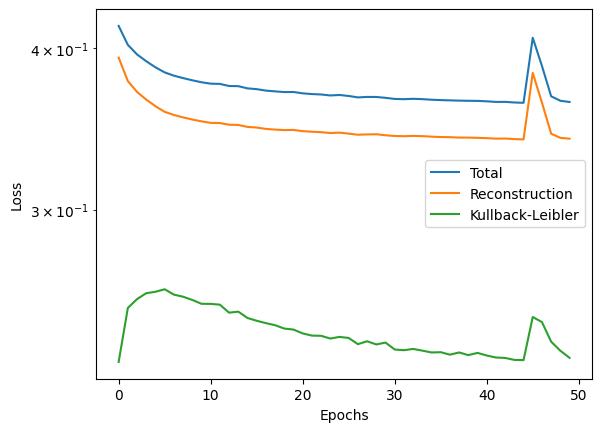

In [33]:
plt.ion()

fig = plt.figure()
plt.semilogy(total_losses, label='Total')
plt.semilogy(recon_losses, label='Reconstruction')
plt.semilogy(kl_losses, label='Kullback-Leibler')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Generation
----------

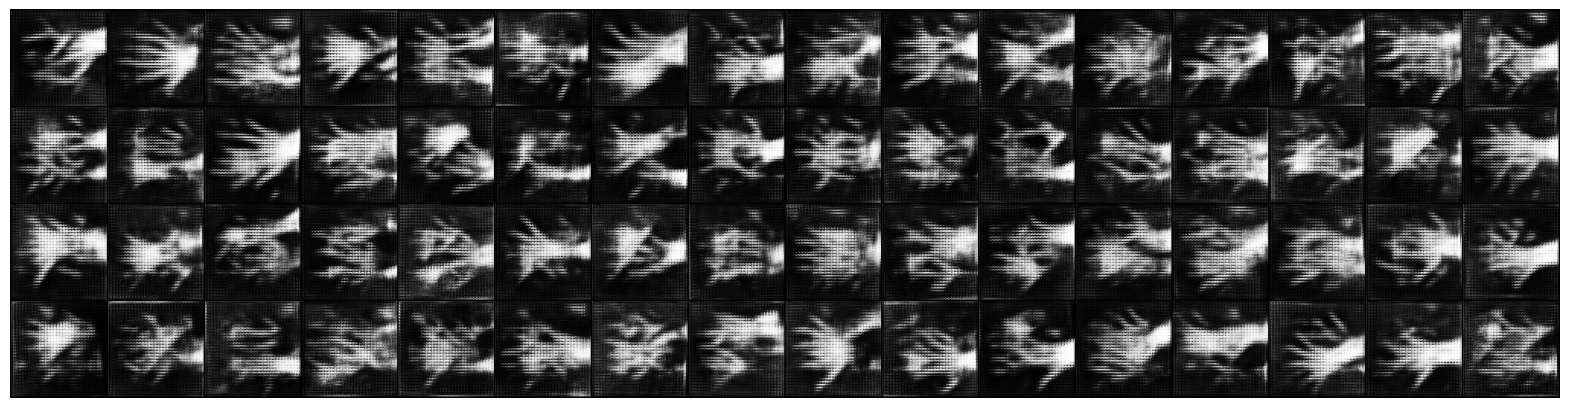

In [39]:
import torchvision.utils
import matplotlib.pyplot as plt

n = 16  # Number of images per row/column

with torch.no_grad():
    fig, ax = plt.subplots(figsize=(20, 20))
    
    # Create a grid of images
    grid = torchvision.utils.make_grid(fake_image_batch, nrow=n, normalize=True)
    
    # Display the grid
    ax.imshow(grid.permute(1, 2, 0).numpy(), cmap='gray')
    ax.axis('off')
    plt.show()


Visualization in Latent Space
-----------------------------

Generated image shape: torch.Size([1, 1, 8, 8])
Generated image shape: torch.Size([1, 1, 8, 8])
Generated image shape: torch.Size([1, 1, 8, 8])
Generated image shape: torch.Size([1, 1, 8, 8])
Generated image shape: torch.Size([1, 1, 8, 8])


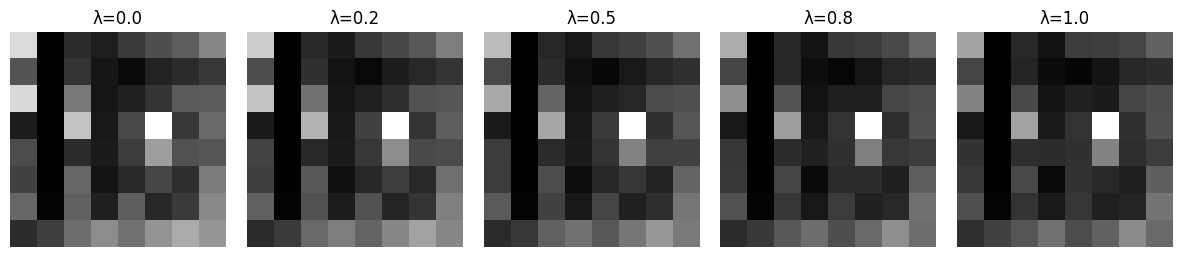

In [43]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

p.eval()

# Define the interpolation function
def interpolation(lambda1, model, latent_1, latent_2):
    with torch.no_grad():
        # Interpolate between the two latent vectors
        inter_latent = lambda1 * latent_1 + (1 - lambda1) * latent_2

        # Reshape latent vector if necessary
        inter_latent = inter_latent.unsqueeze(2).unsqueeze(3)  # [batch, latent_dim] -> [batch, latent_dim, 1, 1]

        # Generate the interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)

        # Debugging: Print the shape of the output
        print(f"Generated image shape: {inter_image.shape}")

        # Adjust the target shape based on actual output
        inter_image = inter_image.view(inter_image.shape[0], 1, *inter_image.shape[2:])  # Ensure correct shape
        return inter_image.cpu()

# Sample two latent vectors from the standard normal distribution
latent_1 = torch.randn((1, latent_dim), device=device)
latent_2 = torch.randn((1, latent_dim), device=device)

# Define interpolation lambdas
lambda_range = np.linspace(0, 1, 5)

# Create a figure for displaying the results
fig, axs = plt.subplots(1, len(lambda_range), figsize=(15, 3))
fig.subplots_adjust(wspace=0.1)
axs = axs.ravel()

# Loop over the lambda values to generate and display interpolated images
for ind, l in enumerate(lambda_range):
    inter_image = interpolation(float(l), p, latent_1, latent_2)
    
    # Convert tensor to numpy for visualization
    image = inter_image.numpy()

    # Display the image
    axs[ind].imshow(image[0, 0, :, :], cmap='gray')  # [batch, channel, height, width]
    axs[ind].set_title(f'λ={round(l, 1)}')
    axs[ind].axis('off')

plt.show()
